In [1]:
# Enable auto-reload of modified python files.
%load_ext autoreload
%autoreload 2

# Imports
from pprint import pprint 
from glob import glob
import sys, copy, os
import shlex, subprocess
sys.path.append('../')

import matplotlib
%matplotlib inline 
import matplotlib.image as mplimg
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm 
import seaborn as sns

import cv2

import numpy as np
import scipy
import pandas as pd
pd.set_eng_float_format(accuracy=3, use_eng_prefix=True)

from scipy import ndimage

import settings
import pickle as pck


# Helper functions
def cond_mkdir(path):
    '''Helper function to create a directory if it doesn't exist already.'''
    if not os.path.exists(path):
        os.makedirs(path)

def print_logfile_stats(log): 
    '''Prints the number of runs per viewpoint in this logfile.'''
    print("Total of %d runs."%len(log)) 
    for i in xrange(4): 
        print("Viewpoint %d: %d"%(i, len(log[log['viewpoint_idx']==i]))) 

def load_logfile(path): 
    '''
    Loads a logfile of eyetracking records from dist, given the path to the pickle file.
    '''
    with open(path, 'r') as log_file: 
        log = pck.load(log_file) 
    print("Loaded %s."%path) 
    print_logfile_stats(log) 
    return log 


def gnomonic2lat_lon(x_y_coords, fov_vert_hor, center_lat_lon):
    '''
    Converts gnomonoic (x, y) coordinates to (latitude, longitude) coordinates.
    
    x_y_coords: numpy array of floats of shape (num_coords, 2) 
    fov_vert_hor: tuple of vertical, horizontal field of view in degree
    center_lat_lon: The (lat, lon) coordinates of the center of the viewport that the x_y_coords are referencing.
    '''
    sphere_radius_lon = 1. / (2.0 * np.tan(np.radians(fov_vert_hor[1] / 2.0)))
    sphere_radius_lat = 1. / (2.0 * np.tan(np.radians(fov_vert_hor[0] / 2.0)))

    x, y = x_y_coords[:,0], x_y_coords[:,1]

    x_y_hom = np.column_stack([x.ravel(), y.ravel(), np.ones(len(x.ravel()))])

    K_inv = np.zeros((3, 3))
    K_inv[0, 0] = 1.0/sphere_radius_lon
    K_inv[1, 1] = 1.0/sphere_radius_lat
    K_inv[0, 2] = -1./(2.0*sphere_radius_lon)
    K_inv[1, 2] = -1./(2.0*sphere_radius_lat)
    K_inv[2, 2] = 1.0

    R_lat = np.zeros((3,3))
    R_lat[0,0] = 1.0
    R_lat[1,1] = np.cos(np.radians(-center_lat_lon[0]))
    R_lat[2,2] = R_lat[1,1]
    R_lat[1,2] = -1.0 * np.sin(np.radians(-center_lat_lon[0]))
    R_lat[2,1] = -1.0 * R_lat[1,2]

    R_lon = np.zeros((3,3))
    R_lon[2,2] = 1.0
    R_lon[0,0] = np.cos(np.radians(-center_lat_lon[1]))
    R_lon[1,1] = R_lon[0,0]
    R_lon[0,1] = - np.sin(np.radians(-center_lat_lon[1]))
    R_lon[1,0] = - R_lon[0,1]

    R_full = np.matmul(R_lon, R_lat)

    dot_prod = np.sum(np.matmul(R_full, K_inv).reshape(1,3,3) * x_y_hom.reshape(-1, 1, 3), axis=2)

    sphere_points = dot_prod/np.linalg.norm(dot_prod, axis=1, keepdims=True)

    lat = np.degrees(np.arccos(sphere_points[:, 2]))
    lon = np.degrees(np.arctan2(sphere_points[:, 0], sphere_points[:, 1]))

    lat_lon = np.column_stack([lat, lon])
    lat_lon = np.mod(lat_lon, np.array([180.0, 360.0]))

    return lat_lon

def angle2img(lat_lon_array, img_height_width):
    '''
    Convertes an array of latitude, longitude coordinates to image coordinates with range (0, height) x (0, width)
    '''
    return lat_lon_array / np.array([180., 360.]).reshape(1,2) * np.array(img_height_width).reshape(1,2)

def stitch2video(video_name, frame_dir, fps=30., print_output=False):
    '''
    Uses ffmpeg to stitch together a bunch of frames to a video. frame_dir has to be an absolute path. 
    '''
    framename_format_string = os.path.join(frame_dir, "%06d.png")
    ffmpeg_cmd = "ffmpeg -r %d -f image2 -s 1920x1080 -i %s -vcodec libx264 -crf 25  %s -y"%\
                    (fps, framename_format_string, video_name)
    args = shlex.split(ffmpeg_cmd)
    
    p = subprocess.Popen(args, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    output, err = p.communicate()
   
    if print_output:
        pprint(output)
        pprint(err)
        
def salmap_from_norm_coords(norm_coords, sigma, height_width):
    '''
    Base function to compute general saliency maps, given the normalized (from 0 to 1)
    fixation coordinates, the sigma of the gaussian blur, and the height and
    width of the saliency map in pixels.
    '''
    img_coords = np.mod(np.round(norm_coords * np.array(height_width)), np.array(height_width)-1.0).astype(int)

    gaze_counts = np.zeros((height_width[0], height_width[1]))
    for coord in img_coords:
        gaze_counts[coord[0], coord[1]] += 1.0

    gaze_counts[0, 0] = 0.0

    sigma_y = sigma
    salmap = ndimage.filters.gaussian_filter1d(gaze_counts, sigma=sigma_y, mode='wrap', axis=0)

    # In x-direction, we scale the radius of the gaussian kernel the closer we get to the pole
    for row in xrange(salmap.shape[0]):
        angle = (row/float(salmap.shape[0]) - 0.5) * np.pi
        sigma_x = sigma_y / (np.cos(angle) + 1e-3)
        salmap[row,:] = ndimage.filters.gaussian_filter1d(salmap[row,:], sigma=sigma_x, mode='wrap')

    salmap /= float(np.sum(salmap))
    return salmap

        
def get_gaze_salmap(list_of_runs, sigma_deg=1.0, height_width=(720, 1440)):
    '''Computes gaze saliency maps.'''
    fixation_coords = []

    for run in list_of_runs:
        relevant_fixations = run['gaze_fixations']

        if len(relevant_fixations.shape) > 1:
            _, unique_idcs = np.unique(relevant_fixations[:, 0], return_index=True)
            all_fixations = relevant_fixations[unique_idcs]
            fixation_coords.append(all_fixations)

    norm_coords = np.vstack(fixation_coords)[:,::-1]

    return salmap_from_norm_coords(norm_coords, sigma_deg * height_width[1]/360.0, height_width)

def get_head_salmap(list_of_runs, height_width=(720, 1440)):
    '''Computes head saliency maps.'''
    thresh=37.196
    all_head_velos = []
    all_head_lat_lons = []

    for run in list_of_runs:
        all_head_velos.append(run['ang_head_velo'])
        all_head_lat_lons.append(run['headLatLon'])

    head_velos = np.vstack(all_head_velos)
    head_lat_lons = np.vstack(all_head_lat_lons)

    fixation_idcs = head_velos[:, 1] < thresh
    fix_lat_lons = head_lat_lons[fixation_idcs]
    norm_fix_coords = fix_lat_lons / np.array([180, 360])

    # Get this cubemap's gaze salmap
    salmap = salmap_from_norm_coords(norm_fix_coords, sigma=19.0, height_width=height_width)

    return salmap

def overlay_image_salmap(img_path, salmap):
    '''Overlays an image with a saliency map.'''
    image = matplotlib.image.imread(img_path).astype(float)[:,:,:3]
    salmap_resized = cv2.resize(salmap, (image.shape[1], image.shape[0])).astype(float)

    fig,ax = plt.subplots(frameon=False)
    fig.set_size_inches(16,8)

    ax.imshow(image)
    ax.imshow(salmap_resized, cmap=plt.cm.jet, alpha=0.4)

    ax.axis('tight')
    ax.axis('off')
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)

    return fig, ax

def filter_starting_point(list_of_runs, threshold_deg=20.0):
    '''Filters all measurements of a run that are at the 
    beginning and in a vicinity of threshold_deg around the starting coordinates.'''
    cleaned_runs = []
    for run in list_of_runs:
        init_starting_point_lon = run['gaze_lat_lon'][0, 1]
        outside_bool = np.absolute(init_starting_point_lon - run['gaze_lat_lon'][:, 1])>threshold_deg
        if np.any(outside_bool):
            first_left = np.amin(np.where(outside_bool)[0])
            cleaned_runs.append({key:value[first_left:] for key, value in run.iteritems()})
        else:
            cleaned_runs.append(run)
    return cleaned_runs

def get_data_matrix(list_of_runs, column_set='vr'):
    '''Joins specified columns of a list of runs to a single data matrix
    gaze_lat_lon_offset_lon'''
    if column_set=='vr':
        columns=['gaze_lat_lon_offset', 'gaze_fixations_single', 'ang_gaze_offset_velo', 'ang_head_velo', 'ang_gaze_velo', 'headTilt', 'gaze_fixations_ind']
    else:
        columns=['gaze_lat_lon_offset', 'gaze_fixations_single', 'ang_gaze_offset_velo', 'ang_head_velo', 'ang_gaze_velo', 'gaze_fixations_ind']
        
    data = []
    column_names =[]
    for column in columns:
        array_list = []

        for run in list_of_runs:
            array_list.append(np.squeeze(np.array(run[column])))

        if len(array_list[0].shape) == 1:
            joined_array = np.concatenate(array_list)

            data.append(joined_array)
            column_names.append(column)
        else:
            joined_array = np.vstack(array_list)

            data.append(joined_array[:, 0])
            data.append(joined_array[:, 1])
            column_names.append(column + '_lat')
            column_names.append(column + '_lon')

    return np.column_stack(data), column_names

def reject_gauss_outliers(data, column_names, m=2, take_absolute=True):
    '''Function to reject the outliers visible in above plot. Assumes a fundamentally normal distribution,
    which is close to what we see in the data.'''
    if take_absolute:
        data_ = np.absolute(data)
    else:
        data_ = np.copy(data)

    data_ = np.ma.masked_invalid(data_)

    col_means = np.nanmean(data_, axis=0, keepdims=True)
    centered_data = data_ - col_means
    column_stds = np.nanstd(data_, axis=0)

    bad_values_bool = np.absolute(centered_data) > m * column_stds
    bad_values = np.where(bad_values_bool)

    cleaned_data = np.copy(data)
    cleaned_data[bad_values] = np.take(col_means,bad_values[1])

    print("Rejection percentages:")
    for i in xrange(bad_values_bool.shape[1]):
        print("Column %s: %0.4f"%(column_names[i],
                               float(np.sum(bad_values_bool[:, i], axis=0))/bad_values_bool.shape[0]))

    return cleaned_data, col_means, column_stds

def plot_with_viewport(img, viewport_coords, out_path):
    viewport_coords_resh = viewport_coords.reshape(800,800,2)
    upper_line = viewport_coords_resh[0,:,:]
    lower_line = viewport_coords_resh[-1, :,:]
    right_line = viewport_coords_resh[:,-1, :]
    left_line=viewport_coords_resh[:,0,:]

    lines = [upper_line, lower_line, right_line, left_line]

    split_lines = []
    for line in lines:
        diff = np.diff(line, axis=0)
        wrap_idcs = np.where(np.abs(diff)>10)[0]
        if not len(wrap_idcs):
            split_lines.append(line)
        else:
            split_lines.append(line[:wrap_idcs[0]+1])
            split_lines.append(line[wrap_idcs[0]+1:])

    fig, ax = plt.subplots(frameon=False)
    fig.set_size_inches(48,24)
    ax.imshow(img)
 
    for line in split_lines:
        ax.plot(line[:,1], line[:,0], color='black', linewidth=10)
 
    for line in split_lines:
        ax.plot(line[:,1], line[:,0], color='white',linewidth=8)
 
    ax.axis('tight')
    ax.axis('off')
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)

    fig.savefig(out_path, bbox_inches='tight', pad_inches=0)
    fig.clf()
    plt.close()

def get_gnomonic_hom(center_lat_lon, origin_image, height_width, fov_vert_hor=(60.0, 60.0) ):
    '''Extracts a gnomonic viewport with height_width from origin_image 
    at center_lat_lon with field of view fov_vert_hor.
    '''
    org_height_width, _ = origin_image.shape[:2], origin_image.shape[-1]
    height, width = height_width
    
    if len(origin_image.shape) == 3:
        result_image = np.zeros((height, width, 3))
    else:
        result_image = np.zeros((height, width))        

    sphere_radius_lon = width / (2.0 * np.tan(np.radians(fov_vert_hor[1] / 2.0)))
    sphere_radius_lat = height / (2.0 * np.tan(np.radians(fov_vert_hor[0] / 2.0)))

    y, x = np.mgrid[0:height, 0:width]
    x_y_hom = np.column_stack([x.ravel(), y.ravel(), np.ones(len(x.ravel()))])

    K_inv = np.zeros((3, 3))
    K_inv[0, 0] = 1.0/sphere_radius_lon
    K_inv[1, 1] = 1.0/sphere_radius_lat
    K_inv[0, 2] = -width/(2.0*sphere_radius_lon)
    K_inv[1, 2] = -height/(2.0*sphere_radius_lat)
    K_inv[2, 2] = 1.0

    R_lat = np.zeros((3,3))
    R_lat[0,0] = 1.0
    R_lat[1,1] = np.cos(np.radians(-center_lat_lon[0]))
    R_lat[2,2] = R_lat[1,1]
    R_lat[1,2] = -1.0 * np.sin(np.radians(-center_lat_lon[0]))
    R_lat[2,1] = -1.0 * R_lat[1,2]

    R_lon = np.zeros((3,3))
    R_lon[2,2] = 1.0
    R_lon[0,0] = np.cos(np.radians(-center_lat_lon[1]))
    R_lon[1,1] = R_lon[0,0]
    R_lon[0,1] = - np.sin(np.radians(-center_lat_lon[1]))
    R_lon[1,0] = - R_lon[0,1]

    R_full = np.matmul(R_lon, R_lat)

    dot_prod = np.sum(np.matmul(R_full, K_inv).reshape(1,3,3) * x_y_hom.reshape(-1, 1, 3), axis=2)

    sphere_points = dot_prod/np.linalg.norm(dot_prod, axis=1, keepdims=True)

    lat = np.degrees(np.arccos(sphere_points[:, 2]))
    lon = np.degrees(np.arctan2(sphere_points[:, 0], sphere_points[:, 1]))

    lat_lon = np.column_stack([lat, lon])
    lat_lon = np.mod(lat_lon, np.array([180.0, 360.0]))

    org_img_y_x = lat_lon / np.array([180.0, 360.0]) * np.array(org_height_width)
    org_img_y_x = np.clip(org_img_y_x, 0.0, np.array(org_height_width).reshape(1, 2) - 1.0).astype(int)
    org_img_y_x = org_img_y_x.astype(int)
    
    if len(origin_image.shape) == 3:
        result_image[x_y_hom[:, 1].astype(int), x_y_hom[:, 0].astype(int), :] = origin_image[org_img_y_x[:, 0],
                                                                     org_img_y_x[:, 1], :]  
    else:
        result_image[x_y_hom[:, 1].astype(int), x_y_hom[:, 0].astype(int)] = origin_image[org_img_y_x[:, 0],
                                                                     org_img_y_x[:, 1]] 
    return result_image.astype(float), org_img_y_x

def get_pano_no(pano_no, undersample=3):
    '''Helper function to load the panorama oc scene pano_no and downsample it by a factor of undersample.'''
    path = os.path.join(settings.IMG_PATH, 'cubemap_%04d.png'%pano_no)
    pano = mplimg.imread(path)
    pano = pano[::undersample, ::undersample, :3]
    return pano

def extract_vid_frames(vid_path, target_dir, fps=15, print_output=False):
    '''Extract frames from a video, wrapping ffmpeg.'''
    vid_name = os.path.basename(vid_path)
    vid_name_no_ext = os.path.splitext(vid_name)[0]
    
    ffmpeg_template = 'ffmpeg -i {} -vf fps={} {}'

    ffmpeg_cmd = ffmpeg_template.format(vid_path, fps, os.path.join(target_dir, '%06d.png'))
    args = shlex.split(ffmpeg_cmd)
    
    p = subprocess.Popen(args, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    output, err = p.communicate()
   
    if print_output:
        pprint(output)
        pprint(err)
        
def interpolate_nan_rows(array, bad_rows_bool):
    '''Interpolates nan rows in an array.'''
    if True not in bad_rows_bool.astype(bool): return array

    good_rows = np.where(np.logical_not(bad_rows_bool))[0]

    # Since extrapolation is a bad idea, we identify the low-confidence indices that are outside the interpolatable range.
    low_non_nan, high_non_nan = np.amin(good_rows), np.amax(good_rows)
    interp_idcs = np.copy(bad_rows_bool)
    interp_idcs[high_non_nan:] = False
    interp_idcs[:low_non_nan] = False

    extra_idcs = np.logical_and(bad_rows_bool,
                             np.logical_or(np.arange(len(bad_rows_bool)) <= low_non_nan,
                                           np.arange(len(bad_rows_bool)) >= high_non_nan))

    interp_func = scipy.interpolate.interp1d(good_rows,
                                    np.take(array, good_rows, axis=0),
                                    kind='linear',
                                    axis=0)
    array[interp_idcs] = interp_func(np.where(interp_idcs)[0])
    # The indices outside the interpolatable range are set to the mean of the series.
    array[extra_idcs] = np.mean(array[good_rows], axis=0)

    return array
print("Done")

ModuleNotFoundError: No module named 'cPickle'

## Preload files into memory

In [ ]:
# Load runs for standing VR condition
all_files = sorted(glob(os.path.join(settings.DATASET_PATH_VR, '*.pck')))
runs_files = [load_logfile(logfile) for logfile in all_files]

# Also assemble all runs into a single list for analyses on all scenes.      
all_runs_list = []
for run in runs_files:
    all_runs_list.extend(run['data'])  
print(len(all_runs_list))

In [ ]:
# Load runs for browser condition
all_files_browser = sorted(glob(os.path.join(settings.DATASET_PATH_BROWSER, '*.pck')))
runs_files_browser = [load_logfile(logfile) for logfile in all_files_browser]
        
# Also assemble all runs into a single list for analyses on all scenes.      
all_runs_list_browser = []
for run in runs_files_browser:
    all_runs_list_browser.extend(run['data'])  
print(len(all_runs_list_browser))

# Animate runs in scene 0

In [7]:
def plot_fov(center_lat_lon, ax, color, fov_vert_hor, height_width):
    '''
    Plots the correctly warped FOV at a given center_lat_lon.
    center_lat_lon: Float tuple of latitude, longitude. Position where FOV is centered
    ax: The matplotlib axis object that should used for plotting.
    color: Color of the FOV box.
    height_width: Height and width of the image.
    '''
    # Coordinates for a rectangle.
    coords = []
    coords.append([np.linspace(0.0, 1.0, 100), [1.]*100])
    coords.append([[1.]*100, np.linspace(0.0, 1.0, 100)])
    coords.append([np.linspace(0.0, 1.0, 100), [0.]*100])
    coords.append([[0.]*100, np.linspace(0.0, 1.0, 100)])    

    lines = []
    for coord in coords:
        lat_lon_array = gnomonic2lat_lon(np.column_stack(coord), fov_vert_hor=fov_vert_hor, 
                                         center_lat_lon=center_lat_lon)
        img_coord_array = angle2img(lat_lon_array, height_width)
        lines.append(img_coord_array)
        
    split_lines = []
    for line in lines:
        diff = np.diff(line, axis=0)
        wrap_idcs = np.where(np.abs(diff)>np.amin(height_width))[0]
        
        if not len(wrap_idcs):
            split_lines.append(line)
        else:
            split_lines.append(line[:wrap_idcs[0]+1])
            split_lines.append(line[wrap_idcs[0]+1:])

    for line in split_lines:
        ax.plot(line[:,1], line[:,0], color=color, linewidth=1.2, alpha=0.5)

In [21]:
def render_exploration_frames(scene_df, 
                              img_path,
                              target_dir='frames',
                              duration=30.,
                              fps=30.):
    '''
    Renders single frames of a video that visualizes scanpaths and FOV of users in the VR scene img_path.
    Frames can subsequently be stitched together with ffmpeg.
    
    scene_df: pandas Dataframe with all the runs for a specific scene.
    img_path: Path to the equirectangular scene file.
    duration: Duration of the animation in seconds.
    fps: Target fps.
    '''
    num_frames = fps * duration
    img_height, img_width = 2048, 4096
    image = cv2.resize(cv2.imread(img_path), (img_width, img_height))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    frame_no = 0
        
    for t in np.linspace(0., duration, num_frames):
        plt.close('all')

        fig, ax = plt.subplots(frameon=False, figsize=(16,9))
        
        ax.grid(b=False)
        plt.setp(ax.get_xticklabels(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)

        ax.imshow(image)
        ax.axis('tight')
        ax.set_xlim([0,img_width])
        ax.set_ylim([img_height, 0])
        
        time_template = 'time %.1fs'
        time_text = ax.text(0.05, 0.9, '', size='large', transform=ax.transAxes)
        time_text.set_text(time_template % t)

        fov_vert = 106.188
        aspect_ratio = 0.82034051
        fov_hor = fov_vert * aspect_ratio
        fov_vert_hor = np.array([fov_vert, fov_hor])

        colors = cm.rainbow(np.linspace(0, 1, len(scene_df)))
                
        for color, log_df in zip(colors, scene_df['data']):
            time_filtered = np.where(log_df['timestamp']<=t)[0]
            if len(time_filtered):
                frame_idx = np.amax(time_filtered)
                
                if frame_idx >= len(log_df['timestamp']): 
                    continue
            else:
                continue
            gaze_coords = angle2img(log_df['gaze_lat_lon'][frame_idx, :], (img_height, img_width))
            print(gaze_coords)
            print(gaze_coords[0][0],gaze_coords[0][1])
            head_lat_lon = log_df['headLatLon'][frame_idx, :]
            ax.plot(gaze_coords[0][1], gaze_coords[0][0], marker='o', markersize=12., color=color, alpha=.8)
            
            plot_fov(head_lat_lon, ax, color, fov_vert_hor, height_width=np.array([img_height, img_width]))
        
        fig.savefig(os.path.join(target_dir, "%06d.png"%frame_no), bbox_inches='tight', pad_inches=0, dpi=160)
        frame_no += 1
        fig.clf()

In [23]:
animation = render_exploration_frames(runs_files[0], os.path.join(settings.IMG_PATH, 'cubemap_0000.png'), fps=24)

/opt/anaconda3/envs/base-2.7/lib/python2.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


[[ 956.91291323 2032.98442795]]
(956.9129132290278, 2032.9844279518024)
[[ 977.48825773 3078.26479616]]
(977.4882577276603, 3078.2647961585503)
[[1019.93998816 4091.35640133]]
(1019.9399881596099, 4091.35640133302)
[[1023.12183292 4083.61177963]]
(1023.1218329198892, 4083.6117796272956)
[[1061.84534251 1003.83381639]]
(1061.8453425100279, 1003.8338163939405)
[[1032.45861959 3038.97910497]]
(1032.4586195873978, 3038.9791049690098)
[[ 958.27895614 3074.55432217]]
(958.2789561352046, 3074.554322173038)
[[1126.15545725 2040.91591769]]
(1126.1554572462667, 2040.9159176911576)
[[1013.88925136    3.18157748]]
(1013.8892513570452, 3.1815774794606235)
[[1116.70594892 4010.72636003]]
(1116.7059489205055, 4010.726360030729)
[[1015.18227964 1037.87954714]]
(1015.1822796420162, 1037.87954714429)
[[1029.73495451 2043.10047673]]
(1029.73495450561, 2043.1004767305446)
[[ 970.45304854 4095.08810599]]
(970.4530485356858, 4095.0881059893595)
[[1016.86802713 4087.26918433]]
(1016.8680271300094, 4087.26918

[[ 956.29867305 2035.14741848]]
(956.2986730534548, 2035.147418479328)
[[ 976.80301908 3077.52775961]]
(976.803019083231, 3077.527759607678)
[[1019.91190935 4092.6897976 ]]
(1019.9119093549913, 4092.689797598015)
[[1021.89296554 4084.11915504]]
(1021.8929655397429, 4084.1191550368603)
[[1059.09545734 1003.80628654]]
(1059.0954573396148, 1003.8062865386585)
[[1032.8435996  3042.51908623]]
(1032.8435995958848, 3042.5190862337145)
[[ 956.19669272 3075.59119078]]
(956.1966927244328, 3075.591190777806)
[[1119.51162016 2041.82523387]]
(1119.511620159412, 2041.8252338747109)
[[1014.05639103    3.94485537]]
(1014.0563910319814, 3.9448553652055645)
[[1156.69089485 4012.21875707]]
(1156.690894847005, 4012.2187570720625)
[[1016.12794641 1038.77981057]]
(1016.1279464122989, 1038.7798105728673)
[[1028.94676629 2043.70607576]]
(1028.946766292182, 2043.7060757582572)
[[9.72731769e+02 6.94102243e-01]]
(972.7317686336766, 0.6941022430730395)
[[1016.91314126 4087.28460015]]
(1016.9131412566543, 4087.284

[[1077.20164695 2057.55771172]]
(1077.2016469454834, 2057.5577117222983)
[[ 977.61379653 3075.79728582]]
(977.6137965307054, 3075.7972858182206)
[[1019.9091209  4094.13918618]]
(1019.9091209028204, 4094.139186181827)
[[1023.73338847 4084.36843092]]
(1023.7333884741123, 4084.3684309227606)
[[1188.73565023 1055.57941888]]
(1188.7356502299185, 1055.5794188841517)
[[1036.73266611 3041.4126198 ]]
(1036.7326661078368, 3041.4126198022263)
[[ 953.94828539 3074.20051991]]
(953.948285393258, 3074.200519908103)
[[1118.68982815 2043.17742787]]
(1118.6898281546705, 2043.1774278740515)
[[1005.73900142 4091.91533399]]
(1005.7390014191782, 4091.9153339938366)
[[937.99095814  32.97465007]]
(937.9909581431781, 32.974650073763705)
[[1013.28130022 1038.96602414]]
(1013.2813002184351, 1038.9660241413576)
[[1052.34503194 2042.11870947]]
(1052.345031936133, 2042.1187094699685)
[[ 976.07102319 4095.62200446]]
(976.0710231900731, 4095.622004458927)
[[1112.68237524 3932.2437789 ]]
(1112.68237523725, 3932.243778

[[1076.94900883 2058.55281171]]
(1076.949008825944, 2058.5528117126964)
[[1117.60741766 3049.74200329]]
(1117.6074176587483, 3049.742003293071)
[[1092.03325911   65.45474088]]
(1092.0332591106549, 65.45474087858253)
[[1024.31717681 4083.97867998]]
(1024.3171768132752, 4083.978679980338)
[[1183.34676616 1057.02238541]]
(1183.3467661593775, 1057.022385409629)
[[1035.82161939 3042.21257578]]
(1035.8216193911271, 3042.2125757792996)
[[1005.11008981 3039.66348456]]
(1005.1100898099646, 3039.6634845595063)
[[1220.38132684 2034.79952352]]
(1220.3813268436281, 2034.7995235160472)
[[1012.26642513 4084.90010365]]
(1012.2664251337004, 4084.900103649806)
[[987.80862016  65.94686264]]
(987.8086201625039, 65.94686264263684)
[[1012.5330388  1037.71425661]]
(1012.5330387980893, 1037.714256608216)
[[1128.78380652 2030.8916849 ]]
(1128.7838065166634, 2030.8916848967554)
[[ 993.09603043 3944.72167115]]
(993.0960304316645, 3944.721671146906)
[[1166.44962415 3813.79378215]]
(1166.4496241546751, 3813.793782

[[1121.09480911 1906.97865192]]
(1121.0948091071464, 1906.97865192472)
[[1115.91000607 3050.03816307]]
(1115.9100060676592, 3050.0381630686757)
[[1091.33085632   66.07787319]]
(1091.3308563211708, 66.07787318573243)
[[1178.08649903 4003.28090766]]
(1178.0864990298594, 4003.280907661648)
[[1212.50046081 1026.52404983]]
(1212.5004608127883, 1026.5240498329106)
[[1036.77831965 3042.61010643]]
(1036.7783196501598, 3042.6101064339864)
[[1026.03813233 2957.84686644]]
(1026.038132331032, 2957.846866442704)
[[1214.38744697 2035.22497625]]
(1214.3874469717073, 2035.2249762475112)
[[1130.32170987 3824.67370154]]
(1130.3217098650694, 3824.6737015369413)
[[1082.66390878   30.27313009]]
(1082.663908778867, 30.273130092197057)
[[1147.497217   1010.06412139]]
(1147.4972169980915, 1010.0641213858053)
[[1082.11012341 1782.8622627 ]]
(1082.1101234074342, 1782.8622627036202)
[[ 994.47544493 3929.2933995 ]]
(994.4754449336347, 3929.2933994954615)
[[1200.22862624 3740.27742233]]
(1200.2286262378036, 3740.2

[[1133.45211232 1708.20299519]]
(1133.4521123197821, 1708.2029951901395)
[[1144.90764105 3061.99437459]]
(1144.9076410524572, 3061.9943745879314)
[[1090.54076651   66.11747981]]
(1090.5407665112996, 66.1174798091825)
[[1180.71751103 3998.15616416]]
(1180.7175110276826, 3998.1561641583457)
[[1223.06174594 1022.43665412]]
(1223.0617459403968, 1022.4366541233574)
[[1036.41176567 3042.720902  ]]
(1036.4117656671742, 3042.720902001955)
[[ 987.07876131 2956.97308291]]
(987.0787613112481, 2956.973082912943)
[[1218.65512341 2035.98281457]]
(1218.655123413767, 2035.9828145681731)
[[1169.09501684 3745.23175427]]
(1169.095016842943, 3745.231754268801)
[[1277.61610021 4016.87183604]]
(1277.6161002065808, 4016.87183603769)
[[1148.32320705 1006.85478903]]
(1148.3232070488427, 1006.8547890331151)
[[1079.29416542 1681.17342753]]
(1079.2941654222986, 1681.1734275317287)
[[1134.05040878 3712.17131168]]
(1134.0504087808492, 3712.171311683188)
[[1192.01053201 3741.02697774]]
(1192.0105320145365, 3741.0269

[[1213.92734419 1467.57324813]]
(1213.9273441881362, 1467.5732481262255)
[[1037.50441097 3150.66346129]]
(1037.5044109662033, 3150.6634612933817)
[[1173.67217836 3819.06917974]]
(1173.6721783575217, 3819.069179743998)
[[1168.60222997 3720.95948681]]
(1168.60222996588, 3720.9594868121085)
[[1192.09389445  732.17867203]]
(1192.0938944451132, 732.1786720346252)
[[1040.73797482 3292.19574884]]
(1040.7379748151134, 3292.195748844239)
[[1015.32085305 2973.80647684]]
(1015.3208530455624, 2973.8064768367617)
[[1142.90632756 2058.60386594]]
(1142.9063275575359, 2058.6038659396822)
[[1151.28688699 3687.65064769]]
(1151.2868869944311, 3687.6506476899012)
[[933.38181629  92.10069939]]
(933.3818162855279, 92.10069938766115)
[[1181.53084739 1004.98836664]]
(1181.5308473888158, 1004.9883666449073)
[[1143.98912603 1424.93629201]]
(1143.989126031371, 1424.936292014693)
[[1153.43817802 3668.10784269]]
(1153.4381780242022, 3668.107842688767)
[[1184.25997649 3742.12660612]]
(1184.259976491119, 3742.126606

[[1220.11273356 1394.53225078]]
(1220.112733555067, 1394.53225078321)
[[ 958.88115819 3254.81909557]]
(958.8811581921116, 3254.8190955658088)
[[1175.36117579 3792.66484745]]
(1175.3611757917163, 3792.664847451998)
[[1172.50962448 3717.19430037]]
(1172.509624482256, 3717.194300373246)
[[1170.20896249  531.58028273]]
(1170.2089624907417, 531.5802827286002)
[[1038.59965544 3299.89013082]]
(1038.599655435206, 3299.890130816065)
[[1152.31597858 3035.92768796]]
(1152.3159785834039, 3035.92768795791)
[[1143.46569338 2058.07094467]]
(1143.4656933824613, 2058.0709446749347)
[[1038.13216005 3483.55460755]]
(1038.1321600475794, 3483.5546075528337)
[[947.97431421  92.76708473]]
(947.9743142105249, 92.76708473207839)
[[1144.12641607 1000.66582252]]
(1144.1264160744795, 1000.6658225188421)
[[1137.17576991 1402.67594399]]
(1137.1757699053849, 1402.675943993929)
[[1155.28551894 3741.76508721]]
(1155.2855189439022, 3741.7650872085883)
[[1191.32963825 3680.54600266]]
(1191.3296382531196, 3680.5460026639

[[1219.4489757  1393.82572687]]
(1219.4489756992746, 1393.8257268665163)
[[ 966.1315449  3269.21385855]]
(966.1315449043373, 3269.2138585516104)
[[1193.88477671 3748.92789447]]
(1193.8847767056482, 3748.9278944737634)
[[1415.50417321 3884.9656853 ]]
(1415.5041732076716, 3884.9656852958115)
[[1180.92326151  543.9840155 ]]
(1180.9232615095002, 543.9840155019664)
[[1084.30270448 3516.00016549]]
(1084.3027044769133, 3516.0001654851644)
[[1144.66865248 3035.93415142]]
(1144.668652482517, 3035.9341514215066)
[[1139.63332726 2060.40941461]]
(1139.6333272610718, 2060.409414612806)
[[1070.77071027 3280.06014688]]
(1070.7707102704933, 3280.0601468800205)
[[959.8071764  115.13899179]]
(959.8071763956927, 115.13899178660651)
[[1149.47800661 1001.05582943]]
(1149.478006609879, 1001.05582942688)
[[1140.38930066 1428.64264216]]
(1140.3893006560145, 1428.6426421583021)
[[1161.283837  3744.6404821]]
(1161.2838369962546, 3744.640482097306)
[[1193.3111192  3660.53895293]]
(1193.311119204118, 3660.5389529

[[1219.39727992 1227.71085967]]
(1219.3972799157034, 1227.7108596732382)
[[ 999.97977383 3435.49971051]]
(999.9797738284657, 3435.49971051241)
[[1197.51634028 3752.35863027]]
(1197.516340282428, 3752.3586302737076)
[[1413.09484898 3879.4761771 ]]
(1413.0948489756188, 3879.4761770993136)
[[1177.09748144  538.93456448]]
(1177.0974814356514, 538.9345644774356)
[[1079.20219278 3521.26284551]]
(1079.2021927752428, 3521.26284550772)
[[1300.65787414 3136.52730262]]
(1300.6578741433218, 3136.5273026234695)
[[1138.23188957 2060.81087731]]
(1138.2318895654498, 2060.81087731351)
[[1106.69070632 3233.2629372 ]]
(1106.690706322096, 3233.2629371982066)
[[1068.42384413  289.05146378]]
(1068.4238441259745, 289.0514637770114)
[[997.77179108 946.96316833]]
(997.7717910803159, 946.9631683251757)
[[1100.75736877 1438.88485911]]
(1100.757368769624, 1438.884859111459)
[[1340.58340996 3568.19869083]]
(1340.583409955722, 3568.1986908349363)
[[1192.33696625 3658.92284707]]
(1192.3369662527182, 3658.92284706608

[[1106.29509966 1109.38349571]]
(1106.2950996606185, 1109.383495713114)
[[1005.98487895 3564.84012363]]
(1005.9848789465897, 3564.840123632528)
[[1141.21624734 3700.61597184]]
(1141.2162473386995, 3700.6159718421263)
[[1545.41121838 3919.98368399]]
(1545.411218382543, 3919.983683988889)
[[1271.04658829  605.77795313]]
(1271.0465882877788, 605.7779531319688)
[[1220.48965661 3714.68582659]]
(1220.4896566116258, 3714.685826588492)
[[1294.94773801 3136.77236493]]
(1294.9477380111407, 3136.772364925485)
[[1153.00325261 2169.7330927 ]]
(1153.0032526145797, 2169.733092700674)
[[1119.6188867  3227.66261533]]
(1119.6188866953885, 3227.6626153332477)
[[1051.8739303  305.1659791]]
(1051.8739302995905, 305.16597910111574)
[[819.66208666 918.76373768]]
(819.6620866554628, 918.7637376793375)
[[1107.12435139 1401.72950572]]
(1107.124351392921, 1401.7295057166905)
[[1341.2653308  3565.34021401]]
(1341.2653307956268, 3565.340214006526)
[[1089.60682841 3627.16724177]]
(1089.6068284145617, 3627.167241774

[[1096.97353203 1090.71913459]]
(1096.973532031607, 1090.7191345876568)
[[1006.98092083 3573.82991277]]
(1006.980920827779, 3573.8299127737782)
[[1019.69177317 3576.63036098]]
(1019.6917731673013, 3576.630360979623)
[[1540.12623807 3909.40802886]]
(1540.1262380659127, 3909.4080288569176)
[[1323.16456704  711.43194034]]
(1323.1645670443795, 711.4319403421368)
[[1214.98366991 3722.71563427]]
(1214.983669907897, 3722.7156342657477)
[[1291.60912222 3141.63823786]]
(1291.6091222245307, 3141.638237863941)
[[1188.68338873 2381.82479957]]
(1188.6833887271937, 2381.824799573344)
[[1149.27733447 3035.04618505]]
(1149.2773344713437, 3035.0461850486295)
[[1280.50989959  530.16185859]]
(1280.5098995865153, 530.1618585945547)
[[818.16879774 920.86469968]]
(818.1687977412906, 920.8646996796938)
[[1102.30166237 1360.42205443]]
(1102.3016623679478, 1360.4220544281739)
[[1121.73896545 3303.44636868]]
(1121.7389654464632, 3303.4463686822705)
[[1016.57030113 3589.92281044]]
(1016.5703011343725, 3589.92281

[[1095.35113103 1091.03666316]]
(1095.3511310295423, 1091.0366631566299)
[[1053.46348691 3640.0476891 ]]
(1053.463486905879, 3640.047689103043)
[[1020.69716746 3542.24186602]]
(1020.6971674605497, 3542.2418660178746)
[[1538.08969448 3905.87294333]]
(1538.089694481154, 3905.872943333767)
[[1329.65480721  831.73286236]]
(1329.6548072124, 831.7328623618534)
[[1305.61560391 3995.93112054]]
(1305.6156039106095, 3995.931120539079)
[[1257.54170248 3237.22166555]]
(1257.5417024792469, 3237.2216655494094)
[[1172.95968488 2436.53727266]]
(1172.9596848824726, 2436.53727265863)
[[1162.22405429 3026.30089816]]
(1162.2240542886504, 3026.300898161793)
[[1296.34212033  607.21816811]]
(1296.342120333561, 607.2181681118808)
[[ 920.66388265 1052.45022367]]
(920.6638826509486, 1052.4502236727187)
[[1113.43125797 1320.93987334]]
(1113.4312579699977, 1320.939873336401)
[[1131.05311358 3285.49745388]]
(1131.0531135781102, 3285.4974538804686)
[[1017.91065246 3586.24981616]]
(1017.9106524648641, 3586.249816160

[[1094.38359909 1084.3279048 ]]
(1094.3835990882499, 1084.3279047992546)
[[1150.32772474 3732.63519342]]
(1150.3277247354588, 3732.635193424924)
[[1017.47444813 3369.10644737]]
(1017.4744481348638, 3369.106447374179)
[[1538.01989314 3902.86406427]]
(1538.0198931422744, 3902.8640642714804)
[[1300.25358001  996.79379312]]
(1300.2535800122705, 996.7937931240442)
[[1302.57557111 4008.1392513 ]]
(1302.5755711137283, 4008.139251299645)
[[1202.69035265 3309.98633103]]
(1202.6903526452988, 3309.9863310300875)
[[1182.22630994 2448.78330809]]
(1182.2263099382267, 2448.783308090309)
[[1114.66816226 2927.29895997]]
(1114.668162264792, 2927.2989599665448)
[[1432.55159231  353.27912435]]
(1432.551592313473, 353.2791243482997)
[[ 927.55991308 1067.72631926]]
(927.5599130801668, 1067.726319260464)
[[1110.45732886 1264.99009609]]
(1110.4573288590755, 1264.990096089399)
[[1126.08918717 3279.49977242]]
(1126.0891871721938, 3279.4997724154255)
[[1011.22410695 3566.80524165]]
(1011.2241069508492, 3566.8052

[[1077.22363549 1096.76572048]]
(1077.2236354945912, 1096.765720477822)
[[1155.30561817 3747.25667427]]
(1155.30561816519, 3747.2566742662643)
[[1022.2171084  3344.22893944]]
(1022.2171084008311, 3344.228939435364)
[[1388.2499139  3817.45361684]]
(1388.2499138986116, 3817.45361683669)
[[1287.61906236 1004.86201453]]
(1287.6190623582445, 1004.8620145336356)
[[1265.26705913   32.61259012]]
(1265.2670591344925, 32.612590121275154)
[[1075.72218049 3465.03746455]]
(1075.7221804914432, 3465.0374645461548)
[[1223.62630304 2518.54659141]]
(1223.626303038082, 2518.5465914101414)
[[1117.04770779 2926.03549085]]
(1117.047707789265, 2926.0354908524855)
[[1448.87544744  415.04423088]]
(1448.875447441881, 415.04423088232807)
[[ 924.23236596 1070.51018208]]
(924.2323659557577, 1070.5101820835919)
[[1090.05412912 1218.0103442 ]]
(1090.0541291244376, 1218.0103441974125)
[[1124.97701192 3278.34265582]]
(1124.9770119215586, 3278.342655822388)
[[1089.09628481 3471.17754218]]
(1089.0962848093463, 3471.1775

[[1078.24939645 1089.17699871]]
(1078.2493964451826, 1089.1769987084338)
[[1163.43312656 3760.50776255]]
(1163.4331265613644, 3760.5077625453187)
[[1158.19202226 3212.00812447]]
(1158.1920222617916, 3212.0081244657404)
[[1205.01389309 3714.77169001]]
(1205.0138930920104, 3714.7716900129144)
[[1163.28573817 1325.19786129]]
(1163.2857381665322, 1325.1978612886794)
[[1082.7219377   118.20149025]]
(1082.7219376999221, 118.2014902475573)
[[1066.62736478 3511.58155722]]
(1066.6273647808723, 3511.581557215427)
[[1159.39060657 2534.46557551]]
(1159.390606573345, 2534.465575508605)
[[1121.09344323 2903.86342078]]
(1121.0934432305387, 2903.863420775188)
[[1162.7477865   745.82059157]]
(1162.7477864962234, 745.8205915666557)
[[ 939.70107937 1237.7789325 ]]
(939.7010793735274, 1237.7789325036103)
[[1119.91533531 1198.37867109]]
(1119.915335314591, 1198.3786710885356)
[[1032.08487106 3425.90367517]]
(1032.0848710621915, 3425.9036751666586)
[[1090.20600467 3470.58337874]]
(1090.206004673534, 3470.58

[[1195.13211562 1006.72986069]]
(1195.1321156227905, 1006.7298606872913)
[[1164.13607744 3759.59729763]]
(1164.1360774443851, 3759.5972976306884)
[[1160.20289946 3208.06091026]]
(1160.2028994604116, 3208.0609102629905)
[[1211.80064122 3713.44330119]]
(1211.8006412225568, 3713.4433011911415)
[[1164.75523051 1355.05956375]]
(1164.7552305089314, 1355.0595637523963)
[[1098.44640586  121.53547883]]
(1098.446405862742, 121.53547883171882)
[[1063.80986671 3519.37268123]]
(1063.8098667082156, 3519.3726812278974)
[[1153.71079671 2537.5479624 ]]
(1153.7107967102866, 2537.547962401599)
[[1194.50995317 2773.84983163]]
(1194.5099531700982, 2773.8498316259374)
[[1177.15475984  830.59519099]]
(1177.1547598446282, 830.5951909909927)
[[ 936.93234149 1237.17105268]]
(936.9323414875587, 1237.1710526784934)
[[1111.0607871  1188.14488671]]
(1111.060787096176, 1188.1448867130493)
[[1032.1249754  3425.05721275]]
(1032.1249754039877, 3425.0572127467403)
[[1005.45160285 3419.67119789]]
(1005.4516028516388, 341

[[1195.80517682  998.09611587]]
(1195.8051768183036, 998.0961158663151)
[[1174.80402008 3766.56926639]]
(1174.8040200787186, 3766.5692663906743)
[[1159.30721437 3208.45629367]]
(1159.3072143704946, 3208.456293673544)
[[1173.74423921 3726.33471082]]
(1173.7442392120263, 3726.3347108189128)
[[1189.01419014 1613.28678285]]
(1189.0141901397988, 1613.2867828543988)
[[1064.0922666   139.91090068]]
(1064.0922665995345, 139.91090068403116)
[[1060.75638575 3520.49436023]]
(1060.756385753607, 3520.4943602307294)
[[1122.2200076  2514.12504126]]
(1122.22000759597, 2514.1250412627815)
[[1240.28512422 2635.38192435]]
(1240.285124219558, 2635.3819243450453)
[[1196.2200502   927.04253385]]
(1196.2200502008718, 927.0425338476772)
[[ 933.88692627 1241.63942194]]
(933.8869262653418, 1241.6394219431031)
[[1100.34746183 1084.31767044]]
(1100.3474618287055, 1084.3176704388845)
[[ 976.27746841 3595.90035453]]
(976.2774684129798, 3595.9003545289065)
[[1001.39051369 3416.91026058]]
(1001.3905136874861, 3416.91

[[1197.14349081  997.13777623]]
(1197.1434908110036, 997.1377762339785)
[[1171.38323225 3768.19301768]]
(1171.3832322460994, 3768.1930176776686)
[[1164.3409439 3205.805505 ]]
(1164.3409439009602, 3205.8055050037906)
[[1270.18733478 3578.50541124]]
(1270.1873347820397, 3578.505411237843)
[[1187.3686315  1594.77386586]]
(1187.3686315011187, 1594.7738658597902)
[[1067.07245658  148.4682903 ]]
(1067.0724565755368, 148.46829030022522)
[[1068.70730564 3457.80551746]]
(1068.7073056351517, 3457.805517462445)
[[1121.69572882 2516.13033806]]
(1121.6957288198755, 2516.130338064842)
[[1240.19414604 2548.52218214]]
(1240.1941460351488, 2548.5221821435307)
[[1165.16409562  942.3366569 ]]
(1165.1640956244219, 942.3366569028184)
[[ 933.73793149 1242.88783786]]
(933.7379314855119, 1242.887837859295)
[[1089.88837922 1048.09973816]]
(1089.8883792206498, 1048.09973816182)
[[ 977.09685349 3593.37348596]]
(977.0968534932139, 3593.3734859643846)
[[1002.0072423  3416.84007595]]
(1002.0072423025762, 3416.84007

[[1240.49944599  979.75187116]]
(1240.499445987325, 979.7518711625224)
[[1165.51780717 3765.18386326]]
(1165.5178071684918, 3765.183863257664)
[[1073.21957659 2949.60787904]]
(1073.2195765889844, 2949.6078790411675)
[[1164.42949039 3744.89475821]]
(1164.4294903897387, 3744.8947582127857)
[[1151.00410787 1695.52999495]]
(1151.0041078710908, 1695.5299949549849)
[[1058.03365425  312.64346949]]
(1058.0336542527368, 312.6434694862432)
[[ 910.68830139 3342.4443218 ]]
(910.6883013941973, 3342.444321798488)
[[1104.86411247 2522.72585036]]
(1104.864112470886, 2522.7258503627)
[[1252.61219845 2540.35112074]]
(1252.612198452714, 2540.351120736645)
[[1088.46772595  984.18576507]]
(1088.4677259482435, 984.1857650739131)
[[1113.40923344 1506.93648322]]
(1113.4092334418267, 1506.9364832248737)
[[1074.69073134 1001.00079741]]
(1074.6907313368258, 1001.0007974116344)
[[ 981.63406638 3576.7660275 ]]
(981.6340663843507, 3576.7660275007124)
[[ 824.44068233 3336.3556513 ]]
(824.4406823314358, 3336.35565129

[[1247.30899668  978.18430413]]
(1247.3089966796456, 978.1843041329817)
[[1111.83720802 3982.46681633]]
(1111.8372080224694, 3982.466816327938)
[[1051.70170507 2850.6242871 ]]
(1051.7017050650702, 2850.624287099135)
[[1170.54275511 3742.52733549]]
(1170.5427551115858, 3742.5273354928086)
[[1137.13052863 1864.73283288]]
(1137.1305286255017, 1864.7328328842966)
[[1063.38318968  309.64442874]]
(1063.383189679702, 309.64442874161745)
[[ 874.67598799 3279.18205371]]
(874.675987991083, 3279.1820537124954)
[[1103.92868829 2523.94429756]]
(1103.928688292383, 2523.9442975608886)
[[1037.71250204 2524.72151242]]
(1037.7125020395538, 2524.7215124223835)
[[1071.43470776 1015.70534606]]
(1071.4347077584728, 1015.705346064819)
[[1119.83163341 1535.30570612]]
(1119.83163341074, 1535.3057061171603)
[[1103.42182159  983.42871649]]
(1103.4218215900123, 983.428716489401)
[[ 860.49373194 3590.24226257]]
(860.4937319389397, 3590.2422625709974)
[[ 775.63427121 3315.43357295]]
(775.6342712103092, 3315.4335729

[[1250.63969149  978.66480625]]
(1250.6396914865895, 978.6648062533442)
[[1053.3599825    67.92412696]]
(1053.3599825005365, 67.92412696285396)
[[1068.03246061 2860.59344285]]
(1068.0324606064667, 2860.5934428535875)
[[1014.30370294 3580.73144815]]
(1014.3037029406106, 3580.731448152328)
[[1118.18353943 1928.32259729]]
(1118.1835394346308, 1928.32259729284)
[[1065.35348226  311.18501048]]
(1065.3534822613458, 311.1850104794872)
[[ 895.90557666 3168.71616868]]
(895.9055766631358, 3168.716168680408)
[[1093.54868368 2549.2747035 ]]
(1093.54868367963, 2549.2747034970043)
[[1043.90373569 2516.69833987]]
(1043.9037356906122, 2516.69833987369)
[[1032.51521411 1057.91353659]]
(1032.5152141078202, 1057.9135365937084)
[[1115.22390453 1537.73842779]]
(1115.2239045308324, 1537.7384277879141)
[[1096.46295656  968.17169998]]
(1096.4629565562234, 968.1716999845019)
[[ 841.66600225 3590.03968041]]
(841.6660022530066, 3590.039680414496)
[[ 778.96087919 3310.04286151]]
(778.9608791867282, 3310.042861506

[[1251.33520147  979.96976136]]
(1251.3352014681202, 979.9697613602593)
[[1050.54570254   78.96475811]]
(1050.5457025365051, 78.96475810842804)
[[1101.20059451 2621.44372766]]
(1101.2005945081057, 2621.443727661594)
[[1013.95787345 3573.87735292]]
(1013.9578734467087, 3573.8773529183436)
[[1076.05308171 2022.22004251]]
(1076.0530817103524, 2022.220042506376)
[[1075.30689093   96.45822917]]
(1075.306890927847, 96.45822917162019)
[[ 966.91721892 2762.65198144]]
(966.9172189189323, 2762.65198143673)
[[1106.25549416 2874.37768358]]
(1106.2554941596543, 2874.377683578541)
[[1047.96410172 2514.27940781]]
(1047.9641017162323, 2514.27940781365)
[[1033.99817149 1070.1292067 ]]
(1033.9981714910436, 1070.1292066958954)
[[1119.4452209  1625.95282823]]
(1119.445220903718, 1625.9528282263261)
[[1075.78652027  810.24548635]]
(1075.7865202692487, 810.2454863452565)
[[ 792.28264262 3763.54064008]]
(792.2826426226248, 3763.54064007791)
[[ 731.46661297 3393.94380437]]
(731.4666129662984, 3393.94380436820

[[1251.56995637  981.86895286]]
(1251.5699563656635, 981.8689528630034)
[[1061.58697091   88.84335732]]
(1061.5869709072256, 88.8433573178226)
[[1099.89164919 2621.08079371]]
(1099.891649192594, 2621.0807937105346)
[[ 996.87654619 3563.1286136 ]]
(996.8765461936398, 3563.1286135975406)
[[1074.42658204 2026.96355643]]
(1074.4265820440392, 2026.9635564255593)
[[1074.57362918   97.90483631]]
(1074.5736291806015, 97.9048363061452)
[[ 968.33520413 2729.56053457]]
(968.3352041339285, 2729.560534565806)
[[1088.00559734 2912.05259566]]
(1088.005597336889, 2912.052595661172)
[[1066.11635702 2607.46127329]]
(1066.1163570232968, 2607.461273291653)
[[912.29353331 980.90590249]]
(912.2935333087482, 980.9059024869968)
[[1118.39131513 1631.33568041]]
(1118.3913151306062, 1631.3356804118966)
[[1121.57078058  778.2740533 ]]
(1121.5707805816328, 778.2740532992838)
[[ 789.53428204 3766.38501682]]
(789.5342820398104, 3766.3850168208896)
[[ 711.04143957 3435.48048633]]
(711.0414395690315, 3435.480486334453

[[1247.16297086  982.67699118]]
(1247.1629708563278, 982.6769911842146)
[[1160.12012679  101.20720143]]
(1160.1201267867955, 101.20720142670895)
[[1100.07587506 2620.81480342]]
(1100.0758750583955, 2620.814803418291)
[[1002.24277178 3563.25614137]]
(1002.2427717826622, 3563.2561413653266)
[[1146.91240114 2127.35284165]]
(1146.912401138383, 2127.352841648325)
[[1072.34298171   97.75867295]]
(1072.3429817076762, 97.75867294628122)
[[1058.31330407 2554.65374446]]
(1058.3133040687815, 2554.6537444603027)
[[1100.29497229 2920.87093274]]
(1100.2949722880458, 2920.8709327413667)
[[1084.97346297 2459.35902981]]
(1084.9734629653133, 2459.3590298084478)
[[904.62085137 994.16713401]]
(904.6208513743021, 994.1671340111627)
[[1115.97556581 1635.04230274]]
(1115.9755658127237, 1635.0423027443817)
[[1197.12330411  624.54904725]]
(1197.1233041072253, 624.5490472469869)
[[ 952.97110043 3983.13760666]]
(952.9711004304908, 3983.1376066578864)
[[ 662.30033    3539.52294405]]
(662.3003300019925, 3539.52294

[[1165.71260046  982.79656579]]
(1165.7126004593215, 982.7965657880513)
[[1162.9380445   123.06972339]]
(1162.9380445036877, 123.06972338932185)
[[1093.27094399 2617.63203935]]
(1093.2709439877335, 2617.632039354896)
[[1218.22170832 3867.37836028]]
(1218.2217083187033, 3867.3783602763956)
[[1150.10383844 2140.49605073]]
(1150.1038384375352, 2140.4960507268083)
[[1070.9764027    94.10578698]]
(1070.9764026967216, 94.1057869795767)
[[1052.07351257 2542.48615807]]
(1052.07351257326, 2542.4861580726124)
[[1103.65579505 2931.22721444]]
(1103.655795051856, 2931.2272144390204)
[[1083.13453238 2249.93878718]]
(1083.134532379177, 2249.938787182121)
[[ 828.09327353 1045.58617063]]
(828.0932735314951, 1045.586170625847)
[[1088.97483882 1705.89626809]]
(1088.9748388230105, 1705.896268085192)
[[1182.21615893  622.86978239]]
(1182.2161589289685, 622.869782386183)
[[1022.0964692    39.36790059]]
(1022.0964692031947, 39.367900590145425)
[[1038.61271002 3226.2856001 ]]
(1038.612710023772, 3226.28560010

[[1164.41380242  982.17035174]]
(1164.4138024234167, 982.1703517398322)
[[1164.77673103  324.14496498]]
(1164.77673102944, 324.1449649782871)
[[1012.65609127 2585.4259276 ]]
(1012.6560912737333, 2585.4259276039065)
[[1228.22735048 3900.01185589]]
(1228.2273504823406, 3900.0118558897993)
[[1279.97015527 2350.48392987]]
(1279.9701552739664, 2350.4839298747734)
[[1075.55875376   36.04785823]]
(1075.5587537553529, 36.04785822631275)
[[1086.32354401 2347.78879357]]
(1086.3235440116744, 2347.788793570612)
[[1106.6233469  2934.97931112]]
(1106.6233469035742, 2934.979311124947)
[[1082.25010135 2238.20279995]]
(1082.2501013504475, 2238.2027999523884)
[[ 827.20698559 1078.89947139]]
(827.2069855933063, 1078.8994713918496)
[[1086.97599112 1712.78281991]]
(1086.975991117973, 1712.7828199082703)
[[1136.71771653  467.6723061 ]]
(1136.717716529776, 467.67230609672043)
[[1007.16730341   46.46122142]]
(1007.167303414835, 46.46122142409027)
[[1083.99460239 3201.63978486]]
(1083.994602385828, 3201.639784

[[1166.87418838  983.5342113 ]]
(1166.8741883840055, 983.5342112986717)
[[1113.16249879  423.949178  ]]
(1113.1624987940586, 423.94917799523853)
[[1014.7223602  2582.02703552]]
(1014.7223601968049, 2582.027035522706)
[[1258.28590644 3965.95274077]]
(1258.285906442502, 3965.952740769645)
[[1304.19543788 2515.97093456]]
(1304.1954378793412, 2515.9709345647175)
[[1074.90068137 4093.1761816 ]]
(1074.9006813676508, 4093.176181595575)
[[1100.47833812 2193.0989368 ]]
(1100.4783381158072, 2193.0989367967595)
[[1101.4265333  2944.66086354]]
(1101.4265333017086, 2944.6608635441166)
[[1053.77880323 2080.99252897]]
(1053.7788032326903, 2080.9925289687735)
[[1070.66349069 1435.72028881]]
(1070.6634906909662, 1435.7202888071781)
[[1067.87374406 1741.604319  ]]
(1067.8737440554785, 1741.6043189972465)
[[1113.45182515  474.67837262]]
(1113.4518251510237, 474.67837262097163)
[[1047.75309487  133.47833087]]
(1047.7530948734125, 133.47833087168502)
[[1078.16755725 3200.86572159]]
(1078.167557249415, 3200

[[1112.2010237   990.39045577]]
(1112.2010236954493, 990.390455765228)
[[1120.67758945  434.18127721]]
(1120.6775894495443, 434.1812772094284)
[[1017.64404424 2581.16455138]]
(1017.6440442376107, 2581.1645513814105)
[[1255.66597935 3962.04053681]]
(1255.6659793545646, 3962.040536807509)
[[1294.31725122 2569.05824384]]
(1294.3172512185538, 2569.0582438383267)
[[1064.05406399 4049.65765654]]
(1064.0540639871763, 4049.657656543958)
[[1094.97442936 2190.67788026]]
(1094.9744293602441, 2190.677880259255)
[[1098.60957176 2948.15313926]]
(1098.6095717636372, 2948.153139261834)
[[1062.71323737 2066.79173765]]
(1062.7132373717702, 2066.791737651206)
[[1041.56778814 1536.71228871]]
(1041.5677881374213, 1536.7122887073092)
[[ 864.06259544 1891.48479897]]
(864.0625954374027, 1891.484798966468)
[[1102.57771016  975.35255671]]
(1102.5777101582719, 975.3525567067253)
[[1040.27254886  131.04061224]]
(1040.2725488553208, 131.04061223602375)
[[1012.48648791 3214.34330549]]
(1012.4864879106015, 3214.3433

[[1088.64944934  997.86707634]]
(1088.6494493428463, 997.8670763368174)
[[1117.20714207  576.04915804]]
(1117.2071420693153, 576.0491580387767)
[[1165.11568916 2333.92065382]]
(1165.1156891572807, 2333.9206538178164)
[[1077.54876909 3952.64291909]]
(1077.5487690921223, 3952.642919093124)
[[1204.14213889 2710.9167112 ]]
(1204.1421388875613, 2710.916711197965)
[[1124.91348896 4062.60090107]]
(1124.9134889596987, 4062.6009010693097)
[[1094.80678636 1903.00643708]]
(1094.8067863596702, 1903.0064370833181)
[[1092.58993186 2965.70810424]]
(1092.5899318631311, 2965.708104240008)
[[ 973.42490101 2202.35025317]]
(973.4249010080904, 2202.350253172571)
[[1017.35002342 1575.2545822 ]]
(1017.3500234223974, 1575.254582201875)
[[ 866.17989858 1893.11940258]]
(866.1798985780601, 1893.1194025797906)
[[1156.40148922 1144.7346692 ]]
(1156.4014892186335, 1144.734669200206)
[[1048.57218547   99.11375965]]
(1048.572185469088, 99.11375965280006)
[[1110.09350222 3120.44905783]]
(1110.0935022188426, 3120.44905

[[1091.57453654  996.36161121]]
(1091.5745365361, 996.3616112100881)
[[1125.81951666  607.63500259]]
(1125.8195166644819, 607.6350025881901)
[[1165.55229006 2316.07504295]]
(1165.552290060702, 2316.075042945976)
[[ 928.89638321 3908.71707388]]
(928.8963832104162, 3908.717073877818)
[[1185.9313648  2738.53006028]]
(1185.931364801917, 2738.530060277304)
[[1135.71961562 4044.41611836]]
(1135.7196156172954, 4044.4161183592664)
[[1081.91578907 1875.22226517]]
(1081.9157890736772, 1875.2222651651016)
[[1097.55241214 2970.82071016]]
(1097.5524121399367, 2970.8207101634252)
[[1092.21275567 2594.66491935]]
(1092.21275566707, 2594.664919346757)
[[1031.73027096 1602.83584208]]
(1031.7302709579815, 1602.8358420848215)
[[ 885.28219684 1969.57408689]]
(885.2821968390296, 1969.5740868871064)
[[1163.27511719 1154.99951425]]
(1163.2751171901552, 1154.9995142461794)
[[1041.97291322   98.31121993]]
(1041.9729132206849, 98.31121993499869)
[[1143.92299017 3066.83466375]]
(1143.9229901718038, 3066.834663746

[[1093.54444284  958.01087834]]
(1093.544442844579, 958.0108783419123)
[[1313.75492023  703.49326707]]
(1313.754920232446, 703.4932670723332)
[[1108.64650762 2163.94721138]]
(1108.6465076172985, 2163.947211382001)
[[ 935.85171294 3908.39700475]]
(935.8517129406138, 3908.397004748889)
[[1164.98110352 2874.82706851]]
(1164.9811035242558, 2874.8270685092643)
[[1200.79938145 3777.07804392]]
(1200.7993814542947, 3777.0780439158634)
[[1086.91294527 1850.6278965 ]]
(1086.912945273148, 1850.6278964952862)
[[1219.16920595 3062.75412727]]
(1219.1692059460545, 3062.754127270367)
[[1091.50420186 2640.19283835]]
(1091.5042018584825, 2640.192838346138)
[[1093.9636275  1754.83629653]]
(1093.9636274999518, 1754.83629652805)
[[1001.34599414 2013.48291731]]
(1001.3459941381658, 2013.4829173088374)
[[1257.05038815 1280.21337568]]
(1257.0503881483073, 1280.2133756751296)
[[1040.64256456  102.90232649]]
(1040.642564557938, 102.9023264895802)
[[1137.76595469 3063.07861226]]
(1137.7659546888156, 3063.0786122

[[1103.85996585  571.91494985]]
(1103.8599658548353, 571.9149498537655)
[[1415.28938246  690.74382595]]
(1415.2893824573553, 690.7438259529607)
[[1028.68281261 2144.72090116]]
(1028.6828126142916, 2144.720901158996)
[[ 940.85701375 3905.88904485]]
(940.8570137487602, 3905.8890448518096)
[[1159.95592442 2889.50973911]]
(1159.9559244196842, 2889.509739114819)
[[1196.64192798 3777.46920488]]
(1196.641927979071, 3777.469204878096)
[[1212.30489315 1639.59035559]]
(1212.3048931520736, 1639.5903555937305)
[[1211.93346435 3069.83296672]]
(1211.9334643476125, 3069.8329667196053)
[[1101.55510033 2911.09060565]]
(1101.5551003262765, 2911.0906056460167)
[[1087.71580262 1810.07149971]]
(1087.7158026186742, 1810.0714997103291)
[[1139.16809704 2042.92860014]]
(1139.1680970426037, 2042.9286001438245)
[[1245.28785629 1268.86819508]]
(1245.2878562865772, 1268.8681950810678)
[[1037.43299536  339.5526641 ]]
(1037.432995361048, 339.55266410296764)
[[1133.18625219 3062.46368156]]
(1133.18625219072, 3062.463

[[1109.22648937  527.22448312]]
(1109.226489368593, 527.2244831242762)
[[1415.07298679  691.55630682]]
(1415.0729867921834, 691.5563068160693)
[[1031.51843148 2140.09883451]]
(1031.5184314777339, 2140.0988345134538)
[[1007.68897359   58.99728856]]
(1007.6889735892508, 58.99728856086006)
[[1181.46361111 3040.75722304]]
(1181.4636111140226, 3040.757223039005)
[[1416.30289304 3947.69943406]]
(1416.3028930439216, 3947.6994340606925)
[[1205.25450199 1637.34708745]]
(1205.2545019872255, 1637.3470874537074)
[[1301.60602459 3055.2669564 ]]
(1301.6060245904084, 3055.266956399801)
[[1094.64531801 2948.29828495]]
(1094.6453180095007, 2948.298284947434)
[[1081.80529607 1942.54140517]]
(1081.8052960696245, 1942.5414051743712)
[[1136.22937859 2042.32285818]]
(1136.229378591308, 2042.3228581840683)
[[1188.1617543  1637.70560398]]
(1188.1617543039508, 1637.7056039793472)
[[1033.12925725  341.22311766]]
(1033.1292572452585, 341.2231176595614)
[[1182.85228026 2958.8692265 ]]
(1182.8522802576365, 2958.86

[[1100.87554555  407.97177212]]
(1100.875545549706, 407.9717721220132)
[[1226.44940848  977.32305585]]
(1226.4494084847227, 977.323055846197)
[[1030.71731878 2142.11931962]]
(1030.7173187758858, 2142.1193196248255)
[[1010.06919898   63.59043531]]
(1010.0691989769838, 63.59043530691299)
[[1186.21916326 3050.70162864]]
(1186.2191632581887, 3050.7016286421026)
[[1409.21256716 3941.86639169]]
(1409.2125671617403, 3941.866391689293)
[[1332.34338806 1494.84233208]]
(1332.3433880606342, 1494.8423320811035)
[[1281.48576867 3068.33741344]]
(1281.485768672551, 3068.3374134398628)
[[1174.46916924 3112.01522691]]
(1174.46916924052, 3112.0152269084474)
[[1055.74990202 1980.50971099]]
(1055.7499020156797, 1980.5097109874846)
[[1066.25165806 2023.75195565]]
(1066.2516580607344, 2023.7519556457387)
[[1191.49759414 1652.2156571 ]]
(1191.4975941377193, 1652.2156571033056)
[[1031.90255504  338.91899492]]
(1031.9025550375438, 338.91899492434305)
[[1138.75348908 2841.60381912]]
(1138.753489075535, 2841.603

[[1095.25158631  393.90506571]]
(1095.25158631267, 393.9050657060623)
[[1178.00470616 1007.2205275 ]]
(1178.0047061631687, 1007.2205275010144)
[[1031.56188205 2152.36397092]]
(1031.5618820524435, 2152.3639709185836)
[[ 941.243744   3936.15599155]]
(941.243744004317, 3936.155991548691)
[[1185.08295669 3059.40115505]]
(1185.0829566858238, 3059.4011550457926)
[[1406.14635296 3939.07078316]]
(1406.1463529630225, 3939.070783160241)
[[1327.28233042 1494.09022738]]
(1327.2823304151643, 1494.0902273781012)
[[1320.76752197 3108.36531368]]
(1320.7675219698847, 3108.365313684952)
[[1172.33042301 3214.60530843]]
(1172.3304230063736, 3214.6053084304444)
[[1057.14887346 2130.59239688]]
(1057.1488734628856, 2130.5923968801512)
[[1061.1963214  2020.53675954]]
(1061.1963214044229, 2020.536759539079)
[[1127.30791852 1821.92084675]]
(1127.3079185196113, 1821.9208467524745)
[[1029.58909242  336.89473788]]
(1029.5890924203363, 336.89473787911464)
[[1117.85736181 2765.19840092]]
(1117.8573618109672, 2765.19

[[1067.68194059  196.04978033]]
(1067.6819405915717, 196.04978033025375)
[[1110.41921076 1051.717655  ]]
(1110.4192107593344, 1051.717654997227)
[[1037.46616135 2610.4893173 ]]
(1037.4661613474, 2610.4893173016735)
[[ 943.5549742  3936.95119496]]
(943.5549742032837, 3936.951194955903)
[[1137.06278738 3232.16943932]]
(1137.0627873771994, 3232.1694393150897)
[[1079.21144823 3766.03380002]]
(1079.2114482303637, 3766.0338000226707)
[[1370.29114233 1371.20679413]]
(1370.2911423300131, 1371.2067941267967)
[[1360.44691207 3146.33456891]]
(1360.4469120685292, 3146.3345689098337)
[[1152.95634733 3501.48601547]]
(1152.9563473262865, 3501.48601547138)
[[1033.79273228 2167.07115537]]
(1033.7927322785797, 2167.071155368944)
[[ 927.8661338  1879.56869732]]
(927.8661337978047, 1879.5686973151444)
[[1130.01063192 1838.4345395 ]]
(1130.0106319150018, 1838.4345394972147)
[[1060.02637955  221.74108689]]
(1060.0263795545115, 221.7410868923646)
[[1114.55859827 2756.68145769]]
(1114.5585982664436, 2756.6814

[[1056.43623996  176.12703322]]
(1056.4362399622983, 176.12703321833757)
[[1069.78108229 1078.69172421]]
(1069.781082290678, 1078.6917242107252)
[[1105.4032724  2915.28391412]]
(1105.403272403908, 2915.2839141203517)
[[ 949.01034004 3937.08612254]]
(949.0103400366615, 3937.086122542113)
[[1129.63709734 3265.66428124]]
(1129.637097339702, 3265.664281243636)
[[1149.9726325  3631.81650442]]
(1149.972632504485, 3631.816504416784)
[[1378.06106596 1334.91792679]]
(1378.0610659562137, 1334.917926791045)
[[1361.4595813  3151.99459053]]
(1361.4595812988996, 3151.9945905348623)
[[1145.04457762 3627.13221485]]
(1145.0445776243737, 3627.13221484588)
[[1326.16866358 2414.41500047]]
(1326.1686635827139, 2414.415000465976)
[[ 926.56044804 1878.93836223]]
(926.5604480408999, 1878.9383622280284)
[[1050.11225445 1961.34892811]]
(1050.1122544466136, 1961.348928109092)
[[1067.66507708  112.2689185 ]]
(1067.6650770783094, 112.26891849630206)
[[1107.85897783 2751.37296903]]
(1107.8589778312776, 2751.3729690

[[1045.73251607   46.89190615]]
(1045.7325160658033, 46.89190614810176)
[[1061.13201995 1102.65488255]]
(1061.1320199544527, 1102.6548825454706)
[[1144.65902947 3119.95196799]]
(1144.6590294675557, 3119.9519679931227)
[[ 919.79983077 3833.42297871]]
(919.7998307736902, 3833.4229787106237)
[[1077.02219678 3303.93327447]]
(1077.0221967847897, 3303.9332744742696)
[[1264.33106204 3569.34305347]]
(1264.331062039902, 3569.3430534703675)
[[1372.98549166 1327.76675882]]
(1372.9854916561824, 1327.7667588229542)
[[1361.36359626 3161.94614171]]
(1361.3635962595201, 3161.9461417058083)
[[1214.98243936 3748.42953809]]
(1214.9824393579763, 3748.429538094218)
[[1304.53312103 2465.06724796]]
(1304.5331210270751, 2465.0672479644504)
[[ 707.08868378 1716.75481433]]
(707.0886837837504, 1716.7548143300849)
[[1052.52015862 1967.57377495]]
(1052.5201586162605, 1967.5737749524774)
[[1068.83617227  111.1533763 ]]
(1068.8361722650536, 111.15337630473142)
[[1075.38623566 2557.92598934]]
(1075.3862356580573, 255

[[1037.89631275   29.34578809]]
(1037.8963127548827, 29.345788087599203)
[[1061.77223386 1106.59969211]]
(1061.7722338613721, 1106.5996921141204)
[[1143.5178531  3101.05564439]]
(1143.5178530981339, 3101.0556443918504)
[[ 841.72858199 3667.24730313]]
(841.7285819925831, 3667.2473031286772)
[[1076.02808557 3311.91903503]]
(1076.028085571668, 3311.9190350275576)
[[1446.60749871 3722.54183576]]
(1446.6074987127986, 3722.541835761713)
[[1376.53558512 1309.53587515]]
(1376.5355851229847, 1309.5358751545386)
[[1500.8870064  3028.57906101]]
(1500.8870064014443, 3028.5790610057484)
[[1212.19165292 3742.90107815]]
(1212.1916529220462, 3742.9010781475376)
[[1279.98762209 2468.35106832]]
(1279.9876220944102, 2468.351068318272)
[[ 692.62231495 1718.99385025]]
(692.6223149489828, 1718.993850250688)
[[1052.46642911 1965.10729587]]
(1052.4664291149943, 1965.1072958726231)
[[1029.79744822   92.16081335]]
(1029.79744822121, 92.16081335295803)
[[1072.93542279 2544.84019002]]
(1072.935422793318, 2544.840

[[1035.74095562   18.90493976]]
(1035.740955615318, 18.904939762973086)
[[1057.32210777  897.60097723]]
(1057.3221077731343, 897.6009772349134)
[[1141.39422017 3094.56947593]]
(1141.3942201672469, 3094.5694759275266)
[[ 839.45576381 3645.34813284]]
(839.4557638107653, 3645.3481328389166)
[[1050.58448539 3434.46232369]]
(1050.5844853915153, 3434.462323692716)
[[1447.25864201 3734.38049539]]
(1447.2586420060875, 3734.380495387535)
[[1432.30503965 1098.77624994]]
(1432.3050396459548, 1098.7762499440553)
[[1090.24551435 3268.14017968]]
(1090.2455143544635, 3268.1401796780333)
[[ 908.19268197 3686.69677049]]
(908.1926819708817, 3686.6967704856834)
[[1029.06057533 2518.74689897]]
(1029.0605753286568, 2518.7468989698123)
[[ 689.29705883 1716.76058094]]
(689.2970588294276, 1716.7605809395366)
[[ 997.16364682 2085.68265482]]
(997.1636468152999, 2085.6826548173794)
[[1032.1258778    90.25087047]]
(1032.1258777987646, 90.25087046957489)
[[1068.9708107  2527.33350072]]
(1068.9708107002184, 2527.33

[[1033.33385293   14.52187023]]
(1033.3338529253067, 14.521870233622334)
[[1053.09503302  890.89997289]]
(1053.0950330163685, 890.899972894056)
[[ 958.55878218 3276.15668239]]
(958.5587821785172, 3276.156682385507)
[[ 830.48934814 3568.96019145]]
(830.4893481403587, 3568.9601914457467)
[[1051.94614273 3441.92809037]]
(1051.9461427303625, 3441.928090370925)
[[ 919.45980346 3742.4134902 ]]
(919.4598034623119, 3742.413490196261)
[[1428.22765996 1099.53644592]]
(1428.2276599562188, 1099.5364459196965)
[[1095.47846434 3268.71760584]]
(1095.4784643448972, 3268.717605837983)
[[ 777.17379638 3575.86056658]]
(777.1737963766219, 3575.8605665806563)
[[1017.75954044 2551.38334749]]
(1017.7595404387791, 2551.383347490142)
[[ 822.08915155 1563.55205537]]
(822.0891515500023, 1563.552055368969)
[[ 999.52667586 2084.1453706 ]]
(999.5266758578298, 2084.1453706036314)
[[1034.2458294    89.78177862]]
(1034.2458294033163, 89.78177861542395)
[[1067.08241272 2526.30014989]]
(1067.0824127171047, 2526.30014988

[[1036.13962444   15.55037223]]
(1036.1396244399357, 15.55037223356012)
[[1060.27420393  815.01633964]]
(1060.274203931002, 815.016339636028)
[[ 961.68792477 3274.94455364]]
(961.6879247664593, 3274.944553641475)
[[ 883.26773031 3383.09763415]]
(883.2677303149843, 3383.097634146082)
[[1049.10277411 3450.76696842]]
(1049.102774110032, 3450.766968423239)
[[ 949.86695508 3706.47559042]]
(949.8669550785168, 3706.475590423255)
[[1424.91845058 1099.61151798]]
(1424.918450583249, 1099.6115179839474)
[[1107.00245155 3430.47198945]]
(1107.0024515485495, 3430.4719894502055)
[[ 757.91103318 3563.88855749]]
(757.9110331817033, 3563.888557494574)
[[1135.58875913 2731.63193092]]
(1135.5887591309277, 2731.631930916088)
[[ 854.93975006 1498.27924243]]
(854.9397500568438, 1498.2792424266715)
[[ 995.21799079 2082.66020464]]
(995.2179907913543, 2082.6602046369812)
[[1243.53978184  129.84740853]]
(1243.5397818394345, 129.8474085276314)
[[1108.32264524 2206.42587111]]
(1108.3226452379943, 2206.425871114191

[[1037.68516108   22.99886624]]
(1037.6851610832362, 22.998866243786747)
[[1135.8908207   646.55671777]]
(1135.8908207026238, 646.5567177700316)
[[1072.50882934 3530.6858937 ]]
(1072.5088293363417, 3530.6858936972026)
[[ 891.33637281 3367.46629112]]
(891.3363728052806, 3367.4662911239434)
[[1043.98479917 3547.6352001 ]]
(1043.9847991698155, 3547.635200095557)
[[1030.72382572 3568.95695961]]
(1030.723825719371, 3568.9569596130286)
[[1425.39632775 1098.34216793]]
(1425.3963277470084, 1098.3421679303567)
[[1118.60163932 3512.03410832]]
(1118.6016393200812, 3512.0341083184508)
[[ 700.1767641  3495.87905142]]
(700.1767640980225, 3495.87905141809)
[[1057.54709789 2674.80555195]]
(1057.5470978871567, 2674.8055519466257)
[[ 747.34481496 1393.69957302]]
(747.3448149640682, 1393.6995730170697)
[[ 993.1970182  2024.30210493]]
(993.1970181954575, 2024.3021049275499)
[[1243.32730408  112.98328292]]
(1243.3273040802844, 112.98328292074099)
[[1097.26336679 2186.71708523]]
(1097.2633667913535, 2186.71

[[1054.56624133  163.27768409]]
(1054.5662413320324, 163.27768408832404)
[[1133.49589648  499.35800536]]
(1133.4958964761584, 499.35800535868935)
[[1071.78090136 3551.48411571]]
(1071.7809013558756, 3551.484115714034)
[[ 895.67032749 3363.16978457]]
(895.6703274930937, 3363.1697845717654)
[[1037.10048642 3569.67907304]]
(1037.100486421831, 3569.679073036991)
[[1031.52782907 3570.2962073 ]]
(1031.5278290736019, 3570.2962072987466)
[[1422.26183911 1097.704675  ]]
(1422.261839106981, 1097.7046750027878)
[[1114.02603804 3552.45590866]]
(1114.0260380420523, 3552.455908662986)
[[ 743.7516122 3468.8533136]]
(743.7516122029593, 3468.85331360248)
[[1044.75212157 2710.95456813]]
(1044.752121568402, 2710.954568131843)
[[ 675.38207565 1262.11885391]]
(675.3820756458749, 1262.1188539120612)
[[1142.0078006  2231.77922073]]
(1142.0078006010508, 2231.779220727769)
[[1244.12635968  112.93798698]]
(1244.1263596836552, 112.93798698092655)
[[1104.79122827 2040.10493044]]
(1104.7912282697212, 2040.10493043

[[1079.72734403  305.08377139]]
(1079.7273440295128, 305.0837713923177)
[[1099.56460595  465.3352588 ]]
(1099.564605949602, 465.33525880156964)
[[1177.02251171 3757.10220846]]
(1177.0225117097043, 3757.1022084597266)
[[1065.69252168 3243.49228568]]
(1065.6925216751442, 3243.492285684869)
[[1035.81033207 3578.51350439]]
(1035.8103320700975, 3578.513504392253)
[[1192.15166876 3689.76747139]]
(1192.15166875869, 3689.767471389523)
[[1424.32628184 1091.2234669 ]]
(1424.326281835338, 1091.2234668980173)
[[1115.73962858 3559.23532342]]
(1115.7396285821492, 3559.235323422694)
[[ 951.01711073 3226.13253122]]
(951.0171107256473, 3226.132531221343)
[[1146.97748058 2859.04462511]]
(1146.9774805752634, 2859.0446251073226)
[[ 671.52319956 1257.37763232]]
(671.5231995610201, 1257.377632318746)
[[1135.16303414 2229.39962527]]
(1135.1630341441444, 2229.3996252685424)
[[1415.41539999  574.17420683]]
(1415.4153999903497, 574.1742068289464)
[[1095.08044965 1981.50088311]]
(1095.0804496501044, 1981.5008831

[[1159.38451142  580.42976687]]
(1159.384511424004, 580.4297668692202)
[[1076.93028911  318.20759149]]
(1076.930289111471, 318.2075914861939)
[[1162.59112377 3756.2234781 ]]
(1162.591123767426, 3756.223478104996)
[[1106.55434385 3197.38751675]]
(1106.5543438473003, 3197.3875167534584)
[[1193.61464045 3710.81501442]]
(1193.6146404543501, 3710.815014418572)
[[1189.67014622 3687.74823081]]
(1189.6701462172493, 3687.748230806563)
[[1421.84563681 1087.86268216]]
(1421.8456368121447, 1087.8626821556613)
[[1120.08584676 3568.41227384]]
(1120.0858467596975, 3568.412273842546)
[[ 962.74910023 3217.76939348]]
(962.7491002306442, 3217.7693934823806)
[[1113.17668579 2897.96249847]]
(1113.1766857850444, 2897.962498473326)
[[ 668.93213777 1231.12865439]]
(668.9321377715527, 1231.128654392541)
[[1133.24345073 2441.40478445]]
(1133.2434507285539, 2441.404784450051)
[[1423.55534237  630.08611608]]
(1423.5553423749618, 630.0861160798236)
[[1096.2333914  1978.25531144]]
(1096.2333913962595, 1978.25531144

[[1156.57903113  644.19296197]]
(1156.5790311336468, 644.1929619653401)
[[1080.07797929  178.82810017]]
(1080.0779792894932, 178.82810016863766)
[[1196.11080974 3760.66981972]]
(1196.1108097395675, 3760.669819722249)
[[1114.50006632 3191.26027523]]
(1114.5000663185724, 3191.2602752287366)
[[1206.91159487 3745.8754853 ]]
(1206.911594867518, 3745.875485297397)
[[1096.41446647 3502.11899759]]
(1096.4144664692074, 3502.1189975873963)
[[1413.55925197 1092.49309213]]
(1413.5592519709398, 1092.4930921286468)
[[1120.64530952 3573.12863955]]
(1120.645309515707, 3573.128639548446)
[[1125.20818115 3453.14638504]]
(1125.2081811474097, 3453.146385039062)
[[1081.75204749 2930.39231343]]
(1081.7520474868306, 2930.3923134250203)
[[ 688.88278393 1036.98473071]]
(688.882783931562, 1036.9847307135246)
[[1142.18111851 2515.36127829]]
(1142.181118514898, 2515.361278292865)
[[1430.96622441  694.2205848 ]]
(1430.9662244075407, 694.2205848029372)
[[1095.45311243 1982.86932749]]
(1095.453112426382, 1982.869327

[[1186.15044615 1072.61323882]]
(1186.1504461473269, 1072.6132388161714)
[[1078.16558015  161.66493194]]
(1078.165580148481, 161.66493194068138)
[[1195.33057785 3754.86626422]]
(1195.330577846091, 3754.8662642179556)
[[1142.29089141 3041.69939025]]
(1142.2908914123732, 3041.6993902465424)
[[1203.79362824 3759.10719492]]
(1203.793628239397, 3759.107194915018)
[[1073.76110235 3464.02203317]]
(1073.7611023498373, 3464.0220331713545)
[[1412.53835409 1092.07468462]]
(1412.5383540854307, 1092.0746846167824)
[[1237.48327081 3685.10642512]]
(1237.483270814697, 3685.1064251184316)
[[1161.79222836 3376.62945085]]
(1161.7922283628884, 3376.6294508474684)
[[1037.01024418 2931.67033976]]
(1037.010244175102, 2931.670339762208)
[[ 615.16801618 1026.47883956]]
(615.1680161828451, 1026.4788395558844)
[[1309.82459372 2621.4643038 ]]
(1309.824593716225, 2621.4643037956735)
[[1221.84781972  866.29828129]]
(1221.8478197186262, 866.2982812923469)
[[1095.7605521  1738.16525103]]
(1095.7605521006158, 1738.165

[[1193.10193125 1968.80508368]]
(1193.1019312453438, 1968.8050836794177)
[[1033.14181288  104.68296675]]
(1033.1418128760556, 104.68296675492175)
[[1142.6915046 3939.2626686]]
(1142.6915045992193, 3939.2626685975824)
[[1149.08361788 3026.51974241]]
(1149.083617880983, 3026.519742409969)
[[1202.18096407 3765.59735954]]
(1202.1809640718077, 3765.5973595408705)
[[1038.77880596 3344.84660191]]
(1038.778805956768, 3344.846601906151)
[[1401.99826272 1084.29707063]]
(1401.9982627193015, 1084.2970706257497)
[[1243.73242943 3691.71489073]]
(1243.732429427423, 3691.714890729789)
[[1200.52952842 3120.48084491]]
(1200.5295284184817, 3120.4808449134684)
[[ 911.00795027 2917.81930647]]
(911.0079502710169, 2917.819306467514)
[[ 587.58455971 1031.80395596]]
(587.5845597134921, 1031.803955957625)
[[1298.53241405 2633.04136755]]
(1298.5324140519288, 2633.0413675469586)
[[1213.5683125   882.61069189]]
(1213.568312497349, 882.6106918895749)
[[1095.12489947 1729.31738965]]
(1095.1248994653336, 1729.3173896

[[1181.47727869 2446.50464532]]
(1181.4772786923238, 2446.504645322903)
[[1029.7706135    52.78804656]]
(1029.7706135021722, 52.788046562446006)
[[1059.37960283   98.04480371]]
(1059.3796028333768, 98.04480370566407)
[[1155.29513203 3025.22056471]]
(1155.2951320348325, 3025.2205647058754)
[[1200.8839191  3764.67109827]]
(1200.883919104587, 3764.6710982692525)
[[1042.59334697 3338.61170228]]
(1042.5933469694014, 3338.611702276861)
[[1406.25493136 1079.77417085]]
(1406.254931356207, 1079.7741708531487)
[[1258.68372368 3723.60096069]]
(1258.6837236771858, 3723.6009606893213)
[[1188.55550653 2950.94460188]]
(1188.555506529667, 2950.944601878597)
[[ 806.75227806 2863.23072561]]
(806.7522780581631, 2863.2307256139025)
[[ 520.85508153 1022.85308018]]
(520.8550815335896, 1022.8530801779389)
[[1163.17923244 2771.3355823 ]]
(1163.1792324365533, 2771.3355823033976)
[[1201.55610937 1007.94946505]]
(1201.5561093667818, 1007.949465045032)
[[1085.29780129 1660.90165759]]
(1085.297801292125, 1660.9016

[[1230.14823823 2693.69766431]]
(1230.1482382343588, 2693.6976643142657)
[[1031.54231659   52.37300096]]
(1031.5423165896598, 52.373000959071305)
[[1058.49422748  102.73540092]]
(1058.494227480858, 102.73540091811427)
[[1160.67303541 3018.97514559]]
(1160.6730354070787, 3018.975145591862)
[[1189.38987649 3745.50740246]]
(1189.3898764864975, 3745.5074024554065)
[[1062.93225337 3198.44754471]]
(1062.9322533684935, 3198.447544708928)
[[1406.73222438 1080.62162658]]
(1406.7322243775905, 1080.6216265793316)
[[1260.61511788 3730.29703395]]
(1260.6151178814935, 3730.297033949807)
[[1196.04811927 2922.85815905]]
(1196.0481192747925, 2922.8581590522695)
[[ 756.65815068 2763.4246471 ]]
(756.6581506774205, 2763.4246471034135)
[[ 517.86117259 1031.20911173]]
(517.8611725946289, 1031.209111732309)
[[1178.82170757 2883.6622335 ]]
(1178.821707572773, 2883.662233495556)
[[1173.82325607 1046.22155416]]
(1173.8232560662932, 1046.2215541600385)
[[1077.43324239 1592.97518539]]
(1077.4332423895912, 1592.97

[[1288.27344452 3296.82971283]]
(1288.2734445184024, 3296.8297128267523)
[[1177.38822766 3804.61148576]]
(1177.3882276639451, 3804.6114857611433)
[[1120.36009006  399.83325576]]
(1120.3600900608767, 399.8332557648759)
[[1111.86188866 2887.95643199]]
(1111.8618886616784, 2887.956431986431)
[[ 849.35475687 3360.50644814]]
(849.3547568695388, 3360.506448143784)
[[1069.46681815 3190.10322277]]
(1069.4668181494717, 3190.103222769371)
[[1404.6884029 1085.4382859]]
(1404.6884028990507, 1085.4382859040093)
[[1265.51618265 3740.17393586]]
(1265.5161826484173, 3740.173935860849)
[[1166.74263436 2881.03364018]]
(1166.742634364918, 2881.0336401804548)
[[ 746.42480682 2441.26605485]]
(746.4248068215151, 2441.266054845293)
[[439.23051006 872.9887859 ]]
(439.23051005584864, 872.9887858960516)
[[1177.5921858 3000.7534146]]
(1177.5921858013621, 3000.7534145982)
[[1130.5289457  1116.17855978]]
(1130.5289456953617, 1116.1785597788496)
[[1079.63378266 1590.5470846 ]]
(1079.633782657426, 1590.547084604227)

[[1281.37722538 3524.24553846]]
(1281.377225380388, 3524.245538461171)
[[1172.8874787  3793.00835773]]
(1172.8874786967378, 3793.0083577260116)
[[1120.77872472  425.75366796]]
(1120.7787247157567, 425.7536679579966)
[[1117.45840987 2874.38367255]]
(1117.4584098692983, 2874.3836725454944)
[[ 880.29013301 3366.85286795]]
(880.2901330122991, 3366.8528679474384)
[[1091.85502563 2968.34862382]]
(1091.8550256270175, 2968.34862381729)
[[1407.46222855 1090.78366677]]
(1407.4622285493367, 1090.7836667654926)
[[1268.47662258 3754.85561524]]
(1268.4766225755252, 3754.855615240571)
[[1076.88609109 2595.81229662]]
(1076.886091094495, 2595.8122966218675)
[[ 739.27008993 2289.26196464]]
(739.2700899348947, 2289.2619646405997)
[[422.46591303 695.76540944]]
(422.46591303060023, 695.7654094381948)
[[1165.28560967 3039.73080509]]
(1165.2856096651458, 3039.7308050925767)
[[1121.41205888 1116.43411878]]
(1121.4120588786716, 1116.4341187847535)
[[1081.55258802 1590.80857516]]
(1081.5525880154441, 1590.80857

[[1264.17439478 3547.0354189 ]]
(1264.1743947827954, 3547.035418897203)
[[1171.02943688 3781.393072  ]]
(1171.0294368848517, 3781.393072001397)
[[1131.09332482  506.54027829]]
(1131.0933248173612, 506.54027829068167)
[[1121.05530922 2874.15538716]]
(1121.0553092233831, 2874.1553871564956)
[[ 760.17486853 3305.9088855 ]]
(760.1748685274682, 3305.908885503849)
[[1099.88275749 2757.20939108]]
(1099.8827574907189, 2757.209391082712)
[[1148.35225313 1081.49933055]]
(1148.352253130583, 1081.4993305529772)
[[1271.03695997 3764.10914666]]
(1271.0369599736007, 3764.1091466610883)
[[1078.95128486 2601.36231826]]
(1078.9512848553077, 2601.362318263892)
[[ 720.07914504 2042.56182679]]
(720.079145036011, 2042.5618267946143)
[[398.77654678 645.09028985]]
(398.7765467841818, 645.0902898469407)
[[1171.58211014 3046.22752603]]
(1171.5821101398678, 3046.2275260310107)
[[1085.94947212 1115.50741678]]
(1085.9494721194199, 1115.5074167775385)
[[1141.22320713 1588.25125402]]
(1141.2232071277854, 1588.251254

[[1239.29722359 3779.5864058 ]]
(1239.2972235914306, 3779.5864058034813)
[[1046.71321542 3666.30443419]]
(1046.7132154191452, 3666.304434194568)
[[1141.79271123  748.20090529]]
(1141.7927112252364, 748.2009052895454)
[[1105.68281009 2804.58811912]]
(1105.6828100900639, 2804.588119117646)
[[ 706.71676676 3137.62973507]]
(706.716766764502, 3137.6297350675904)
[[1105.64038171 2628.40012098]]
(1105.640381708695, 2628.4001209828343)
[[1147.98830325 1086.11073294]]
(1147.9883032465814, 1086.110732937122)
[[1264.60293902 3786.24133311]]
(1264.6029390227527, 3786.2413331075836)
[[1074.87680567 2112.92803229]]
(1074.8768056724157, 2112.9280322851796)
[[ 711.24322947 2111.16539798]]
(711.2432294717278, 2111.165397979228)
[[395.69615455 650.224929  ]]
(395.6961545480939, 650.2249290040747)
[[1345.80379305 3138.18393272]]
(1345.8037930547443, 3138.183932722942)
[[1044.51633518 1087.81625465]]
(1044.5163351830613, 1087.8162546494184)
[[1137.49120187 1587.74795486]]
(1137.4912018737687, 1587.7479548

[[1229.96079827 3785.62143053]]
(1229.9607982695918, 3785.621430529543)
[[1000.85901569 3615.47052276]]
(1000.859015694992, 3615.4705227602753)
[[1155.47292161  802.96409906]]
(1155.472921612632, 802.9640990632504)
[[1099.73539911 2755.59966168]]
(1099.7353991107545, 2755.599661684139)
[[ 702.27330447 3063.7920709 ]]
(702.2733044739928, 3063.792070900901)
[[1112.67075353 2615.61878244]]
(1112.6707535284504, 2615.6187824406306)
[[1134.15503022 1094.97234041]]
(1134.1550302183139, 1094.972340410916)
[[1281.03274338 3929.99056944]]
(1281.0327433783243, 3929.990569442648)
[[1095.36233456 2087.09752181]]
(1095.3623345611902, 2087.097521812613)
[[ 708.37296714 1824.17526165]]
(708.3729671437906, 1824.1752616504818)
[[431.9965522  649.80784993]]
(431.99655219591966, 649.8078499259926)
[[1341.99256607 3144.27287769]]
(1341.9925660710817, 3144.2728776871086)
[[1048.83613778 1088.17604827]]
(1048.8361377824597, 1088.1760482658178)
[[1136.58665387 1587.88907366]]
(1136.586653865034, 1587.88907366

[[1179.35658233 3757.71691268]]
(1179.3565823257263, 3757.7169126773097)
[[ 999.858087  3607.5501414]]
(999.8580870025165, 3607.5501414013793)
[[1211.33607228  986.32302726]]
(1211.3360722803534, 986.3230272589486)
[[1105.04636673 2748.5270807 ]]
(1105.0463667322917, 2748.527080696232)
[[ 716.61170529 3030.38575684]]
(716.6117052874664, 3030.3857568430894)
[[1112.62879265 2347.60910138]]
(1112.6287926481361, 2347.6091013784867)
[[1047.53152249 1084.84312418]]
(1047.5315224855892, 1084.8431241816584)
[[1272.65518071 3984.82313374]]
(1272.6551807134747, 3984.8231337385855)
[[1115.69334907 1749.34490981]]
(1115.6933490662523, 1749.3449098068315)
[[ 742.78321153 1605.66339378]]
(742.7832115321019, 1605.6633937838787)
[[782.3211739  609.05611616]]
(782.3211738995352, 609.0561161641102)
[[1097.20664273 3242.43873786]]
(1097.2066427333414, 3242.438737858127)
[[1084.07004958 1098.82493154]]
(1084.070049579248, 1098.824931543765)
[[1136.21791952 1587.58909697]]
(1136.2179195155475, 1587.5890969

[[1170.09201692 3753.21260091]]
(1170.0920169234344, 3753.21260090838)
[[1004.75383572 3576.22772158]]
(1004.7538357187173, 3576.227721583279)
[[1210.60193663  988.83764787]]
(1210.6019366274538, 988.83764786956)
[[1051.68999533 2618.39140961]]
(1051.6899953308605, 2618.3914096097565)
[[ 995.22905987 2932.73745976]]
(995.229059865287, 2932.7374597580283)
[[1118.2217024  2338.06219263]]
(1118.2217024045488, 2338.0621926327212)
[[1056.02780282 1078.48112481]]
(1056.0278028191594, 1078.4811248142125)
[[1280.03633257 3992.79858832]]
(1280.0363325703952, 3992.7985883150122)
[[1111.37900653 1643.44115375]]
(1111.379006527662, 1643.4411537513517)
[[ 861.24607774 1268.33877804]]
(861.2460777373582, 1268.3387780382286)
[[776.45428113 606.60153817]]
(776.4542811261811, 606.6015381713141)
[[1038.1392823  3304.29069639]]
(1038.139282303758, 3304.2906963852747)
[[1190.45731906 1021.57036874]]
(1190.4573190568892, 1021.5703687407336)
[[1094.20867279 1775.35945204]]
(1094.2086727879007, 1775.35945203

[[1164.78465216 3752.56907204]]
(1164.7846521618198, 3752.569072040034)
[[1018.23270351 3527.97186013]]
(1018.2327035141165, 3527.9718601279387)
[[1111.75197593 1134.34856558]]
(1111.7519759281895, 1134.34856557752)
[[1053.89733135 2603.85313821]]
(1053.8973313540316, 2603.853138207443)
[[ 992.56893169 2934.58687587]]
(992.5689316923128, 2934.586875873428)
[[1084.00555647 2231.36771621]]
(1084.0055564675504, 2231.3677162065223)
[[1034.61379642  944.30048201]]
(1034.61379642105, 944.3004820119761)
[[1198.29862745   68.1370181 ]]
(1198.298627454765, 68.13701809969612)
[[1094.66778022 1421.67053542]]
(1094.6677802237691, 1421.670535417468)
[[ 831.90672461 1316.60685932]]
(831.9067246074295, 1316.6068593224306)
[[801.33686095 598.80907677]]
(801.3368609462773, 598.8090767727527)
[[1037.16815685 3312.0938436 ]]
(1037.1681568540503, 3312.093843600168)
[[1193.43725116 1025.06036986]]
(1193.4372511565814, 1025.0603698583654)
[[1099.26214489 1790.48015426]]
(1099.2621448857465, 1790.48015426415

[[1164.79043002 3752.19547679]]
(1164.790430024124, 3752.195476793676)
[[1051.21216531 3193.37293817]]
(1051.21216531457, 3193.3729381729195)
[[1109.57351822 1143.81582333]]
(1109.5735182154976, 1143.8158233255433)
[[1058.01196356 2597.30041558]]
(1058.011963563166, 2597.3004155847925)
[[1046.51524432 2590.50932347]]
(1046.5152443228721, 2590.509323472405)
[[1086.91656691 2230.42846152]]
(1086.9165669056133, 2230.4284615237457)
[[1019.32334523  898.08098034]]
(1019.3233452329197, 898.0809803412963)
[[1202.82396971   81.3717247 ]]
(1202.8239697146053, 81.37172469797424)
[[1102.09008339 1357.16662377]]
(1102.0900833868602, 1357.166623771641)
[[1002.62296439 1157.95991763]]
(1002.6229643875835, 1157.9599176250895)
[[1008.3273562   661.55000614]]
(1008.3273561981566, 661.5500061433772)
[[1015.4308927  3366.93455624]]
(1015.4308926989821, 3366.9345562378153)
[[1193.66351079 1024.47871401]]
(1193.6635107898521, 1024.4787140134292)
[[1100.93948144 1794.8369563 ]]
(1100.9394814388788, 1794.836

[[1161.83677192 3750.66115114]]
(1161.8367719168307, 3750.6611511404517)
[[1041.79732425 3094.12317382]]
(1041.7973242545902, 3094.123173823042)
[[1125.45102015 1212.88112594]]
(1125.4510201521302, 1212.8811259417112)
[[1061.01492858 2594.15257069]]
(1061.01492858107, 2594.1525706853467)
[[1053.38857346 2570.58691259]]
(1053.3885734588278, 2570.586912588838)
[[1090.81531855 2244.7788427 ]]
(1090.8153185522121, 2244.7788427042515)
[[1026.16642933  657.26004444]]
(1026.166429330149, 657.2600444412418)
[[1162.65723072  106.61229977]]
(1162.657230718175, 106.6122997701675)
[[1109.86388846 1238.04748086]]
(1109.8638884572076, 1238.0474808583158)
[[1186.45604258 1018.42556771]]
(1186.4560425837253, 1018.4255677068404)
[[1002.62804188  656.28341098]]
(1002.628041877061, 656.2834109840077)
[[ 995.28656085 3416.43267802]]
(995.2865608477462, 3416.4326780185784)
[[1191.29082465 1025.50237165]]
(1191.2908246533557, 1025.5023716494075)
[[1101.30348264 1955.7608998 ]]
(1101.3034826376027, 1955.7608

[[1104.66931159 4090.20091003]]
(1104.6693115938838, 4090.2009100319483)
[[1033.88932574 3037.43300966]]
(1033.8893257391917, 3037.4330096639087)
[[1144.03592085 1383.00154669]]
(1144.0359208487505, 1383.0015466860084)
[[1251.18006825 2654.96984023]]
(1251.1800682534354, 2654.9698402334184)
[[1038.3745283  2555.99451895]]
(1038.3745283036653, 2555.994518947353)
[[1101.86924431 2511.43523709]]
(1101.86924430872, 2511.4352370886727)
[[1023.4784244   570.41602225]]
(1023.4784243980753, 570.4160222515046)
[[1161.70884091  109.09844608]]
(1161.7088409063006, 109.09844607957956)
[[1089.48980647 1107.3108737 ]]
(1089.4898064732604, 1107.3108737007683)
[[ 994.69664716 1113.89806976]]
(994.6966471628792, 1113.89806976275)
[[1018.02687927  648.67188433]]
(1018.0268792668415, 648.671884334122)
[[ 961.62426343 3215.09126624]]
(961.6242634283009, 3215.0912662431347)
[[1190.42922626 1024.28337688]]
(1190.4292262565841, 1024.2833768772086)
[[1101.81133019 1964.17470382]]
(1101.8113301878236, 1964.174

[[1091.09548511   48.43114731]]
(1091.095485110064, 48.43114731434114)
[[1002.30745464 2957.22801141]]
(1002.3074546386174, 2957.2280114079763)
[[1132.41866465 1385.50091432]]
(1132.4186646535634, 1385.5009143233171)
[[1251.2677105  2654.69634723]]
(1251.2677104975132, 2654.69634722565)
[[1029.94976751 2339.44374914]]
(1029.949767507514, 2339.443749136959)
[[1101.70772395 2505.06864573]]
(1101.7077239467144, 2505.068645728178)
[[1022.82180177  358.80752371]]
(1022.8218017672056, 358.807523709243)
[[1163.79570445   69.80138544]]
(1163.7957044546747, 69.80138544435037)
[[1104.64778952 1094.11882798]]
(1104.647789523743, 1094.1188279780142)
[[ 946.5504258 1015.8877161]]
(946.550425796557, 1015.8877160996336)
[[1177.72377638  581.05244913]]
(1177.7237763812896, 581.0524491272381)
[[ 962.27948012 3195.87328763]]
(962.2794801239527, 3195.8732876319928)
[[1084.37294073 1080.65619981]]
(1084.3729407287594, 1080.6561998099041)
[[1099.53566496 2012.992461  ]]
(1099.535664962659, 2012.99246099811

[[1084.74181922   57.28830323]]
(1084.7418192154591, 57.28830323426852)
[[ 992.13864152 2972.95283936]]
(992.1386415190499, 2972.9528393617397)
[[1212.16032252 1369.27124259]]
(1212.1603225151348, 1369.271242593164)
[[1248.59507553 2654.60557155]]
(1248.5950755290191, 2654.605571548133)
[[1038.08337807 2175.50025575]]
(1038.083378070096, 2175.5002557481553)
[[1090.0993386  2630.01411819]]
(1090.0993385993934, 2630.0141181911176)
[[1018.46159163  265.5124249 ]]
(1018.4615916284642, 265.5124248964676)
[[1168.00203998   65.26009538]]
(1168.002039983487, 65.26009538067167)
[[1149.9718379   915.28444578]]
(1149.9718378987052, 915.2844457796937)
[[868.90137498 711.75468822]]
(868.9013749828979, 711.7546882241494)
[[1170.28563763  579.27160829]]
(1170.2856376297698, 579.2716082916075)
[[1002.26701437 3053.39947672]]
(1002.2670143668412, 3053.3994767231848)
[[1083.59034204 1079.54674426]]
(1083.5903420355924, 1079.5467442571469)
[[1091.35097344 2127.88727697]]
(1091.3509734385407, 2127.8872769

[[1027.72790299 3935.32770886]]
(1027.7279029891756, 3935.3277088638197)
[[ 989.60595337 2968.70726985]]
(989.6059533650305, 2968.7072698528964)
[[1324.89583403 1293.83634982]]
(1324.8958340283489, 1293.8363498236356)
[[1341.59304737 3063.4796663 ]]
(1341.5930473740577, 3063.479666296176)
[[1024.63658584 2102.74529304]]
(1024.6365858369772, 2102.7452930443396)
[[1094.91955191 2632.19072105]]
(1094.919551912731, 2632.190721052389)
[[1025.74677615  229.25537654]]
(1025.7467761493406, 229.25537654303488)
[[1164.6114586    67.08348824]]
(1164.6114586006254, 67.0834882405026)
[[1164.56837992  903.24008189]]
(1164.5683799249693, 903.2400818926834)
[[848.30006134 649.33077316]]
(848.3000613395435, 649.3307731605655)
[[1172.87120291  578.78621561]]
(1172.8712029102705, 578.7862156093591)
[[ 998.83205799 3045.22737903]]
(998.8320579921163, 3045.22737902704)
[[1072.41239765 1131.89668326]]
(1072.4123976527137, 1131.8966832632648)
[[1091.86727313 2124.75210835]]
(1091.8672731345803, 2124.75210835

[[1038.29813765 3603.09540183]]
(1038.2981376544158, 3603.0954018303996)
[[1022.55753309 2695.3799052 ]]
(1022.5575330902036, 2695.379905196095)
[[1339.76176181 1288.43928297]]
(1339.7617618072873, 1288.4392829679)
[[1335.94058976 3082.19940974]]
(1335.9405897600489, 3082.1994097396823)
[[1026.83758216 2103.68252481]]
(1026.837582155587, 2103.682524810427)
[[1195.36024136 2766.63766142]]
(1195.3602413594756, 2766.6376614238875)
[[1040.6157194    99.87294042]]
(1040.6157193988142, 99.87294042262141)
[[1147.78407432   53.80962614]]
(1147.7840743168722, 53.80962613540068)
[[1164.66523625 1001.76162274]]
(1164.6652362461796, 1001.7616227357398)
[[1053.65125941  414.59262932]]
(1053.6512594110523, 414.59262931835224)
[[1288.18381762  633.56985298]]
(1288.1838176172068, 633.569852979665)
[[1049.66490722 3467.19649714]]
(1049.6649072223413, 3467.1964971362536)
[[1074.51152845 1132.2573473 ]]
(1074.5115284535175, 1132.2573472955858)
[[1092.67112768 2125.92963097]]
(1092.6711276823953, 2125.929

[[1027.10190699 3594.94491268]]
(1027.1019069910612, 3594.944912684577)
[[1041.71755103 2563.39488037]]
(1041.7175510253467, 2563.3948803714975)
[[1404.87981568 1250.16367574]]
(1404.8798156792832, 1250.16367574491)
[[1323.92113469 3226.46820371]]
(1323.9211346926902, 3226.4682037077055)
[[1005.70513089 2048.7820266 ]]
(1005.7051308903556, 2048.782026597393)
[[1193.33336676 2834.01877071]]
(1193.3333667575607, 2834.0187707088107)
[[1039.9738087    88.89896756]]
(1039.9738087005933, 88.89896756244468)
[[1154.91222445   52.29033179]]
(1154.9122244469863, 52.29033179271396)
[[1156.34735508 1110.39952401]]
(1156.347355083139, 1110.399524012307)
[[804.21242221 491.36921982]]
(804.2124222083617, 491.36921982423496)
[[1282.64693046  633.2956266 ]]
(1282.6469304588954, 633.2956265968813)
[[1056.28095399 3534.44971286]]
(1056.2809539850032, 3534.449712859389)
[[1071.90983522 1133.565319  ]]
(1071.909835219643, 1133.565319000635)
[[1091.02489178 2126.00734052]]
(1091.024891775607, 2126.007340515

[[1004.04329425 3584.54637924]]
(1004.0432942526808, 3584.546379235933)
[[1031.03017432 2545.15691786]]
(1031.0301743243053, 2545.1569178605205)
[[1215.33975596  968.34985385]]
(1215.3397559619345, 968.3498538536894)
[[1323.13845658 3217.58906531]]
(1323.1384565762517, 3217.5890653132583)
[[ 993.41529169 2041.46419895]]
(993.4152916868384, 2041.4641989479885)
[[1158.30484113 3111.70856026]]
(1158.3048411310147, 3111.708560262271)
[[1000.778998   4060.56028585]]
(1000.7789979974182, 4060.560285854461)
[[1296.45201811   69.7523849 ]]
(1296.4520181058458, 69.7523848986552)
[[1155.77961486 1108.77282822]]
(1155.7796148611328, 1108.7728282169362)
[[914.96968629 168.19713192]]
(914.9696862940403, 168.19713191953159)
[[1280.9437748   634.47692624]]
(1280.9437748014839, 634.4769262448102)
[[1013.83820213 3567.14111549]]
(1013.838202133417, 3567.1411154911602)
[[1071.74207282 1118.41969138]]
(1071.7420728217426, 1118.4196913825601)
[[1013.42135421 2189.98650316]]
(1013.4213542138532, 2189.98650

[[1002.04729372 3579.80067485]]
(1002.0472937236389, 3579.8006748458265)
[[1044.49754651 2381.21442397]]
(1044.4975465143104, 2381.2144239725744)
[[1195.15887135  918.68875857]]
(1195.1588713455114, 918.6887585715806)
[[1147.14804163 3411.34998616]]
(1147.1480416320453, 3411.3499861630794)
[[ 993.68956554 2037.99112421]]
(993.6895655379257, 2037.991124208677)
[[1142.63619945 3111.65305674]]
(1142.6361994481135, 3111.653056742559)
[[ 997.61266318 4061.44076843]]
(997.61266317828, 4061.440768426644)
[[1298.75983773   68.53424836]]
(1298.7598377284205, 68.53424835937909)
[[1071.16702745  610.94182245]]
(1071.1670274522185, 610.941822446896)
[[926.29224784  89.35285344]]
(926.2922478421265, 89.35285344417764)
[[1461.08740349  751.7679751 ]]
(1461.0874034917551, 751.7679751018835)
[[1014.14483581 3572.95277389]]
(1014.1448358123899, 3572.9527738912197)
[[1072.08120144 1119.23819984]]
(1072.0812014443666, 1119.2381998413848)
[[1010.96142574 2188.00749731]]
(1010.9614257446902, 2188.007497308

[[ 999.07573147 3575.61739857]]
(999.0757314726875, 3575.6173985740797)
[[1042.05370474 2361.09607579]]
(1042.053704744595, 2361.096075785243)
[[1114.12246589  823.07508405]]
(1114.1224658908916, 823.0750840454049)
[[1148.97161952 3407.84256524]]
(1148.9716195169717, 3407.8425652381343)
[[1034.65511452 1892.01762043]]
(1034.6551145229473, 1892.0176204283453)
[[1149.75190254 3119.7365594 ]]
(1149.7519025372983, 3119.736559398109)
[[ 995.6815336  4060.59571605]]
(995.6815336027013, 4060.5957160473517)
[[1376.48534657  113.40467529]]
(1376.4853465746248, 113.40467528961338)
[[1063.63898365  535.30154468]]
(1063.6389836454769, 535.3015446755943)
[[872.56089806 213.19897432]]
(872.5608980569615, 213.19897432462025)
[[1461.22507934  757.17396048]]
(1461.225079337564, 757.1739604756758)
[[1242.55206358 3768.90107663]]
(1242.5520635820915, 3768.9010766348156)
[[1084.82256528 1260.16007489]]
(1084.822565283274, 1260.1600748884482)
[[1018.422622   2277.95082021]]
(1018.4226220019053, 2277.950820

[[ 980.69716803 3506.08428741]]
(980.697168030171, 3506.084287411584)
[[1047.47112867 2287.51857198]]
(1047.4711286748236, 2287.5185719833744)
[[1128.05422174  832.58199683]]
(1128.054221739055, 832.5819968267032)
[[1095.92887345 3477.62090307]]
(1095.928873451842, 3477.6209030723317)
[[1039.07441379 1865.43673093]]
(1039.074413791163, 1865.4367309291256)
[[1153.97508993 3138.9817239 ]]
(1153.9750899301384, 3138.9817238969704)
[[ 995.1537161  4062.86672338]]
(995.1537160972501, 4062.8667233804886)
[[1376.07469282  118.55688213]]
(1376.0746928203569, 118.55688213354026)
[[1090.76907502  471.58483238]]
(1090.7690750210322, 471.58483238282923)
[[889.12887881 164.11888841]]
(889.1288788088036, 164.1188884094503)
[[1505.54486086  838.07601952]]
(1505.5448608553731, 838.0760195228452)
[[1187.38330239 3742.81587467]]
(1187.383302391118, 3742.815874672315)
[[1083.69751705 1261.13829522]]
(1083.6975170530168, 1261.1382952229371)
[[1036.85544036 2543.79562011]]
(1036.8554403569483, 2543.79562010

[[1059.38216838 3324.22344357]]
(1059.3821683759884, 3324.223443573774)
[[1054.26821933 2270.22033924]]
(1054.2682193281755, 2270.2203392357865)
[[1130.07194298  832.80651991]]
(1130.0719429753951, 832.8065199056635)
[[1080.23172217 3527.38370222]]
(1080.2317221684127, 3527.3837022234957)
[[1064.19776428 1725.5606975 ]]
(1064.1977642816344, 1725.5606974981301)
[[1057.91939253 3102.02756821]]
(1057.9193925252346, 3102.027568211845)
[[979.1682179   43.30357394]]
(979.1682178952765, 43.30357394489949)
[[1421.19069733  233.32045941]]
(1421.1906973302969, 233.3204594067891)
[[1106.9678986   365.61511634]]
(1106.9678985954854, 365.61511634436886)
[[ 930.64155794 3933.03790937]]
(930.6415579395408, 3933.0379093732586)
[[1542.70118308 1026.66180885]]
(1542.701183081403, 1026.6618088498137)
[[1179.08555122 3753.83951037]]
(1179.0855512177086, 3753.839510369527)
[[1089.11240269 1325.86095895]]
(1089.1124026875218, 1325.8609589495177)
[[1035.37342603 2557.34998754]]
(1035.3734260321812, 2557.3499

[[1057.40799157 3266.46722558]]
(1057.407991574131, 3266.467225579099)
[[1089.80853998 2195.94665009]]
(1089.808539982459, 2195.9466500917492)
[[1132.36850353  832.22733487]]
(1132.36850353033, 832.2273348720045)
[[1062.28124867 3564.36415558]]
(1062.2812486731927, 3564.364155581074)
[[1037.22312795 1690.02045495]]
(1037.223127953011, 1690.0204549489517)
[[1063.6017418 3173.7322743]]
(1063.601741801365, 3173.732274296744)
[[972.27291019  62.25404719]]
(972.2729101876243, 62.25404719193763)
[[1437.19441112  391.77511362]]
(1437.1944111151665, 391.77511361907193)
[[1048.43945869  199.87581919]]
(1048.4394586895, 199.87581918795712)
[[1111.53548687 3858.18611428]]
(1111.5354868731492, 3858.186114275255)
[[1540.95799063 1053.11983526]]
(1540.9579906314705, 1053.1198352576419)
[[1174.98347335 3749.95311991]]
(1174.9834733517953, 3749.953119914015)
[[1088.11695039 1324.61217158]]
(1088.1169503945544, 1324.6121715777058)
[[1072.52570426 2608.82511133]]
(1072.5257042572414, 2608.825111331026)


[[1067.77721836 3266.48340934]]
(1067.7772183634368, 3266.483409340036)
[[1094.64973601 2190.36550368]]
(1094.649736010744, 2190.3655036818686)
[[1227.99865257  828.94499144]]
(1227.9986525688817, 828.9449914439706)
[[ 896.14012555 3558.7103752 ]]
(896.1401255531056, 3558.710375204774)
[[1028.33147877 1687.64654486]]
(1028.331478771216, 1687.6465448641884)
[[1073.00148586 3172.51126944]]
(1073.001485864837, 3172.5112694362365)
[[933.9557544  166.88369802]]
(933.9557544023728, 166.88369801874308)
[[1437.62435869  396.91330774]]
(1437.6243586889118, 396.9133077386407)
[[1067.73632938  183.59498136]]
(1067.7363293793564, 183.59498136297427)
[[1014.42041946 3873.158309  ]]
(1014.4204194645523, 3873.1583090018726)
[[1418.55351893 1134.07082646]]
(1418.5535189263512, 1134.0708264586706)
[[1177.06414668 3749.80973563]]
(1177.0641466754803, 3749.8097356328203)
[[1086.14608676 1326.30305469]]
(1086.1460867552814, 1326.303054689868)
[[1072.02017778 2612.45811919]]
(1072.0201777769312, 2612.45811

[[1040.03623239 3157.54960777]]
(1040.0362323934662, 3157.549607774237)
[[1067.80341766 2039.5065902 ]]
(1067.8034176562069, 2039.5065901971277)
[[1223.29177716  823.62662934]]
(1223.2917771567418, 823.6266293370913)
[[ 815.55742564 3553.13523899]]
(815.5574256400727, 3553.1352389926597)
[[1047.87697223 1691.97447562]]
(1047.8769722338675, 1691.974475617456)
[[1091.09839171 3369.74213134]]
(1091.098391713014, 3369.742131335145)
[[923.45130962 189.24447225]]
(923.4513096175222, 189.2444722454283)
[[1417.66812201  272.9041748 ]]
(1417.6681220081477, 272.90417480219895)
[[1057.72238329   77.87065744]]
(1057.7223832886925, 77.87065743904859)
[[1076.82768253 3906.7083746 ]]
(1076.8276825332264, 3906.7083746020658)
[[1363.68857793 1157.89024118]]
(1363.6885779290399, 1157.8902411839233)
[[1200.56546874 3749.43052329]]
(1200.5654687400856, 3749.4305232860606)
[[1084.76381215 1327.21707038]]
(1084.7638121507423, 1327.2170703821869)
[[1097.42708755 2752.83009464]]
(1097.4270875543139, 2752.8300

[[1041.082905  3156.5818877]]
(1041.0829050008633, 3156.581887696632)
[[ 991.14898807 2034.03814219]]
(991.1489880747105, 2034.0381421944376)
[[1066.08316475  322.5117849 ]]
(1066.0831647461582, 322.5117848997046)
[[ 820.55751319 3551.40827081]]
(820.5575131890586, 3551.408270806843)
[[1001.76816779 1692.96322568]]
(1001.7681677946541, 1692.9632256796535)
[[1083.43411054 3370.30613451]]
(1083.4341105368571, 3370.3061345053598)
[[921.19610466 515.86609838]]
(921.1961046553165, 515.866098375969)
[[1209.84925094   85.10306073]]
(1209.849250941484, 85.1030607323344)
[[1074.02184971   68.85803808]]
(1074.0218497104745, 68.8580380797331)
[[1093.83397687 3817.2465584 ]]
(1093.8339768655085, 3817.246558400113)
[[1188.52717481 1198.10342555]]
(1188.5271748056832, 1198.1034255498546)
[[1222.22882005 3751.93816012]]
(1222.2288200542891, 3751.938160115055)
[[1084.51835897 1328.30376117]]
(1084.5183589697547, 1328.3037611700267)
[[1097.4698716  2760.02022936]]
(1097.4698716005335, 2760.020229355282

[[1045.23048819 2948.52068537]]
(1045.230488186388, 2948.5206853651116)
[[ 990.23881305 2021.62853686]]
(990.2388130525834, 2021.6285368603228)
[[1080.74641106  215.18601366]]
(1080.7464110570797, 215.18601365538427)
[[ 856.9635336  3805.55506646]]
(856.9635336020058, 3805.5550664613866)
[[1001.99300093 1695.69794704]]
(1001.9930009313275, 1695.697947041637)
[[1152.75527707 3625.77273917]]
(1152.7552770725542, 3625.7727391686453)
[[916.33254278 553.69967481]]
(916.3325427807029, 553.699674807886)
[[1189.17689709   22.01506101]]
(1189.176897092479, 22.015061010610765)
[[1041.65194926   21.90098303]]
(1041.6519492598106, 21.900983026386488)
[[1097.13272827 3736.41051412]]
(1097.132728271735, 3736.4105141206487)
[[1186.44204123 1195.61411646]]
(1186.442041233741, 1195.6141164568494)
[[1166.03512495 3803.2512203 ]]
(1166.0351249500636, 3803.2512203005704)
[[1084.26185947 1330.56983919]]
(1084.261859472692, 1330.5698391856697)
[[1097.12765902 2761.49542591]]
(1097.1276590162115, 2761.495425

[[1035.29643238 2946.4263478 ]]
(1035.296432377628, 2946.4263477974837)
[[ 988.57884178 2019.79094208]]
(988.5788417808078, 2019.7909420795115)
[[1093.96488574  236.80648098]]
(1093.9648857400014, 236.80648097873964)
[[ 813.15332672 3830.57391496]]
(813.1533267159148, 3830.573914962625)
[[1009.49533424 1700.47677347]]
(1009.4953342374349, 1700.4767734707366)
[[1151.25341326 3637.67167555]]
(1151.2534132551095, 3637.6716755545567)
[[936.62575024 763.85872615]]
(936.6257502440168, 763.8587261461117)
[[1194.64363859   25.1374774 ]]
(1194.6436385928378, 25.13747739823403)
[[1046.00998853   20.08569659]]
(1046.0099885315826, 20.085696589613022)
[[1093.18576153 3741.06302878]]
(1093.1857615256904, 3741.063028775596)
[[1093.95791992 1123.12400112]]
(1093.9579199169527, 1123.1240011176512)
[[ 973.32330919 3901.69277205]]
(973.3233091858897, 3901.69277205176)
[[1081.4839446  1329.92429633]]
(1081.483944604102, 1329.9242963323763)
[[1173.27682888 2988.67049802]]
(1173.2768288838017, 2988.6704980

[[ 958.70307429 2945.61928828]]
(958.7030742860223, 2945.619288275133)
[[ 993.98381158 2014.36692527]]
(993.9838115849232, 2014.3669252694096)
[[1092.70479081  101.22217508]]
(1092.7047908083973, 101.22217507699584)
[[ 650.3283009  3721.26982493]]
(650.3283009008544, 3721.269824932359)
[[1020.9867293  1843.01924227]]
(1020.9867292968427, 1843.019242274588)
[[1197.88346063 3730.31588154]]
(1197.8834606336009, 3730.315881536025)
[[929.67754604 790.68665431]]
(929.6775460438137, 790.6866543076624)
[[1195.10849514   23.63509627]]
(1195.1084951386395, 23.635096267563345)
[[1070.49932757  109.27869782]]
(1070.4993275685479, 109.27869782010433)
[[1214.28214336 3765.09308475]]
(1214.2821433550967, 3765.0930847508453)
[[1090.70088858 1120.34566387]]
(1090.7008885791888, 1120.3456638704533)
[[ 970.95247274 3902.12799133]]
(970.9524727359484, 3902.1279913296976)
[[1111.14717983 1521.71286557]]
(1111.147179826283, 1521.7128655685472)
[[1172.063037   2998.83803136]]
(1172.0630369958697, 2998.838031

[[ 959.95746969 2940.8653652 ]]
(959.9574696854289, 2940.8653651995623)
[[1067.66487517 1703.6902063 ]]
(1067.6648751740368, 1703.690206295715)
[[1093.0129683    99.62043143]]
(1093.0129683044102, 99.62043142858003)
[[ 650.34128286 3533.76969435]]
(650.3412828558311, 3533.769694351153)
[[1012.08024718 1985.432897  ]]
(1012.0802471772682, 1985.4328969969952)
[[1191.91453326 3737.27522686]]
(1191.9145332555909, 3737.275226860776)
[[980.49947194 987.30046524]]
(980.4994719442336, 987.300465239338)
[[1192.82426984   21.61190797]]
(1192.8242698415268, 21.611907973665293)
[[1075.33327048  107.70725838]]
(1075.3332704751688, 107.70725837811264)
[[1341.68889079 3753.52732761]]
(1341.6888907934226, 3753.527327612562)
[[1093.2376896  1117.07024354]]
(1093.2376895997147, 1117.0702435428495)
[[ 954.87182058 3807.31839579]]
(954.871820580042, 3807.318395790763)
[[1107.85777254 1526.64872659]]
(1107.8577725350672, 1526.6487265872606)
[[1167.37884547 3002.93984114]]
(1167.3788454717296, 3002.93984114

[[ 962.280705   2962.01830667]]
(962.2807050003398, 2962.018306669226)
[[1068.36503545 1694.25143231]]
(1068.3650354459248, 1694.2514323051707)
[[1068.27056719   54.5695729 ]]
(1068.2705671940407, 54.56957289735661)
[[ 651.0929209  3534.27027584]]
(651.0929209017006, 3534.270275843745)
[[1014.19036072 2012.40901515]]
(1014.1903607153199, 2012.4090151527473)
[[1297.7729172  4024.57628209]]
(1297.7729172019133, 4024.576282091738)
[[ 980.14658511 1027.78675693]]
(980.1465851141237, 1027.7867569276673)
[[1195.86470315   21.15054171]]
(1195.8647031469707, 21.150541706495893)
[[1131.98000779   63.90794646]]
(1131.9800077863545, 63.90794646104317)
[[1323.92097733 3756.98903915]]
(1323.9209773294176, 3756.9890391479034)
[[1168.59999661  969.50577236]]
(1168.599996611618, 969.5057723588284)
[[1032.93317877 3609.11230394]]
(1032.933178773344, 3609.112303939334)
[[1104.53560047 1528.09208855]]
(1104.5356004698258, 1528.0920885480737)
[[1181.14625213 3159.9891876 ]]
(1181.1462521272906, 3159.98918

[[ 984.51081284 3177.48760969]]
(984.5108128447193, 3177.4876096888993)
[[1070.39915125 1632.83258117]]
(1070.399151245561, 1632.832581169069)
[[1071.03938839   50.45401501]]
(1071.0393883863783, 50.454015010934036)
[[ 777.57688981 3342.17019278]]
(777.5768898108554, 3342.1701927840063)
[[1000.08101124 2040.30371322]]
(1000.0810112352119, 2040.3037132202587)
[[1302.83186059 4059.2153548 ]]
(1302.8318605896934, 4059.215354801696)
[[ 975.8965439  1077.66454593]]
(975.8965439004544, 1077.6645459349627)
[[1163.03941437   31.46517925]]
(1163.0394143722447, 31.465179247757835)
[[1035.22990523 4032.89219007]]
(1035.2299052344335, 4032.8921900693063)
[[1240.16254822 3864.82451212]]
(1240.1625482240252, 3864.8245121179043)
[[1171.60930152  971.85060788]]
(1171.6093015208662, 971.8506078773243)
[[1022.99492035 3608.30886506]]
(1022.9949203512588, 3608.3088650648438)
[[1098.41966662 1516.31775194]]
(1098.4196666206328, 1516.3177519445808)
[[1175.80723636 3164.16659679]]
(1175.8072363563929, 3164.

[[ 980.79027667 3176.70412607]]
(980.7902766710035, 3176.7041260672554)
[[1076.08222528 1623.46025934]]
(1076.0822252820633, 1623.4602593427867)
[[985.8241247   94.46108398]]
(985.8241246952874, 94.46108398032746)
[[ 781.46833993 3325.58154159]]
(781.4683399305002, 3325.5815415862235)
[[ 999.3338331  2042.55191992]]
(999.3338330961782, 2042.5519199178839)
[[1295.65412676 4047.15921256]]
(1295.6541267557568, 4047.1592125550046)
[[ 959.58411955 1205.45076677]]
(959.5841195476221, 1205.4507667655116)
[[1158.25680908   27.27512214]]
(1158.2568090795519, 27.27512213573678)
[[1032.50424924 4030.41726124]]
(1032.5042492383593, 4030.4172612372467)
[[1093.64787487 3726.58866336]]
(1093.647874870889, 3726.588663357116)
[[1158.72972295  937.60647264]]
(1158.7297229494798, 937.6064726424479)
[[1128.5036001  3500.24414987]]
(1128.503600098868, 3500.244149869868)
[[ 989.54881267 1231.7541061 ]]
(989.5488126702522, 1231.754106095864)
[[1169.61033402 3166.64758052]]
(1169.6103340235795, 3166.647580524

[[ 980.06671391 3177.26583971]]
(980.066713913584, 3177.2658397135033)
[[1073.0739744 1623.1691202]]
(1073.0739744024113, 1623.1691201955323)
[[980.07027858  74.63575091]]
(980.0702785751881, 74.63575090869938)
[[ 746.45975647 3236.74354539]]
(746.4597564660826, 3236.7435453862695)
[[1046.11033292 2097.47994484]]
(1046.1103329208056, 2097.479944841584)
[[1107.14345416  153.50309744]]
(1107.1434541588476, 153.50309743547393)
[[ 956.49914289 1231.03450923]]
(956.499142889066, 1231.034509233249)
[[1154.54919663   20.80521812]]
(1154.549196625172, 20.8052181168064)
[[1164.91717881 3954.70637787]]
(1164.9171788091476, 3954.7063778674224)
[[1098.51580641 4008.03376977]]
(1098.515806408747, 4008.0337697706004)
[[1063.36526647  780.84124599]]
(1063.3652664691854, 780.8412459872105)
[[1121.59630104 3500.07926916]]
(1121.5963010360974, 3500.079269155243)
[[ 990.5086343  1232.41307763]]
(990.5086342963754, 1232.413077630476)
[[1167.78245798 3165.09429479]]
(1167.7824579788423, 3165.094294785989)


[[ 976.81791949 3177.7917336 ]]
(976.817919494136, 3177.79173359603)
[[1084.41936257 1431.78094564]]
(1084.4193625651387, 1431.7809456362882)
[[ 971.75231731 4021.69135192]]
(971.7523173125071, 4021.6913519195923)
[[ 732.43131373 3203.4593563 ]]
(732.4313137288513, 3203.459356304721)
[[1014.19503624 2096.29849223]]
(1014.1950362392458, 2096.2984922300466)
[[1123.61111371  160.85178999]]
(1123.611113706034, 160.85178998887173)
[[ 942.78984324 1309.50073429]]
(942.78984323901, 1309.500734285792)
[[1151.68831764   20.43510575]]
(1151.6883176415113, 20.435105751321615)
[[1215.35823001 3943.50625538]]
(1215.3582300057367, 3943.5062553767607)
[[1056.37657788 4058.38147367]]
(1056.3765778847903, 4058.3814736691684)
[[1062.6837122   783.10983046]]
(1062.683712203338, 783.1098304646002)
[[1139.05012778 3493.22532915]]
(1139.0501277772175, 3493.225329146629)
[[ 966.52392435 1109.8587673 ]]
(966.5239243464916, 1109.8587672968913)
[[1161.44920592 3016.00715982]]
(1161.4492059212785, 3016.007159823

[[1018.1390167  3033.10016393]]
(1018.1390167032949, 3033.100163929238)
[[1078.60862301 1403.36490677]]
(1078.6086230113733, 1403.3649067653714)
[[ 976.492258   4017.62411973]]
(976.4922580009528, 4017.624119732114)
[[ 678.44287202 3119.31156947]]
(678.4428720200136, 3119.3115694666812)
[[1014.62931949 2096.26909362]]
(1014.6293194913804, 2096.2690936178915)
[[1037.86237015  152.0558579 ]]
(1037.8623701467493, 152.05585789751728)
[[ 937.37302998 1323.25385816]]
(937.3730299775584, 1323.2538581630495)
[[1155.9844136    22.35122618]]
(1155.9844136045865, 22.351226175503697)
[[ 944.48840273 4031.0199553 ]]
(944.4884027323559, 4031.0199553022344)
[[1028.48104692 4087.35559778]]
(1028.4810469172048, 4087.355597775544)
[[1064.7297618   783.46274857]]
(1064.7297618047728, 783.4627485686498)
[[1244.9952635  3452.06559285]]
(1244.9952634991826, 3452.0655928548795)
[[ 959.2767897  1049.89901958]]
(959.2767897041081, 1049.8990195799322)
[[1159.9374722  2961.97468052]]
(1159.9374722045302, 2961.97

[[1123.82932063 2848.72161094]]
(1123.8293206263386, 2848.7216109408164)
[[1005.12222688 1337.69287044]]
(1005.1222268786959, 1337.6928704353636)
[[1151.26406409 3815.07654115]]
(1151.2640640910336, 3815.0765411482716)
[[ 680.67405515 3120.10226754]]
(680.6740551502227, 3120.1022675380887)
[[1051.73450275 2156.28057945]]
(1051.7345027465158, 2156.2805794491337)
[[1053.46419237  152.58157236]]
(1053.4641923676943, 152.58157236031028)
[[ 935.7284381  1496.99371599]]
(935.728438095224, 1496.9937159946726)
[[1156.52808812   24.88487084]]
(1156.528088122411, 24.88487083994105)
[[1004.34810031 4088.06145047]]
(1004.3481003123318, 4088.0614504738337)
[[1002.91705132   19.66394181]]
(1002.9170513170185, 19.663941809673986)
[[1064.60638644  777.57310915]]
(1064.6063864393925, 777.5731091503728)
[[1243.02193207 3449.91436395]]
(1243.0219320719216, 3449.914363945715)
[[ 959.40587729 1043.45628002]]
(959.4058772851712, 1043.456280021388)
[[1146.71015496 2822.80666673]]
(1146.710154961858, 2822.806

[[1151.03343313 2849.02101427]]
(1151.0334331268102, 2849.0210142664555)
[[ 914.63779585 1316.22198485]]
(914.6377958533516, 1316.221984850014)
[[1185.69682617 3773.85996655]]
(1185.6968261657794, 3773.85996655351)
[[ 684.18133931 2887.22012734]]
(684.1813393062927, 2887.2201273449177)
[[1051.29859226 2160.63068733]]
(1051.2985922636487, 2160.6306873268118)
[[1051.82461459  152.82026112]]
(1051.8246145892638, 152.8202611245666)
[[ 954.50462722 1651.95167291]]
(954.5046272232006, 1651.9516729121342)
[[1152.56152615   36.57466513]]
(1152.5615261496473, 36.57466513103277)
[[1100.49025961   95.01135815]]
(1100.4902596130003, 95.01135815479799)
[[985.99598072  42.75606011]]
(985.9959807174203, 42.75606011475973)
[[959.59809992 575.54687303]]
(959.5980999173009, 575.5468730319997)
[[ 950.22204362 3467.40764405]]
(950.2220436241187, 3467.4076440518606)
[[ 960.58166405 1043.13421887]]
(960.5816640497819, 1043.1342188722424)
[[1125.08764525 2705.88299853]]
(1125.087645247478, 2705.8829985331195

[[1155.20902613 2852.80761468]]
(1155.2090261250255, 2852.807614682242)
[[ 895.32344379 1302.06786506]]
(895.3234437888677, 1302.0678650612442)
[[1219.41587651 3734.7898236 ]]
(1219.4158765129375, 3734.789823596127)
[[ 696.78939675 2873.77404694]]
(696.7893967500396, 2873.774046943317)
[[1099.4907851  2203.49029252]]
(1099.4907850976801, 2203.490292517805)
[[1075.78697476  296.72891398]]
(1075.7869747620618, 296.72891397907114)
[[ 948.79444419 1666.85570685]]
(948.7944441884332, 1666.8557068480416)
[[1148.43042361   42.05442964]]
(1148.430423611725, 42.05442963971681)
[[1098.11397293   93.53935284]]
(1098.1139729291651, 93.53935284474679)
[[973.98813114  57.20252756]]
(973.9881311408724, 57.202527560790585)
[[914.26834958 568.92029596]]
(914.2683495805545, 568.9202959562261)
[[ 946.00856064 3464.37417392]]
(946.0085606444661, 3464.3741739193824)
[[ 959.44671629 1042.57024043]]
(959.446716289407, 1042.5702404252745)
[[1087.30426251 2556.98664311]]
(1087.3042625094247, 2556.986643112694)

[[1158.99993101 2853.33630686]]
(1158.9999310054664, 2853.336306859933)
[[ 801.30131847 1331.8353261 ]]
(801.3013184697936, 1331.8353260974288)
[[1422.29748156 3508.73126682]]
(1422.2974815582713, 3508.7312668185286)
[[ 696.77819823 2885.3051571 ]]
(696.7781982343771, 2885.3051571025603)
[[1086.2982701  2272.29429193]]
(1086.2982701028677, 2272.2942919321795)
[[1079.29817488  293.30729851]]
(1079.298174876908, 293.3072985103391)
[[ 999.87726631 1895.87995799]]
(999.8772663128456, 1895.879957993701)
[[1170.77592915  119.97612809]]
(1170.7759291549798, 119.97612808702984)
[[1056.51033972   57.70041835]]
(1056.5103397170217, 57.70041835317677)
[[976.21866174 104.64819634]]
(976.2186617412099, 104.64819634154466)
[[845.27373867 546.77919455]]
(845.2737386687662, 546.7791945451291)
[[ 945.60535796 3462.58121805]]
(945.6053579624211, 3462.5812180474613)
[[885.70825332 965.23435074]]
(885.7082533201062, 965.2343507425927)
[[1082.81469606 2551.84250657]]
(1082.81469605776, 2551.842506574996)
[

[[1159.08688457 2855.64714968]]
(1159.0868845728028, 2855.6471496769045)
[[ 679.24781995 1344.93489458]]
(679.2478199479616, 1344.9348945819943)
[[1421.82740112 3477.53090243]]
(1421.8274011218696, 3477.530902427944)
[[ 671.05123597 3004.53956135]]
(671.051235968259, 3004.539561352536)
[[1078.21539537 2283.79935101]]
(1078.2153953725065, 2283.7993510085025)
[[1129.77771022  666.99657224]]
(1129.7777102220994, 666.9965722441619)
[[ 998.19760497 1942.23145326]]
(998.1976049738407, 1942.2314532641874)
[[1178.48008909  664.44532605]]
(1178.480089086805, 664.4453260517344)
[[1055.65392485   57.23247829]]
(1055.6539248538452, 57.23247828820035)
[[ 878.14678283 3926.78868052]]
(878.146782825042, 3926.7886805167414)
[[849.22111727 543.5697566 ]]
(849.2211172729626, 543.5697565961495)
[[1023.76601019 3421.41836121]]
(1023.7660101868478, 3421.418361206948)
[[823.96610033 974.17658088]]
(823.9661003265762, 974.17658088151)
[[1082.55073967 2548.97158225]]
(1082.5507396655103, 2548.971582250445)
[[

[[1251.96948849 3029.90865469]]
(1251.9694884884068, 3029.9086546868307)
[[ 583.45559267 1359.32614906]]
(583.4555926671474, 1359.326149064353)
[[1251.35199908 3239.00099383]]
(1251.3519990790114, 3239.000993831215)
[[ 661.00581523 3141.75164552]]
(661.0058152263475, 3141.751645516964)
[[1028.82845727 2519.87788584]]
(1028.8284572730004, 2519.877885842529)
[[1146.24697644  690.78049134]]
(1146.2469764368598, 690.7804913432386)
[[1026.69533166 2032.91349796]]
(1026.6953316551499, 2032.9134979566672)
[[1175.7525182   706.32753842]]
(1175.7525181969102, 706.3275384244547)
[[999.13748738 454.83119209]]
(999.1374873760915, 454.83119209077455)
[[ 864.84315836 3928.05681062]]
(864.843158364719, 3928.0568106164174)
[[1057.11174554  455.21269157]]
(1057.111745542507, 455.2126915716253)
[[1023.2544982  3422.36700216]]
(1023.2544982022741, 3422.3670021557637)
[[808.91130893 972.14341859]]
(808.9113089288631, 972.1434185887006)
[[1099.62500091 2255.52640481]]
(1099.6250009128644, 2255.526404810715

[[1244.57261934 3036.25178486]]
(1244.5726193400703, 3036.2517848573916)
[[ 543.26171473 1338.3746718 ]]
(543.2617147320165, 1338.374671799356)
[[1254.81254093 3237.17988993]]
(1254.8125409314894, 3237.179889929919)
[[ 659.93982852 3167.63634098]]
(659.9398285216363, 3167.636340984735)
[[1032.6702413  2547.76362691]]
(1032.670241299443, 2547.7636269080895)
[[1200.41062686  933.00086855]]
(1200.4106268577752, 933.0008685478717)
[[1037.97153424 2068.23810129]]
(1037.9715342374266, 2068.238101287488)
[[1181.19106554  723.37009455]]
(1181.191065538276, 723.3700945480076)
[[907.46719031 542.4732699 ]]
(907.467190306865, 542.4732699016972)
[[ 854.356037   3923.65521722]]
(854.3560369958911, 3923.6552172200186)
[[1056.53820808  454.04879672]]
(1056.5382080822005, 454.0487967218693)
[[1015.31519652 3419.99227345]]
(1015.3151965180848, 3419.992273452309)
[[789.841484   965.00183472]]
(789.8414839956203, 965.0018347184783)
[[1092.86096793 2231.90855855]]
(1092.8609679292251, 2231.9085585484313)


[[1236.74290134 3034.82666114]]
(1236.7429013384346, 3034.82666114283)
[[ 501.51389168 1285.35950994]]
(501.51389168173597, 1285.3595099390277)
[[1219.87841353 3055.5993426 ]]
(1219.8784135335648, 3055.5993426003133)
[[ 660.93699804 3150.76937141]]
(660.9369980446991, 3150.769371410302)
[[1075.8782882  2589.31001637]]
(1075.878288202426, 2589.3100163744375)
[[1203.61529532  938.48649838]]
(1203.6152953196151, 938.4864983818702)
[[1033.08061255 2074.46760331]]
(1033.080612554464, 2074.4676033115256)
[[1179.26810616  816.9686891 ]]
(1179.2681061625733, 816.9686891037582)
[[821.18291153 646.65777244]]
(821.1829115267828, 646.6577724386892)
[[ 808.42004628 3881.7964637 ]]
(808.4200462813311, 3881.7964637045534)
[[930.82817768 452.35227564]]
(930.8281776791076, 452.3522756433026)
[[1110.41443944 3523.38124638]]
(1110.414439443566, 3523.3812463773415)
[[787.67598793 963.29994929]]
(787.67598793234, 963.2999492934292)
[[1088.11914425 2070.99867051]]
(1088.11914424579, 2070.9986705135884)
[[11

[[1173.76220172 3088.11140515]]
(1173.7622017164822, 3088.1114051506374)
[[ 614.47302937 1118.59174444]]
(614.4730293707605, 1118.5917444444394)
[[1223.95809545 3049.45532272]]
(1223.9580954527482, 3049.4553227212955)
[[ 664.31447801 3145.33946728]]
(664.31447800582, 3145.339467283933)
[[1078.66293977 2597.64617583]]
(1078.6629397700003, 2597.6461758344212)
[[1131.76464643 1128.04292354]]
(1131.7646464275415, 1128.042923536154)
[[1038.20065915 2195.40219095]]
(1038.2006591514496, 2195.4021909524063)
[[1185.81707532  826.09316179]]
(1185.8170753202699, 826.0931617911399)
[[623.22913821 717.14444494]]
(623.2291382137552, 717.1444449432948)
[[ 789.94364819 3818.07734875]]
(789.9436481852019, 3818.0773487509036)
[[929.37333292 450.00124499]]
(929.3733329152853, 450.001244994979)
[[1110.83440717 3522.1523844 ]]
(1110.8344071722875, 3522.1523844008257)
[[745.47525777 885.68345528]]
(745.4752577659874, 885.6834552771718)
[[1087.94960165 2063.40249358]]
(1087.9496016496248, 2063.4024935845678)

[[1213.0256571 3129.8452853]]
(1213.0256570958104, 3129.8452852997993)
[[ 616.2999624  1058.73864957]]
(616.2999624002773, 1058.7386495737544)
[[1227.55312495 3051.28736096]]
(1227.5531249527287, 3051.2873609599696)
[[ 665.92584046 3143.19480475]]
(665.9258404605516, 3143.19480475047)
[[1030.34672581 2562.58016127]]
(1030.3467258083108, 2562.5801612738765)
[[1136.71455682 1128.44256586]]
(1136.7145568182004, 1128.4425658647253)
[[1035.55101518 2200.08737991]]
(1035.5510151812941, 2200.087379914647)
[[1246.03881153 1004.93297671]]
(1246.0388115344983, 1004.9329767059597)
[[444.10667473 892.22839764]]
(444.10667472528644, 892.2283976396254)
[[ 746.18677075 3636.71704165]]
(746.1867707495902, 3636.71704164571)
[[949.9875421  440.52545124]]
(949.987542096769, 440.5254512417146)
[[1055.41300506 3556.53054551]]
(1055.4130050582855, 3556.5305455144708)
[[733.96426624 875.17251092]]
(733.964266239399, 875.1725109206059)
[[1085.85162458 1969.63371691]]
(1085.8516245816102, 1969.633716907022)
[[

[[1289.60905099 3233.24095409]]
(1289.6090509944, 3233.240954090789)
[[ 617.01960558 1052.0016769 ]]
(617.0196055832758, 1052.0016768985922)
[[1258.84136482 3067.92807268]]
(1258.841364819921, 3067.928072675212)
[[ 668.07104853 3142.69566457]]
(668.0710485321827, 3142.6956645749524)
[[1031.70342379 2564.49258953]]
(1031.7034237919827, 2564.4925895257797)
[[1112.15055873 1348.15593541]]
(1112.150558730729, 1348.1559354091758)
[[1035.8362613  2211.99449747]]
(1035.836261298088, 2211.9944974677755)
[[1251.3581833  1034.81400531]]
(1251.3581832998502, 1034.8140053148868)
[[436.00237619 887.29431681]]
(436.0023761903212, 887.2943168099098)
[[ 731.03206633 3643.58645451]]
(731.0320663293256, 3643.5864545095033)
[[1092.38705962  396.63229012]]
(1092.387059616505, 396.63229012098617)
[[1018.3309336  3577.49711369]]
(1018.3309335988877, 3577.497113691632)
[[775.39947611 949.99146076]]
(775.3994761079784, 949.9914607571936)
[[1084.88933392 1934.68406627]]
(1084.8893339230292, 1934.6840662718973)

[[1289.09965922 3250.39487818]]
(1289.0996592247952, 3250.3948781765553)
[[ 453.49441324 1442.86845511]]
(453.49441324146443, 1442.8684551085191)
[[1105.74966651 2967.94184449]]
(1105.7496665120009, 2967.941844490514)
[[ 697.17179169 3011.49162653]]
(697.1717916859087, 3011.4916265277366)
[[1069.0309798  2605.11220777]]
(1069.0309798006674, 2605.1122077714)
[[1119.57985284 1343.05963844]]
(1119.5798528353967, 1343.0596384360365)
[[1012.02636516 2303.62528108]]
(1012.0263651597675, 2303.625281078904)
[[1258.31457531 1048.90073756]]
(1258.3145753057304, 1048.9007375611056)
[[436.21270433 888.60223244]]
(436.21270433097993, 888.6022324414565)
[[ 848.54170574 3353.45180431]]
(848.5417057438569, 3353.4518043075404)
[[1042.6771849   328.06480033]]
(1042.6771848970336, 328.0648003338344)
[[ 845.97411651 3604.71385123]]
(845.9741165072078, 3604.713851228893)
[[772.14756083 948.1444065 ]]
(772.1475608261098, 948.1444064954695)
[[1086.30326805 1935.06218528]]
(1086.303268053937, 1935.06218527794

[[1205.87452276 3341.03863445]]
(1205.8745227588931, 3341.0386344464664)
[[ 405.82350668 1490.85090785]]
(405.82350668019836, 1490.8509078495158)
[[1112.56019901 2969.11301369]]
(1112.5601990132047, 2969.1130136919)
[[ 807.77132977 2659.31448484]]
(807.7713297735766, 2659.3144848358224)
[[1067.09705151 2607.7933977 ]]
(1067.097051512874, 2607.7933976952163)
[[1115.20318601 1346.25318528]]
(1115.2031860066381, 1346.2531852813606)
[[1000.52906503 2549.8744436 ]]
(1000.5290650343242, 2549.8744435975573)
[[1211.65595354 1077.37592836]]
(1211.6559535425122, 1077.3759283648212)
[[ 849.64132193 1012.75344621]]
(849.6413219337234, 1012.7534462060568)
[[ 864.92515901 3268.22782527]]
(864.9251590140158, 3268.227825266505)
[[1032.91283148  291.71677402]]
(1032.9128314842728, 291.7167740183487)
[[ 850.5011361  3599.81701999]]
(850.5011361025612, 3599.8170199911033)
[[ 779.35425882 1055.16656788]]
(779.3542588169321, 1055.166567879084)
[[1101.70342489 1666.91903817]]
(1101.70342488876, 1666.9190381

[[1210.22610369 3342.73639285]]
(1210.2261036914865, 3342.736392852047)
[[ 323.47107383 2000.80168888]]
(323.4710738347059, 2000.801688878439)
[[1032.73471557 3001.68049244]]
(1032.7347155731954, 3001.6804924358257)
[[ 828.76674434 2601.46194814]]
(828.7667443412993, 2601.4619481382165)
[[1041.11626212 2830.38727319]]
(1041.1162621152919, 2830.3872731858783)
[[1319.57994166 1119.31813638]]
(1319.5799416568275, 1119.3181363811166)
[[ 995.12432442 2574.2357843 ]]
(995.1243244237955, 2574.2357842988035)
[[1207.49680773 1093.25682534]]
(1207.4968077322071, 1093.2568253446107)
[[1003.55128141 1045.55179637]]
(1003.5512814114845, 1045.5517963743475)
[[ 791.36633142 3405.73507548]]
(791.3663314223564, 3405.735075477054)
[[1032.08939846  291.69967264]]
(1032.0893984634808, 291.6996726379428)
[[ 850.82657823 3602.00139051]]
(850.8265782342517, 3602.001390509605)
[[ 779.78290958 1073.84390123]]
(779.7829095846798, 1073.8439012258834)
[[1099.13952088 1605.80641831]]
(1099.139520882947, 1605.80641

[[1212.08409492 3345.2836228 ]]
(1212.0840949157782, 3345.2836227985294)
[[ 307.59263803 2104.91286037]]
(307.592638034784, 2104.9128603690483)
[[1032.96909016 3002.41972704]]
(1032.9690901579263, 3002.41972703655)
[[ 840.18349129 2465.36198158]]
(840.1834912903015, 2465.36198157779)
[[1038.45470035 2906.95319999]]
(1038.4547003549192, 2906.9531999859237)
[[1248.02433441  862.59524928]]
(1248.0243344125004, 862.5952492796339)
[[ 996.49530025 2620.73684608]]
(996.4953002498412, 2620.7368460795424)
[[1209.27827933 1099.53062926]]
(1209.2782793264048, 1099.530629264627)
[[1121.49323839 1058.25566718]]
(1121.4932383865475, 1058.2556671793848)
[[ 993.15766078 3200.25095749]]
(993.1576607756842, 3200.250957488113)
[[793.77490971 298.15410531]]
(793.7749097134166, 298.15410530702746)
[[1167.94633813 3672.66768546]]
(1167.9463381259795, 3672.6676854583857)
[[ 818.29710187 1244.75275222]]
(818.2971018710742, 1244.752752221066)
[[1101.18437526 1294.17780112]]
(1101.1843752631237, 1294.1778011159

[[1364.51540163 3469.32230813]]
(1364.515401630315, 3469.3223081285123)
[[ 252.60861759 2409.76512522]]
(252.6086175938329, 2409.765125221188)
[[1030.90142431 3003.14688585]]
(1030.9014243088131, 3003.1468858456174)
[[ 852.76672231 2463.1520338 ]]
(852.7667223112312, 2463.152033804266)
[[1036.56138124 2971.27898592]]
(1036.561381238411, 2971.27898592326)
[[1215.65410629  779.50930411]]
(1215.6541062887757, 779.5093041130228)
[[ 997.93015784 2704.39063006]]
(997.9301578431492, 2704.390630056704)
[[1204.94000861 1120.06635477]]
(1204.9400086095316, 1120.0663547740564)
[[1128.16052707 1059.46816351]]
(1128.1605270729315, 1059.4681635117602)
[[1061.87692712 3126.48239968]]
(1061.8769271166207, 3126.482399677159)
[[792.46566736 297.8452009 ]]
(792.4656673561102, 297.8452008999701)
[[1151.00965009 3684.79394221]]
(1151.0096500871794, 3684.79394221351)
[[ 812.49473075 1249.26563059]]
(812.4947307522501, 1249.26563058926)
[[1099.6831745  1292.79232433]]
(1099.683174502636, 1292.7923243282628)


[[1393.44764455 3511.74671184]]
(1393.4476445531113, 3511.746711835751)
[[ 216.85138376 2483.07766265]]
(216.85138376430905, 2483.0776626464944)
[[ 938.62563727 3200.28729072]]
(938.6256372742267, 3200.2872907213355)
[[ 924.48702675 2268.12374399]]
(924.4870267468133, 2268.123743988312)
[[1039.58095844 2976.24602888]]
(1039.5809584354258, 2976.246028878924)
[[1159.96639172  781.13745541]]
(1159.966391718071, 781.137455407344)
[[1001.9390246  2717.19271844]]
(1001.9390245981642, 2717.192718440068)
[[1130.72029167  982.06839665]]
(1130.7202916652363, 982.0683966506357)
[[1138.81920959 1118.23456164]]
(1138.8192095946863, 1118.2345616427392)
[[1038.35641026 3185.43094214]]
(1038.356410256908, 3185.4309421427365)
[[790.22502153 297.12462854]]
(790.2250215265556, 297.1246285419994)
[[1146.69205334 3683.65956712]]
(1146.6920533423038, 3683.659567117313)
[[ 806.58886422 1246.4807336 ]]
(806.5888642222003, 1246.480733603474)
[[1114.48281348 1111.01927295]]
(1114.482813478317, 1111.019272945559

[[1389.70922518 3507.3342809 ]]
(1389.709225184465, 3507.334280896581)
[[ 206.86320881 2444.7949287 ]]
(206.8632088130783, 2444.7949286980556)
[[ 937.56271678 3201.70011006]]
(937.5627167775261, 3201.7001100635757)
[[ 938.29021347 2260.94832294]]
(938.2902134739187, 2260.9483229449506)
[[1039.56142341 2978.85749151]]
(1039.561423411469, 2978.8574915058252)
[[1172.22294121  777.33938228]]
(1172.222941211907, 777.3393822752715)
[[1018.7400896  2927.94269655]]
(1018.7400895969123, 2927.9426965503785)
[[1081.5667096   806.98330081]]
(1081.5667095950896, 806.9833008146772)
[[1130.68795705 1119.74035997]]
(1130.6879570492395, 1119.74035997089)
[[1050.68062312 3117.76103989]]
(1050.6806231156531, 3117.7610398871047)
[[842.45283147 235.12731367]]
(842.4528314679932, 235.12731367331742)
[[1165.92571523 3751.11200894]]
(1165.925715229897, 3751.1120089384617)
[[687.30986571 746.49416232]]
(687.3098657145973, 746.4941623195424)
[[1112.75881782 1095.90687232]]
(1112.7588178212786, 1095.906872315602

[[1382.35512659 3398.83120168]]
(1382.355126589646, 3398.8312016814402)
[[ 272.69142202 2509.91237781]]
(272.6914220194629, 2509.9123778052995)
[[ 944.505349   3201.34127722]]
(944.5053490037727, 3201.341277223719)
[[ 948.58251416 2257.57007299]]
(948.582514163186, 2257.5700729851847)
[[1188.24103475 3045.32448682]]
(1188.241034746474, 3045.3244868171823)
[[1178.59102805  777.95751772]]
(1178.5910280521657, 777.9575177230494)
[[1011.34862586 2945.53893899]]
(1011.3486258595673, 2945.5389389857896)
[[1077.51295537  809.88982955]]
(1077.5129553716376, 809.8898295515961)
[[1116.83805972 1107.88906   ]]
(1116.8380597175308, 1107.8890599955012)
[[1036.7643881  3099.35223215]]
(1036.764388100859, 3099.352232149906)
[[928.84495084 134.37538364]]
(928.8449508387295, 134.37538363945623)
[[1094.076913   3976.50715194]]
(1094.0769130017527, 3976.5071519367953)
[[674.55418846 682.55632857]]
(674.5541884630737, 682.5563285685682)
[[1111.56645419 1093.83640997]]
(1111.5664541853728, 1093.83640997459

[[1299.49832213 3188.64989469]]
(1299.498322128485, 3188.6498946935244)
[[ 249.06821847 2459.50566734]]
(249.06821846546862, 2459.50566733894)
[[1066.10789522 3246.3799144 ]]
(1066.1078952159714, 3246.3799143981178)
[[1029.65422233 2138.83683332]]
(1029.6542223338997, 2138.836833315702)
[[1182.35049874 3049.22833362]]
(1182.350498742674, 3049.2283336214196)
[[1111.65372536 1107.15657173]]
(1111.6537253582364, 1107.156571728643)
[[1008.44419236 2948.60471334]]
(1008.4441923597228, 2948.6047133392317)
[[1117.0711182  712.588799 ]]
(1117.0711181963973, 712.5887989957989)
[[1107.51872925 1108.77332493]]
(1107.5187292537958, 1108.7733249318476)
[[1147.63812865 3116.56966828]]
(1147.638128647675, 3116.569668278786)
[[924.80318451 129.96405624]]
(924.8031845072853, 129.9640562378113)
[[1083.47920907 4055.23921706]]
(1083.4792090664412, 4055.23921705831)
[[670.86323463 609.89943807]]
(670.8632346324054, 609.899438068399)
[[1119.56805    1034.48359589]]
(1119.5680499967962, 1034.4835958850153)


[[1291.10572842 3179.48613155]]
(1291.1057284220628, 3179.4861315548096)
[[ 194.32089196 2397.44219171]]
(194.32089196120836, 2397.442191711758)
[[1064.14599115 3248.6938774 ]]
(1064.1459911506583, 3248.693877402067)
[[1033.73218396 2129.74175796]]
(1033.732183957303, 2129.741757955256)
[[1181.32444149 3049.14602897]]
(1181.3244414948163, 3049.1460289741453)
[[1118.20247059 1237.92940099]]
(1118.202470591429, 1237.9294009886623)
[[1004.7632309 2949.4606516]]
(1004.7632308969891, 2949.460651596234)
[[879.66074584 695.72645677]]
(879.6607458404742, 695.72645676701)
[[1103.96280964 1114.29355412]]
(1103.9628096411304, 1114.293554117587)
[[1243.45306369 3141.87696243]]
(1243.4530636909933, 3141.8769624319284)
[[792.98489298   4.49671331]]
(792.9848929831674, 4.496713307324258)
[[1055.37110048   49.48255654]]
(1055.371100477009, 49.482556536484)
[[667.1486662  603.99200809]]
(667.1486662036493, 603.9920080899554)
[[1117.52234538 1028.09416902]]
(1117.5223453752828, 1028.0941690157674)
[[108

[[1297.40071509 2767.87378998]]
(1297.4007150918922, 2767.8737899759003)
[[ 314.15929927 2750.79668574]]
(314.1592992677017, 2750.7966857353454)
[[1028.87729801 3527.64272026]]
(1028.8772980118165, 3527.642720256885)
[[1038.34761932 2120.67571148]]
(1038.347619317957, 2120.675711476635)
[[1183.9149656  3050.36991896]]
(1183.9149656035634, 3050.369918957824)
[[1116.0715469  1679.62438807]]
(1116.071546896238, 1679.624388069023)
[[1011.61978551 2965.36891902]]
(1011.6197855125472, 2965.368919017206)
[[756.78234343 562.498262  ]]
(756.7823434333454, 562.4982620004516)
[[1144.89670703 1560.68633595]]
(1144.8967070346648, 1560.6863359542601)
[[1225.38010416 3136.04778129]]
(1225.3801041622596, 3136.047781294377)
[[ 790.31334042 4089.65112024]]
(790.3133404210764, 4089.651120239909)
[[1059.443313     65.66751659]]
(1059.4433130026134, 65.66751659110429)
[[665.96655667 596.96058326]]
(665.9665566706651, 596.9605832580291)
[[1115.09507674 1100.34882569]]
(1115.095076735371, 1100.3488256908058)

[[1293.08196518 2672.20345015]]
(1293.0819651844165, 2672.203450151414)
[[ 673.86402716 2780.59391186]]
(673.8640271578993, 2780.593911860483)
[[1029.85994514 3576.27611094]]
(1029.8599451430823, 3576.276110937574)
[[1092.1074444  2031.43906776]]
(1092.1074443979403, 2031.4390677578233)
[[1116.24279313 3250.30321198]]
(1116.2427931285501, 3250.303211981595)
[[1125.27127123 1699.77770412]]
(1125.2712712288983, 1699.7777041217853)
[[1056.42103759 3028.17825128]]
(1056.421037589561, 3028.1782512806762)
[[745.21379252 568.04910455]]
(745.2137925165758, 568.0491045481488)
[[1137.45464821 1567.56032496]]
(1137.4546482112119, 1567.5603249581968)
[[1422.51085615 2976.39348104]]
(1422.5108561483362, 2976.3934810411856)
[[ 786.77005895 4083.85943271]]
(786.7700589512881, 4083.8594327094047)
[[1062.59458669   68.17683482]]
(1062.5945866928441, 68.1768348195499)
[[666.15381566 591.38605181]]
(666.1538156595258, 591.3860518061226)
[[1115.06174922 1100.2214494 ]]
(1115.061749219105, 1100.22144940429

[[1372.91638058 2488.33825631]]
(1372.9163805769795, 2488.3382563144255)
[[ 717.59090023 2863.43121235]]
(717.5909002296193, 2863.431212352044)
[[1030.52149482 3576.72511016]]
(1030.5214948211922, 3576.725110164698)
[[1101.94137407 2030.34986957]]
(1101.94137406916, 2030.3498695672458)
[[1066.72559902 3386.15439231]]
(1066.7255990179763, 3386.154392306217)
[[1102.17606248 1956.98779284]]
(1102.1760624812794, 1956.9877928380874)
[[1067.6247274 3005.1523668]]
(1067.6247274023965, 3005.1523667984475)
[[752.83070506 582.0928502 ]]
(752.8307050606875, 582.0928501972104)
[[1166.23073791 1760.97002383]]
(1166.2307379102783, 1760.9700238348244)
[[1474.92973597 2941.32263745]]
(1474.9297359673014, 2941.3226374507453)
[[ 975.37495063 4041.75874261]]
(975.3749506290198, 4041.7587426088235)
[[1131.8912398   131.84476241]]
(1131.891239796419, 131.84476240902214)
[[1033.58041156  600.61203037]]
(1033.580411555939, 600.6120303740039)
[[1115.98333526 1099.50064568]]
(1115.983335260806, 1099.5006456807

[[1362.1861994  2490.69098223]]
(1362.1861994021476, 2490.690982230889)
[[ 702.24754809 2882.63981004]]
(702.2475480942419, 2882.63981003703)
[[1031.42796709 3579.26306095]]
(1031.4279670928638, 3579.263060945369)
[[1107.31231174 2027.14970996]]
(1107.3123117379373, 2027.149709962201)
[[1042.95397436 3444.05947965]]
(1042.95397436271, 3444.059479654051)
[[1052.04461259 2061.15198532]]
(1052.0446125871174, 2061.1519853236587)
[[1314.70997917 2891.07366291]]
(1314.7099791684514, 2891.0736629139706)
[[751.30391523 578.31951027]]
(751.3039152280966, 578.3195102727663)
[[1153.74649476 1833.20620642]]
(1153.7464947574563, 1833.2062064225863)
[[1503.22382968 2849.61835919]]
(1503.2238296799678, 2849.6183591902313)
[[ 973.31653071 4038.89181618]]
(973.3165307076009, 4038.891816176828)
[[1122.93686429  132.3882119 ]]
(1122.9368642866625, 132.38821190254814)
[[1163.19860902  594.17480779]]
(1163.1986090232972, 594.1748077854792)
[[1223.03821083 1023.32813251]]
(1223.038210834919, 1023.3281325076

[[1353.71528311 2485.9568996 ]]
(1353.715283113561, 2485.9568995995555)
[[ 748.05500679 2919.08053572]]
(748.0550067948692, 2919.0805357226686)
[[1167.68057024 3704.24623164]]
(1167.68057023583, 3704.2462316435485)
[[1106.99027946 2030.13329712]]
(1106.9902794618622, 2030.1332971154754)
[[1050.66255179 3571.53259918]]
(1050.6625517899474, 3571.5325991761397)
[[1044.39093325 2086.37694909]]
(1044.3909332484673, 2086.3769490920317)
[[1313.08138404 2906.30465466]]
(1313.0813840429817, 2906.304654661497)
[[747.6536794  578.94389141]]
(747.6536793958566, 578.9438914125227)
[[1137.47201631 1930.86726436]]
(1137.4720163114464, 1930.867264355105)
[[1332.05127714 2537.1666723 ]]
(1332.0512771372983, 2537.1666723045873)
[[ 795.84877152 4026.65179295]]
(795.8487715227541, 4026.6517929535125)
[[1117.58430511  133.7288988 ]]
(1117.5843051107888, 133.72889879576923)
[[1165.6452451  591.0505421]]
(1165.6452450985528, 591.0505421038085)
[[1222.91702665 1020.90829821]]
(1222.9170266500698, 1020.9082982

[[1431.40159715 2387.44796176]]
(1431.4015971523777, 2387.4479617592783)
[[ 857.54302736 3046.49845202]]
(857.5430273571003, 3046.498452016926)
[[1164.95807443 3706.56112565]]
(1164.958074430419, 3706.561125652863)
[[1112.49720384 2028.56680677]]
(1112.4972038383712, 2028.5668067693694)
[[1054.36598403 3595.96174822]]
(1054.365984029505, 3595.9617482240615)
[[1045.62802942 2082.26342043]]
(1045.6280294165786, 2082.263420429146)
[[1328.01171871 2929.53503605]]
(1328.011718712234, 2929.5350360453094)
[[748.9286223  574.63766521]]
(748.9286223034754, 574.6376652113267)
[[1045.55243987 1963.60793069]]
(1045.5524398674402, 1963.6079306949819)
[[1341.83334299 2421.07917321]]
(1341.8333429890347, 2421.0791732069356)
[[ 751.32798232 4009.19547152]]
(751.3279823233063, 4009.1954715168285)
[[1099.08143199  313.38422789]]
(1099.081431990727, 313.38422789105687)
[[1164.14036357  590.65762758]]
(1164.1403635715503, 590.6576275766427)
[[1217.25857678 1018.55352035]]
(1217.258576784023, 1018.55352035

[[1429.22145508 2374.81894623]]
(1429.2214550800163, 2374.818946234617)
[[ 993.401841   3169.35104499]]
(993.4018409989068, 3169.3510449863375)
[[1205.03491595 3747.04181166]]
(1205.0349159545838, 3747.0418116575643)
[[1083.82603073 1872.00858303]]
(1083.8260307274697, 1872.0085830325795)
[[1013.49979679 3704.74499882]]
(1013.4997967940744, 3704.7449988195117)
[[1086.56690815 2240.03448838]]
(1086.566908151536, 2240.034488376281)
[[1337.08964892 3045.81092533]]
(1337.0896489173547, 3045.8109253338775)
[[709.04583933 101.07187166]]
(709.0458393318903, 101.07187166334174)
[[1038.13934496 2065.45573857]]
(1038.1393449587422, 2065.4557385708135)
[[1335.26029935 2409.60398152]]
(1335.2602993484068, 2409.6039815207964)
[[ 751.001257   4010.08188987]]
(751.0012570011331, 4010.081889865937)
[[1099.49749953  320.48394249]]
(1099.4974995290063, 320.48394248521765)
[[1164.22890592  591.47491725]]
(1164.2289059239383, 591.4749172519644)
[[1213.46287559 1018.40050503]]
(1213.4628755924375, 1018.400

[[1751.58448678 2282.46020648]]
(1751.584486776689, 2282.460206484648)
[[ 986.24448188 3170.41202546]]
(986.2444818802204, 3170.4120254559634)
[[1203.44732392 3749.01823383]]
(1203.4473239235851, 3749.018233830017)
[[1086.95943817 1829.85621362]]
(1086.9594381703685, 1829.8562136173791)
[[ 984.72036416 3784.39108148]]
(984.7203641614752, 3784.3910814836636)
[[1089.01789882 2256.93770719]]
(1089.0178988225716, 2256.9377071902973)
[[1339.90171956 3046.65036642]]
(1339.901719561626, 3046.65036641788)
[[ 756.48927279 4054.4869381 ]]
(756.4892727910633, 4054.4869380989526)
[[1042.77991397 2105.56393026]]
(1042.7799139722415, 2105.563930260083)
[[1550.23431022 2360.8734301 ]]
(1550.2343102185077, 2360.873430095274)
[[ 942.07591819 3900.3120747 ]]
(942.0759181851537, 3900.3120746958652)
[[1099.1898081   371.89484471]]
(1099.1898080995454, 371.8948447136801)
[[1096.69853247  630.54389041]]
(1096.6985324681652, 630.5438904114651)
[[1216.41897888 1009.79533161]]
(1216.418978876256, 1009.79533161

[[1814.64240825 2291.74986366]]
(1814.6424082507476, 2291.7498636615587)
[[ 989.12992025 3230.39958147]]
(989.1299202470316, 3230.399581472953)
[[1164.08961212 3601.16521552]]
(1164.0896121216517, 3601.165215518951)
[[1092.52574596 1795.67743393]]
(1092.5257459620645, 1795.6774339271374)
[[ 988.12498777 3796.51468182]]
(988.1249877655129, 3796.514681817696)
[[1095.94237441 2263.86360406]]
(1095.9423744073536, 2263.8636040648344)
[[1335.04953234 3069.63834869]]
(1335.0495323448679, 3069.638348690047)
[[ 760.23280531 4036.93169939]]
(760.232805305925, 4036.931699386017)
[[1046.41240813 2104.1289116 ]]
(1046.412408128428, 2104.1289115987724)
[[1348.94466333 2395.95416873]]
(1348.9446633256541, 2395.954168726582)
[[ 935.93085131 3897.27376438]]
(935.9308513125741, 3897.273764379134)
[[1099.34789015  443.8812067 ]]
(1099.347890148489, 443.8812067013431)
[[1096.15005548  643.35163237]]
(1096.15005548245, 643.3516323679318)
[[1245.86280874  751.12300566]]
(1245.862808736571, 751.1230056629825

[[1793.45317018 2300.1270016 ]]
(1793.4531701813798, 2300.1270015982172)
[[ 980.21494314 3234.21020437]]
(980.2149431431772, 3234.21020436563)
[[1140.07699871 3527.70342249]]
(1140.0769987088022, 3527.703422485279)
[[1076.64558378 1649.82048804]]
(1076.6455837760232, 1649.8204880381886)
[[1206.11261982 3853.55435332]]
(1206.112619821774, 3853.554353320472)
[[1118.79171515 2577.15541428]]
(1118.7917151522113, 2577.1554142793166)
[[1328.6847304  3063.75294446]]
(1328.684730398645, 3063.752944459774)
[[ 847.9928011  3965.31248015]]
(847.9928010951603, 3965.3124801516383)
[[1030.29513894 2162.37653312]]
(1030.2951389387056, 2162.3765331176205)
[[1363.24242975 2327.13933124]]
(1363.2424297538398, 2327.1393312436276)
[[1007.59859315 4027.71993692]]
(1007.5985931541268, 4027.7199369175178)
[[1116.84987141  615.28342287]]
(1116.8498714077832, 615.2834228680761)
[[1090.68568604  643.03130321]]
(1090.685686039863, 643.0313032066482)
[[1245.93813054  743.11500814]]
(1245.9381305384743, 743.115008

[[1795.70514236 2322.04042787]]
(1795.7051423564444, 2322.0404278682495)
[[ 900.53818246 3210.00894573]]
(900.5381824563132, 3210.008945730155)
[[1138.41170467 3528.13206897]]
(1138.4117046722552, 3528.1320689684344)
[[1085.9309874  1645.45119476]]
(1085.930987398621, 1645.451194756817)
[[1183.88758765 3858.17085278]]
(1183.8875876493314, 3858.1708527809415)
[[1124.18595353 2586.94963617]]
(1124.1859535279607, 2586.949636172517)
[[ 889.32518923 3037.54734856]]
(889.3251892310673, 3037.5473485636217)
[[ 915.65865662 3910.47166184]]
(915.6586566165778, 3910.4716618413545)
[[1025.14077297 2162.83048733]]
(1025.1407729668686, 2162.8304873263696)
[[1372.66266136 2264.72804075]]
(1372.6626613620547, 2264.728040751315)
[[1064.59255654   51.23752885]]
(1064.5925565409657, 51.2375288524599)
[[1117.89699081  628.7249502 ]]
(1117.8969908138308, 628.7249501958285)
[[1165.84199441  985.26108282]]
(1165.8419944092416, 985.2610828157555)
[[1248.1176053   744.84003359]]
(1248.1176052979376, 744.840033

[[1766.69005697 2943.30546298]]
(1766.6900569718734, 2943.30546298391)
[[ 899.77949878 3209.80856144]]
(899.7794987829445, 3209.8085614434726)
[[1139.40671246 3528.4895577 ]]
(1139.4067124577075, 3528.489557703721)
[[1095.66660809 1641.4166683 ]]
(1095.6666080947732, 1641.4166682969915)
[[1328.96275533 4009.28363477]]
(1328.962755330858, 4009.2836347702846)
[[1124.68017661 2604.15551451]]
(1124.6801766086405, 2604.1555145130433)
[[ 889.97250318 3042.44810297]]
(889.9725031761367, 3042.448102974673)
[[1033.7810444 3787.7237378]]
(1033.7810444002666, 3787.723737797134)
[[1025.39249611 2162.30886737]]
(1025.392496111541, 2162.3088673717057)
[[1367.45327228 2275.32835393]]
(1367.4532722848287, 2275.3283539332137)
[[1061.24965336   49.64038512]]
(1061.2496533562426, 49.640385116196995)
[[1071.97727342  771.04011005]]
(1071.977273417356, 771.0401100538825)
[[1163.09851963 1014.38132212]]
(1163.0985196261847, 1014.3813221221322)
[[1251.18389307  736.06566221]]
(1251.1838930693962, 736.0656622

[[1802.00687227 3305.33429766]]
(1802.0068722727117, 3305.3342976637277)
[[ 901.63911608 3215.12524677]]
(901.6391160751928, 3215.1252467724344)
[[1137.4844449  3530.14139814]]
(1137.4844448992194, 3530.1413981428313)
[[1101.51100691 1645.55869229]]
(1101.511006911458, 1645.55869229444)
[[1317.24890201 4013.9023148 ]]
(1317.2489020050284, 4013.9023148022475)
[[1039.80594766 2858.90573777]]
(1039.8059476561725, 2858.9057377722315)
[[ 886.17214406 3048.16917021]]
(886.1721440635079, 3048.1691702054854)
[[1040.95778523 3773.98550417]]
(1040.9577852275854, 3773.9855041713536)
[[1111.55985849 2188.85727552]]
(1111.5598584929824, 2188.857275521212)
[[1367.95903131 2249.87884244]]
(1367.9590313090239, 2249.8788424393106)
[[1103.97036507   35.79457276]]
(1103.9703650674758, 35.79457275900821)
[[1073.9548194   779.00901815]]
(1073.9548194038396, 779.0090181458102)
[[1156.33229434 1006.75608227]]
(1156.3322943440858, 1006.7560822723107)
[[1123.89772741  467.42990382]]
(1123.8977274096346, 467.42

[[1747.59759275 3686.74913247]]
(1747.5975927454092, 3686.749132473726)
[[1006.15229118 3448.3688433 ]]
(1006.1522911824312, 3448.368843300052)
[[ 912.38264182 3735.79549273]]
(912.3826418229827, 3735.7954927267288)
[[1084.68930954 1523.50500349]]
(1084.689309541055, 1523.5050034860592)
[[1321.64508695 4019.32412435]]
(1321.6450869480707, 4019.3241243500715)
[[1042.72800443 2878.40461029]]
(1042.728004433008, 2878.404610294667)
[[ 878.97063212 3053.48170929]]
(878.9706321245238, 3053.4817092863223)
[[1234.71039029 3792.79190024]]
(1234.7103902858119, 3792.79190023803)
[[1110.94632306 2190.09021835]]
(1110.9463230570268, 2190.090218354531)
[[1366.06417844 2233.51880443]]
(1366.0641784368806, 2233.5188044345005)
[[1103.15351659   37.01250576]]
(1103.1535165925575, 37.01250576186875)
[[1178.96598406  641.72189959]]
(1178.9659840577299, 641.7218995878329)
[[1250.28392431 1077.34149679]]
(1250.2839243138171, 1077.3414967888853)
[[1084.77724586  307.01936588]]
(1084.7772458562476, 307.019365

[[1772.08029692 3644.91915958]]
(1772.0802969235513, 3644.919159582792)
[[1018.90378337 3574.57721965]]
(1018.9037833684212, 3574.577219649835)
[[ 894.59800902 3764.86683884]]
(894.5980090195876, 3764.866838842264)
[[1091.8360679  1524.90395591]]
(1091.836067897188, 1524.9039559070377)
[[1560.13921532   36.39393401]]
(1560.1392153239583, 36.393934008469)
[[1044.52143364 2885.34040057]]
(1044.5214336433176, 2885.3404005668954)
[[ 875.78056605 3054.14705835]]
(875.7805660464387, 3054.147058351431)
[[1230.30568615 3760.45717509]]
(1230.305686145068, 3760.4571750885043)
[[1075.2267988  2168.56353387]]
(1075.226798797699, 2168.5635338706943)
[[1064.98006468 2142.54229182]]
(1064.9800646781678, 2142.5422918156414)
[[1098.84113068   37.7121131 ]]
(1098.8411306820635, 37.712113104586514)
[[1170.72022836  638.8097322 ]]
(1170.720228358191, 638.8097322045535)
[[1243.45753574 1070.10103799]]
(1243.4575357413717, 1070.1010379891106)
[[1088.59111598  306.16717465]]
(1088.5911159784364, 306.16717464

[[1724.54034104 3890.609759  ]]
(1724.5403410415165, 3890.6097589972837)
[[1011.4651759 3581.1285933]]
(1011.465175898077, 3581.12859329666)
[[ 898.94578338 3776.90932688]]
(898.9457833834955, 3776.9093268803795)
[[1096.17883073 1529.18661307]]
(1096.1788307329532, 1529.186613067997)
[[1549.27582584   24.36649834]]
(1549.2758258423917, 24.366498341086658)
[[1047.00325105 2887.99176678]]
(1047.0032510549415, 2887.991766784553)
[[ 873.44042073 3049.46089979]]
(873.4404207317742, 3049.4608997903824)
[[1235.75969178 3753.23360205]]
(1235.7596917766498, 3753.23360204904)
[[1077.2351174  2508.41000048]]
(1077.2351174008595, 2508.410000484281)
[[1092.81710253 2082.4242431 ]]
(1092.817102526641, 2082.4242431033394)
[[1074.94766762  121.48426508]]
(1074.9476676217635, 121.4842650834451)
[[1176.05999286  608.52945189]]
(1176.0599928574134, 608.5294518931958)
[[1424.33364536 1224.90333861]]
(1424.3336453606548, 1224.9033386119204)
[[1093.00772327   98.80674291]]
(1093.0077232700387, 98.8067429145

[[1719.38275066 3873.75526913]]
(1719.3827506639723, 3873.755269134985)
[[1009.64303427 3594.97084552]]
(1009.6430342711527, 3594.970845523992)
[[ 891.8873797  3884.62806443]]
(891.8873797044108, 3884.628064425308)
[[1094.04158138 1431.84738717]]
(1094.0415813798777, 1431.8473871674798)
[[1551.34522342   24.0222758 ]]
(1551.3452234184613, 24.022275799286014)
[[1041.40585353 2621.99583052]]
(1041.4058535264965, 2621.9958305173122)
[[ 941.86990416 2737.40756806]]
(941.8699041623445, 2737.407568055668)
[[1229.09516742 3743.40580522]]
(1229.0951674162645, 3743.405805220311)
[[1070.15916041 2546.84094563]]
(1070.1591604144796, 2546.840945630984)
[[1026.97449048 2133.68807894]]
(1026.9744904840902, 2133.6880789422294)
[[1076.43783169  121.88349053]]
(1076.4378316919363, 121.88349052873473)
[[1174.66959822  610.88069704]]
(1174.6695982243684, 610.8806970449505)
[[1420.947293   1228.45053684]]
(1420.9472930026377, 1228.450536838192)
[[1090.31287652   86.48110253]]
(1090.3128765243264, 86.48110

[[1679.99988028   81.02618642]]
(1679.9998802810733, 81.02618641603341)
[[1073.05661831 3925.12304982]]
(1073.0566183131587, 3925.123049824181)
[[ 836.51640137 3919.7212595 ]]
(836.5164013689197, 3919.7212595036453)
[[1089.06969032 1306.06218892]]
(1089.0696903172234, 1306.0621889203371)
[[1546.89766679   18.7102202 ]]
(1546.8976667908082, 18.710220199834286)
[[1041.87534266 2625.93137151]]
(1041.875342664017, 2625.9313715134494)
[[ 934.9645621  2713.77146163]]
(934.9645620973096, 2713.7714616322805)
[[1228.09348008 3740.98019356]]
(1228.0934800774405, 3740.980193556668)
[[1067.00701663 2552.00131766]]
(1067.0070166251387, 2552.0013176552975)
[[ 984.03551519 2120.13104263]]
(984.0355151912942, 2120.1310426348978)
[[1074.88278271  122.30535601]]
(1074.8827827140192, 122.30535601138786)
[[1174.67717692  610.99626174]]
(1174.6771769212498, 610.9962617432275)
[[1474.48207932 1349.25075825]]
(1474.4820793214449, 1349.2507582512478)
[[1090.15037484   83.24933209]]
(1090.1503748382438, 83.249

[[1670.58432398   90.46540162]]
(1670.5843239764092, 90.46540162252428)
[[1071.85959393 3968.78570712]]
(1071.8595939297613, 3968.785707122609)
[[ 768.13475285 3940.95779558]]
(768.1347528468146, 3940.9577955849154)
[[1093.94299108 1304.44912501]]
(1093.9429910753934, 1304.4491250129865)
[[1544.2124872    15.65869332]]
(1544.212487200295, 15.658693318761037)
[[1050.50487022 2616.48752622]]
(1050.504870218711, 2616.4875262222176)
[[ 928.90865391 2681.55313427]]
(928.9086539068229, 2681.5531342740596)
[[1229.63304143 3730.88639642]]
(1229.6330414343927, 3730.8863964203215)
[[1006.83162904 2552.14962295]]
(1006.8316290423755, 2552.1496229525897)
[[ 885.27384064 2104.42820861]]
(885.2738406391045, 2104.4282086072562)
[[1130.4048904    19.48212093]]
(1130.404890404359, 19.482120929533984)
[[1052.75879645  335.2643552 ]]
(1052.7587964521263, 335.2643552020221)
[[1421.56651745 1477.49566126]]
(1421.5665174462, 1477.4956612641154)
[[1060.9283741   125.67862481]]
(1060.9283740977644, 125.678624

[[1553.5896344    98.23512485]]
(1553.5896343996196, 98.23512485270233)
[[1110.87788672   72.6224608 ]]
(1110.877886720883, 72.62246079749416)
[[ 921.25167048 3999.64391488]]
(921.2516704803676, 3999.643914884082)
[[1100.58636376 1305.94391502]]
(1100.5863637639036, 1305.9439150155415)
[[1545.39793207   18.73537569]]
(1545.3979320711785, 18.735375686128247)
[[1093.58762147 2569.9313285 ]]
(1093.587621465293, 2569.931328495077)
[[ 922.49389456 2656.96475518]]
(922.493894558671, 2656.9647551830517)
[[1227.91389793 3734.87904783]]
(1227.9138979290233, 3734.8790478326705)
[[1006.98162884 2556.79148873]]
(1006.9816288423091, 2556.791488732708)
[[ 787.32727914 2132.93678184]]
(787.3272791375088, 2132.9367818446076)
[[1128.0124475    20.29248147]]
(1128.0124474981637, 20.292481465807995)
[[1052.65401774  323.75283954]]
(1052.6540177353058, 323.7528395388646)
[[1424.26046426 1492.33943072]]
(1424.2604642552826, 1492.3394307166295)
[[1024.09307154   74.7706208 ]]
(1024.093071542422, 74.77062080

[[1417.47117622  115.12076421]]
(1417.4711762213956, 115.12076421455939)
[[1113.18063518  133.02178974]]
(1113.1806351776222, 133.02178973730418)
[[ 988.05022013 4012.97343786]]
(988.0502201306595, 4012.9734378620033)
[[1108.46030481 1305.75113833]]
(1108.4603048080667, 1305.751138328833)
[[1355.86426511  165.38641783]]
(1355.8642651112418, 165.38641782783407)
[[1086.70208994 2541.93733094]]
(1086.7020899356226, 2541.9373309361927)
[[1033.86041787 2551.63896357]]
(1033.8604178743215, 2551.638963565211)
[[1103.91028515 3572.84970646]]
(1103.910285154063, 3572.849706459942)
[[1032.87270143 2618.61566807]]
(1032.872701432358, 2618.6156680672184)
[[ 696.97762547 2069.95245183]]
(696.9776254735232, 2069.952451834364)
[[1128.14008213   19.82064499]]
(1128.1400821261334, 19.82064498804506)
[[1190.5405683   613.33108024]]
(1190.5405682979278, 613.3310802375904)
[[1418.78832159 1488.04348103]]
(1418.7883215870145, 1488.043481027729)
[[996.40630138  37.77362652]]
(996.4063013754792, 37.773626517

[[1156.26590221  134.86255478]]
(1156.265902207955, 134.86255477773295)
[[1096.01093435  399.56085877]]
(1096.010934352101, 399.56085876953415)
[[ 984.71607648 4011.13162287]]
(984.7160764771045, 4011.131622871592)
[[1111.03160832 1303.87319955]]
(1111.031608317679, 1303.8731995533287)
[[1345.29483426  181.68074294]]
(1345.294834259291, 181.68074294085486)
[[1005.66720775 2140.82681223]]
(1005.6672077508446, 2140.82681223152)
[[1023.53925408 2547.13568406]]
(1023.5392540784869, 2547.135684055567)
[[1093.84295931 3563.56192317]]
(1093.8429593087892, 3563.561923166283)
[[1086.20008392 2904.56056787]]
(1086.200083918735, 2904.5605678718266)
[[ 739.38288108 2047.39085874]]
(739.3828810782009, 2047.3908587367303)
[[1128.05711129   19.48684897]]
(1128.0571112862383, 19.486848967005052)
[[1185.26578563  613.77838073]]
(1185.2657856340998, 613.7783807297766)
[[1416.45544222 1487.30540051]]
(1416.455442219176, 1487.3054005105193)
[[996.83199127  35.40259504]]
(996.8319912665237, 35.402595043288

[[1122.19348316  141.53185879]]
(1122.1934831614615, 141.53185878954108)
[[1113.48406887  470.63053596]]
(1113.484068873702, 470.6305359578651)
[[ 969.49636304 3839.43420057]]
(969.4963630446571, 3839.434200569937)
[[1082.65536293 1246.7602774 ]]
(1082.6553629318503, 1246.7602774018874)
[[1343.92044258  165.71783479]]
(1343.920442582085, 165.71783478863927)
[[1001.83940012 2128.43842408]]
(1001.8394001206268, 2128.4384240771037)
[[1048.11608529 2409.49717475]]
(1048.1160852933588, 2409.497174753311)
[[1092.09120028 3570.66535146]]
(1092.0912002776058, 3570.6653514590844)
[[1073.73788586 2924.63525942]]
(1073.7378858551197, 2924.635259415927)
[[ 818.07196804 2317.63978519]]
(818.071968043421, 2317.6397851863553)
[[1126.43864467   18.16378626]]
(1126.4386446695669, 18.163786261957323)
[[1259.87489097  606.92586186]]
(1259.874890967156, 606.9258618604501)
[[1486.16494075 1642.82272009]]
(1486.1649407509226, 1642.8227200927456)
[[997.94173267  34.24535322]]
(997.9417326652463, 34.245353217

[[1097.78752022  137.66807134]]
(1097.7875202235605, 137.66807133579346)
[[1137.02415569  646.36861275]]
(1137.0241556911635, 646.3686127490593)
[[1054.88018631 3342.60258887]]
(1054.8801863148394, 3342.602588874735)
[[1036.00241135 1147.39774716]]
(1036.0024113544268, 1147.3977471636042)
[[1344.8737886   158.51705482]]
(1344.8737885972869, 158.51705482362067)
[[1004.11502852 2025.56832645]]
(1004.1150285244389, 2025.5683264451136)
[[1033.72391361 2375.7222057 ]]
(1033.7239136088938, 2375.7222056984733)
[[1071.86006197 3568.39029199]]
(1071.8600619669255, 3568.390291992967)
[[1075.02572537 2934.11086072]]
(1075.025725371178, 2934.1108607165993)
[[ 975.10756423 2537.39800698]]
(975.1075642250627, 2537.3980069830804)
[[1241.76599539 4020.70030675]]
(1241.765995392631, 4020.700306748569)
[[1259.55895857  606.88091832]]
(1259.5589585721416, 606.8809183210366)
[[1494.91914655 1683.54662324]]
(1494.919146546539, 1683.5466232385786)
[[1013.70203482 3970.39470565]]
(1013.7020348157328, 3970.39

[[1053.52243628  127.06949707]]
(1053.5224362756896, 127.06949707119249)
[[1168.03966821  899.75917763]]
(1168.039668212671, 899.7591776253358)
[[1068.17777446 3281.5819659 ]]
(1068.1777744561712, 3281.581965896352)
[[1041.70357576 1146.77464016]]
(1041.7035757589874, 1146.7746401555341)
[[1346.67916571  159.16976599]]
(1346.6791657064337, 159.16976599135234)
[[1006.30203265 2013.99373685]]
(1006.3020326508972, 2013.9937368549529)
[[1039.12834326 2371.65861144]]
(1039.128343257094, 2371.65861144098)
[[1071.88831014 3569.72671812]]
(1071.888310141426, 3569.7267181247294)
[[1072.74797673 2933.71596973]]
(1072.7479767315601, 2933.715969734877)
[[ 979.4507379  2630.61017671]]
(979.450737901451, 2630.610176708702)
[[1238.91672355 4021.45867531]]
(1238.9167235502252, 4021.4586753062063)
[[1136.58007279  734.40211477]]
(1136.58007278812, 734.402114771689)
[[1537.03958309 2104.28950926]]
(1537.0395830885566, 2104.289509262736)
[[1008.60910006 3958.16112507]]
(1008.609100056481, 3958.1611250659

[[1050.87301501  126.33662763]]
(1050.8730150109761, 126.33662763171863)
[[1177.27959536  929.06578708]]
(1177.2795953645275, 929.0657870810663)
[[1220.58375274 3063.91193869]]
(1220.583752741412, 3063.911938686791)
[[1042.0492957  1146.63490982]]
(1042.0492956970857, 1146.6349098193562)
[[1345.5562097   166.23887914]]
(1345.5562097032418, 166.238879144378)
[[1024.84323429 1772.50373999]]
(1024.8432342947156, 1772.503739991409)
[[1297.86907095 2469.50573843]]
(1297.8690709512164, 2469.5057384318307)
[[1074.37619976 3565.8632468 ]]
(1074.376199756438, 3565.8632468025435)
[[1157.04667939 2943.4881352 ]]
(1157.046679386561, 2943.4881352015254)
[[1113.76356883 2449.82911798]]
(1113.7635688347289, 2449.8291179817634)
[[1370.33712466 4008.25383396]]
(1370.3371246598426, 4008.2538339647454)
[[1113.5984147   763.44588701]]
(1113.5984146988847, 763.4458870125409)
[[1533.27270989 2112.0140798 ]]
(1533.2727098894215, 2112.0140798008633)
[[ 958.53427148 3937.49937894]]
(958.5342714797877, 3937.499

[[1060.66301562   59.06685927]]
(1060.663015621747, 59.066859272665624)
[[1125.93017775 1075.95083925]]
(1125.930177748377, 1075.9508392510684)
[[1222.0776094  3060.92031892]]
(1222.077609403654, 3060.9203189194886)
[[1046.7560837  1143.48605196]]
(1046.7560836951043, 1143.486051957374)
[[1350.59017909  170.93327838]]
(1350.5901790922903, 170.93327838080086)
[[1033.06247268 1673.72847952]]
(1033.0624726782203, 1673.728479519442)
[[1278.19480638 2459.32788688]]
(1278.1948063828747, 2459.327886884402)
[[1028.18245199 3455.66700526]]
(1028.1824519883644, 3455.6670052647746)
[[1141.01297908 2960.75601145]]
(1141.0129790838955, 2960.756011451873)
[[1183.48593465 2554.69265978]]
(1183.4859346502756, 2554.6926597811425)
[[1363.95650421 4004.15660866]]
(1363.9565042066854, 4004.1566086629496)
[[1115.96001722  770.54095153]]
(1115.960017216795, 770.5409515279392)
[[1468.73376447 2300.06951133]]
(1468.7337644687389, 2300.0695113304596)
[[1193.0583086  3778.42116233]]
(1193.0583085973958, 3778.42

[[1057.78620216   57.01876302]]
(1057.7862021560102, 57.01876302304903)
[[1093.15308289 1140.34594158]]
(1093.153082890669, 1140.3459415827472)
[[1222.13977605 3041.17510151]]
(1222.1397760488614, 3041.175101505476)
[[1053.96474375 1145.22075047]]
(1053.9647437473807, 1145.220750473762)
[[1342.04234007  176.03322846]]
(1342.042340068547, 176.03322846021504)
[[1033.96012666 1672.31521293]]
(1033.960126656006, 1672.315212926568)
[[1398.46660871 2393.88845157]]
(1398.4666087135079, 2393.888451570271)
[[1018.58350974 3287.66629043]]
(1018.583509741065, 3287.666290425648)
[[1155.40983942 2967.64276909]]
(1155.4098394233272, 2967.642769085003)
[[1193.94352999 2619.60137166]]
(1193.9435299915797, 2619.6013716551643)
[[1280.37523478 3983.65334838]]
(1280.3752347773573, 3983.6533483822545)
[[1116.77583376  768.03265184]]
(1116.775833760872, 768.03265184296)
[[1457.06216015 2319.49914489]]
(1457.0621601509315, 2319.499144889641)
[[1206.49141375 3762.35119971]]
(1206.4914137469991, 3762.351199711

[[1054.72184325   57.373972  ]]
(1054.7218432501795, 57.37397199992639)
[[1082.88454483 1161.78409815]]
(1082.8845448334446, 1161.7840981453564)
[[1237.06430356 2870.51131899]]
(1237.0643035611743, 2870.5113189913777)
[[1011.31843346 1036.48701368]]
(1011.3184334617825, 1036.4870136786744)
[[1341.77395884  176.48223203]]
(1341.7739588395189, 176.48223203065925)
[[1015.68524048 1631.8894687 ]]
(1015.6852404803024, 1631.8894686992517)
[[1405.23321505 2404.02908691]]
(1405.233215047185, 2404.0290869135633)
[[1010.68851588 3231.63592737]]
(1010.6885158804399, 3231.635927372871)
[[1195.23398786 3078.80911231]]
(1195.2339878601538, 3078.8091123144177)
[[1100.30319317 2686.04500405]]
(1100.303193170826, 2686.045004045897)
[[1224.08649605 3970.05492478]]
(1224.086496050585, 3970.0549247819126)
[[1071.40913023  319.55402286]]
(1071.409130231265, 319.55402285799664)
[[1400.65031908 2424.35446451]]
(1400.6503190841156, 2424.3544645093466)
[[1205.29371787 3763.36438682]]
(1205.2937178739317, 3763.

[[1053.53994688   57.00075569]]
(1053.539946879425, 57.00075568785544)
[[1098.32427887 1133.55437658]]
(1098.324278865152, 1133.55437657948)
[[1141.3022282  2695.00801519]]
(1141.302228199916, 2695.00801519161)
[[1023.08170597 1033.56916874]]
(1023.0817059672371, 1033.5691687359842)
[[1347.35155424  173.36798279]]
(1347.3515542401071, 173.3679827863086)
[[1015.39600732 1626.73438435]]
(1015.3960073207999, 1626.7343843479046)
[[1405.88747366 2406.19913746]]
(1405.887473662627, 2406.199137457522)
[[1027.38527896 3216.27055255]]
(1027.3852789636023, 3216.2705525482197)
[[1194.89557664 3168.83669899]]
(1194.8955766446888, 3168.836698992057)
[[1119.82785519 2747.99415481]]
(1119.827855185034, 2747.9941548057377)
[[1222.74071678 3968.90252154]]
(1222.740716784176, 3968.9025215352485)
[[1071.22900912  306.03227597]]
(1071.2290091187117, 306.03227596857204)
[[1373.81297499 2513.1839064 ]]
(1373.8129749918805, 2513.1839063963557)
[[1209.02369662 3796.73384922]]
(1209.023696624271, 3796.73384921

[[1066.71955101  239.1241073 ]]
(1066.7195510060292, 239.124107301987)
[[1096.1483324  1138.40014895]]
(1096.148332397426, 1138.4001489539935)
[[1143.63393721 2687.34690946]]
(1143.6339372128402, 2687.3469094566276)
[[1029.14762352 1033.61071831]]
(1029.147623522956, 1033.6107183124)
[[1066.93248203  126.02549264]]
(1066.9324820311906, 126.0254926416412)
[[1017.43565855 1625.72093912]]
(1017.4356585502453, 1625.7209391206563)
[[1372.23558984 2645.88975066]]
(1372.2355898400763, 2645.889750656069)
[[1057.62834559 3192.74577883]]
(1057.628345588082, 3192.7457788326)
[[1190.66627269 3169.18616   ]]
(1190.6662726914526, 3169.1861599952217)
[[ 785.65680211 2927.28315545]]
(785.6568021088117, 2927.2831554458153)
[[1389.65843128 3835.0346535 ]]
(1389.6584312833597, 3835.0346534952587)
[[1050.72439572  139.711317  ]]
(1050.724395719377, 139.7113169997575)
[[1233.28265114 2590.18193417]]
(1233.2826511425958, 2590.181934171792)
[[1208.92675925 3798.96165241]]
(1208.9267592484669, 3798.9616524058

[[1064.37885679  241.51072698]]
(1064.3788567859508, 241.51072697882466)
[[1090.82728944 1242.4801758 ]]
(1090.8272894437978, 1242.4801757957293)
[[1142.99822149 2690.61749782]]
(1142.998221485916, 2690.6174978183767)
[[1032.34407759 1032.25922703]]
(1032.3440775928361, 1032.259227029369)
[[1058.67901035  123.82091114]]
(1058.6790103504102, 123.82091113649055)
[[1009.61565499 1826.25287561]]
(1009.615654991569, 1826.2528756084316)
[[1375.70841816 2586.76250061]]
(1375.7084181576863, 2586.762500606938)
[[1062.20265786 3187.58728836]]
(1062.202657858464, 3187.5872883597326)
[[1163.56817204 2917.47622578]]
(1163.5681720423092, 2917.476225780216)
[[1028.95491276 2757.27029219]]
(1028.954912757639, 2757.270292194491)
[[1392.99038887 3823.78943139]]
(1392.9903888690424, 3823.7894313888255)
[[1050.3522081   129.50063688]]
(1050.3522081009266, 129.50063687942065)
[[1175.45283861 2611.07733499]]
(1175.4528386066925, 2611.0773349943365)
[[1249.34645578 3946.90697358]]
(1249.3464557809948, 3946.9

[[1062.1210123   242.10001376]]
(1062.1210123002388, 242.100013760449)
[[1074.52621953 1312.97554891]]
(1074.5262195261153, 1312.9755489059612)
[[1069.73961479 2549.52161394]]
(1069.7396147933728, 2549.521613936863)
[[1007.78687141  892.70880383]]
(1007.7868714138535, 892.7088038342522)
[[1066.89513308  124.04239303]]
(1066.8951330829773, 124.04239303015298)
[[1015.8332529  1959.27729567]]
(1015.8332528968779, 1959.2772956670242)
[[1406.9874998  2436.62107251]]
(1406.9874998049359, 2436.6210725104847)
[[1194.62346677 3036.13572221]]
(1194.6234667745266, 3036.135722210528)
[[1160.02304923 2916.53842908]]
(1160.0230492331787, 2916.5384290767283)
[[ 870.8427816  3050.81046287]]
(870.842781602384, 3050.8104628738247)
[[1158.32587387 3794.96045808]]
(1158.325873873285, 3794.960458081694)
[[1052.41302596  130.4226638 ]]
(1052.413025958043, 130.42266380255074)
[[1159.13590437 2862.99635637]]
(1159.135904367499, 2862.99635636905)
[[1268.74875579 4009.78634231]]
(1268.748755788867, 4009.7863423

[[1060.97105927  218.23685453]]
(1060.9710592717997, 218.23685452936977)
[[1077.78542469 1345.89065196]]
(1077.7854246891957, 1345.8906519557663)
[[1071.69534012 2550.00708398]]
(1071.6953401215135, 2550.007083979061)
[[1010.27324015  889.99429657]]
(1010.2732401487812, 889.9942965742877)
[[1069.88368466  124.04969451]]
(1069.8836846608458, 124.04969451465456)
[[1017.12287724 1959.43354596]]
(1017.1228772381231, 1959.4335459604258)
[[1402.36556428 2429.92031401]]
(1402.365564275335, 2429.9203140091286)
[[1198.2311876  3034.24248187]]
(1198.2311876049193, 3034.2424818730383)
[[1179.98709331 3295.69125054]]
(1179.9870933085149, 3295.691250539743)
[[ 873.90300808 3047.07174598]]
(873.9030080845764, 3047.0717459787284)
[[1160.59266321 3790.98310564]]
(1160.5926632090416, 3790.9831056366966)
[[1042.1607561   35.0418035]]
(1042.1607560977725, 35.04180349649375)
[[1118.40972299 2900.74010134]]
(1118.4097229864901, 2900.740101339986)
[[1254.67191804 4011.46533848]]
(1254.6719180415805, 4011.46

[[1006.31667936   37.86811261]]
(1006.3166793580689, 37.868112610836086)
[[1081.10796246 1354.10917636]]
(1081.1079624585495, 1354.1091763572692)
[[1092.94987248 2306.92302864]]
(1092.949872481426, 2306.9230286376164)
[[1015.74446275  887.91666649]]
(1015.7444627458593, 887.91666649152)
[[1080.10481441  125.818799  ]]
(1080.1048144123747, 125.81879899712528)
[[1007.21751152 1999.63656467]]
(1007.2175115249827, 1999.6365646710997)
[[1096.87310869 2190.10125667]]
(1096.873108687583, 2190.1012566678655)
[[1201.32316869 3033.8935409 ]]
(1201.3231686864892, 3033.8935409001842)
[[1134.36817579 3436.09115818]]
(1134.3681757930594, 3436.091158183321)
[[ 736.88347782 2749.59151655]]
(736.8834778192978, 2749.5915165522674)
[[1207.51618182 3741.19398599]]
(1207.5161818194465, 3741.1939859907934)
[[1038.46745151   34.00345907]]
(1038.4674515068173, 34.00345907272197)
[[1157.46345845 3066.13364745]]
(1157.4634584545172, 3066.133647453501)
[[1500.51743626   71.48513043]]
(1500.5174362585556, 71.4851

[[1007.13842533   36.98461735]]
(1007.1384253335568, 36.98461735139803)
[[1167.49448982 1583.84117571]]
(1167.4944898233523, 1583.8411757148735)
[[1093.84676054 2301.69540444]]
(1093.8467605368846, 2301.6954044386175)
[[1019.91546266  890.23600986]]
(1019.9154626594188, 890.2360098551394)
[[1085.30138831  129.05302919]]
(1085.3013883131546, 129.05302918868696)
[[1006.826449   1993.04129463]]
(1006.826449003292, 1993.0412946255829)
[[1083.0442819  2170.65326754]]
(1083.044281898823, 2170.6532675436542)
[[1206.49515063 3029.36949056]]
(1206.4951506252878, 3029.369490557021)
[[1116.68910463 3496.28360299]]
(1116.689104625978, 3496.2836029908)
[[ 737.16096279 2752.02894381]]
(737.1609627864849, 2752.0289438064783)
[[1220.07633024 3730.32479404]]
(1220.076330240076, 3730.3247940369247)
[[1036.36152737   33.20453592]]
(1036.3615273710202, 33.204535920387855)
[[1151.49578093 3080.34241072]]
(1151.4957809289008, 3080.342410720042)
[[1508.87746458   67.65736317]]
(1508.8774645796582, 67.6573631

[[1005.97920443   36.1085051 ]]
(1005.9792044300088, 36.10850510466474)
[[1140.04536439 1626.45804361]]
(1140.0453643878984, 1626.4580436139458)
[[1113.08591716 2088.62148352]]
(1113.0859171617594, 2088.6214835152623)
[[1024.05091717  889.94332465]]
(1024.0509171726922, 889.9433246476848)
[[1086.20689292  129.7100972 ]]
(1086.2068929194209, 129.71009719700288)
[[1136.94441811 1447.40461285]]
(1136.9444181065228, 1447.4046128460768)
[[1074.61627874 2158.25996216]]
(1074.6162787368999, 2158.259962161793)
[[1316.83644159 3053.05835397]]
(1316.8364415874755, 3053.058353972803)
[[1129.73415845 3507.84461087]]
(1129.7341584498868, 3507.8446108744356)
[[ 754.64675528 2696.1834186 ]]
(754.6467552755361, 2696.1834186000997)
[[1175.55134099 3749.72935089]]
(1175.551340990359, 3749.72935089396)
[[ 963.98383998 4012.57728575]]
(963.9838399771032, 4012.5772857535235)
[[1129.36623298 3086.16182497]]
(1129.3662329775127, 3086.161824968201)
[[1629.32072589   27.4783648 ]]
(1629.3207258901925, 27.47836

[[1005.4723413    35.46207263]]
(1005.472341297303, 35.46207263104705)
[[1094.93796628 1667.05165286]]
(1094.9379662815697, 1667.0516528569103)
[[1118.13342007 2092.93391952]]
(1118.1334200704416, 2092.9339195215193)
[[1088.12320471  773.3701999 ]]
(1088.1232047125352, 773.3701999043374)
[[987.36005853 134.27914294]]
(987.3600585305011, 134.27914294441203)
[[1138.84317608 1440.6218695 ]]
(1138.8431760815572, 1440.6218694964848)
[[ 939.87897894 2070.66643882]]
(939.8789789409992, 2070.6664388185704)
[[1323.67632354 2998.62748519]]
(1323.6763235388833, 2998.6274851934872)
[[1080.25036382 3568.49142565]]
(1080.2503638212806, 3568.491425651388)
[[ 704.84920837 2372.54354526]]
(704.8492083673328, 2372.5435452584597)
[[1065.80911522 3747.27291953]]
(1065.809115222161, 3747.2729195292313)
[[ 966.55992326 4009.90903813]]
(966.5599232629381, 4009.909038130951)
[[1017.49039377 3181.71160573]]
(1017.4903937673554, 3181.711605731275)
[[1521.37323516  142.58381705]]
(1521.3732351569715, 142.5838170

[[1004.62337115   35.55371992]]
(1004.6233711469088, 35.55371991875494)
[[1099.40216517 1668.88257827]]
(1099.4021651663134, 1668.8825782690094)
[[1086.16417991 1843.01557112]]
(1086.164179913612, 1843.0155711182028)
[[1092.23679611  770.51770626]]
(1092.2367961079085, 770.5177062621505)
[[954.85823054 127.94342797]]
(954.858230540697, 127.94342797464957)
[[1195.58532402 1192.28826948]]
(1195.585324015161, 1192.2882694808475)
[[ 941.83541007 2068.02472504]]
(941.8354100723985, 2068.024725041424)
[[1485.55578576 2523.30875389]]
(1485.5557857578776, 2523.308753890289)
[[1107.38688929 3597.32696416]]
(1107.3868892906646, 3597.3269641583775)
[[ 680.19955552 2254.76394795]]
(680.1995555179719, 2254.763947946778)
[[ 949.54114809 3746.48979608]]
(949.5411480888268, 3746.4897960833314)
[[ 972.45247902 3832.30682797]]
(972.4524790232515, 3832.306827970673)
[[ 956.90288361 3206.22900373]]
(956.9028836112752, 3206.229003727739)
[[1365.56408641  630.17368964]]
(1365.5640864076197, 630.173689640308

[[1012.84583671   29.62274243]]
(1012.8458367141494, 29.62274242600062)
[[1077.22582273 1617.64158468]]
(1077.2258227255816, 1617.6415846842897)
[[1088.71539634 1836.77147939]]
(1088.7153963426713, 1836.771479393095)
[[1096.58380653  768.92934199]]
(1096.5838065321097, 768.9293419867948)
[[955.28279369 129.65465369]]
(955.2827936883167, 129.65465369055707)
[[1092.52604874 1131.74198187]]
(1092.526048739222, 1131.7419818663361)
[[ 960.34729069 2058.97589778]]
(960.3472906930879, 2058.9758977813467)
[[1501.24885408 2414.57854079]]
(1501.2488540767913, 2414.5785407900007)
[[1264.33624487 3738.12716751]]
(1264.3362448657429, 3738.127167506926)
[[ 454.84772703 1677.707934  ]]
(454.8477270256559, 1677.7079340004543)
[[ 949.98285868 3746.59990219]]
(949.9828586813992, 3746.59990218831)
[[ 967.44774277 3785.25713017]]
(967.4477427740328, 3785.257130172215)
[[ 947.91318639 3216.28592884]]
(947.9131863912047, 3216.28592883645)
[[1373.768152    766.97787447]]
(1373.768152000191, 766.9778744674576

[[1012.268947     28.49563859]]
(1012.2689470039783, 28.495638587408155)
[[1080.46324741 1623.85110215]]
(1080.4632474082202, 1623.8511021521)
[[1065.24114667 1724.40714463]]
(1065.241146674357, 1724.407144626097)
[[1060.92307405  621.34423105]]
(1060.9230740489782, 621.3442310528719)
[[961.18239591 131.8939515 ]]
(961.182395905949, 131.89395149526055)
[[1096.19102337 1128.52706459]]
(1096.1910233670117, 1128.527064586505)
[[ 958.74916173 2054.09899528]]
(958.7491617322315, 2054.0989952798495)
[[1406.73234931 2494.39605174]]
(1406.7323493114782, 2494.3960517361415)
[[1262.49117401 3743.67725216]]
(1262.4911740058474, 3743.6772521602243)
[[ 743.99804387 1556.42786137]]
(743.9980438708195, 1556.4278613748077)
[[ 952.40945626 3744.87307086]]
(952.4094562587278, 3744.8730708607804)
[[1005.70799486 3599.28869378]]
(1005.707994857741, 3599.2886937808066)
[[ 940.80069825 3213.00973778]]
(940.8006982544199, 3213.009737780276)
[[1293.0226128   950.74087412]]
(1293.0226127985597, 950.74087412237

[[1042.05567451   56.03916277]]
(1042.055674506712, 56.03916277003916)
[[1083.58786805 1785.81195793]]
(1083.5878680490837, 1785.8119579324045)
[[1068.75797662 1727.05439342]]
(1068.757976615438, 1727.0543934198786)
[[1065.71816236  618.69211369]]
(1065.718162364263, 618.6921136930445)
[[987.94017171  42.51240371]]
(987.9401717107153, 42.51240371417023)
[[1100.24750938 1124.01930608]]
(1100.2475093827434, 1124.0193060755041)
[[1027.05419581 1871.52526574]]
(1027.0541958143917, 1871.525265740867)
[[1446.2512602  2336.17714903]]
(1446.2512602049005, 2336.1771490301667)
[[1239.39780932 3757.44902099]]
(1239.3978093193423, 3757.449020993092)
[[ 684.44788554 1544.19192953]]
(684.4478855425302, 1544.1919295324333)
[[ 795.54939782 3638.00624058]]
(795.54939781872, 3638.0062405810822)
[[ 994.47493822 3598.60040428]]
(994.4749382222516, 3598.6004042825634)
[[ 918.47438247 3195.18830742]]
(918.4743824703941, 3195.1883074215575)
[[1239.04373156 1150.4630031 ]]
(1239.0437315594238, 1150.4630030990

[[1040.67603397   54.98501094]]
(1040.676033969753, 54.98501094152313)
[[1083.64030072 1802.31239143]]
(1083.6403007248912, 1802.3123914283954)
[[1070.9674611  1729.11740333]]
(1070.9674610989848, 1729.1174033326272)
[[1071.22372776  611.74828395]]
(1071.223727756522, 611.748283948258)
[[990.16287007  42.73738453]]
(990.1628700718632, 42.73738452911026)
[[1108.07217836 1103.02611382]]
(1108.0721783596596, 1103.0261138237593)
[[1013.95966165 1863.7849644 ]]
(1013.9596616463115, 1863.7849644044327)
[[1462.54423205 2334.96171848]]
(1462.54423204624, 2334.9617184845474)
[[1236.95268784 3762.6688747 ]]
(1236.9526878418797, 3762.668874697148)
[[ 777.53451937 1332.96378861]]
(777.5345193664839, 1332.9637886124083)
[[ 755.85972967 3637.12810148]]
(755.8597296735035, 3637.128101482944)
[[1124.39740398 3257.11303814]]
(1124.3974039804548, 3257.113038140259)
[[ 914.17674399 3195.75015456]]
(914.1767439882551, 3195.7501545576197)
[[1186.53951203 1410.60073981]]
(1186.539512030915, 1410.60073981304

[[1042.20055373   53.45642288]]
(1042.2005537339235, 53.45642288235364)
[[1083.98323728 1943.4547957 ]]
(1083.9832372794785, 1943.4547956978547)
[[1016.26851007 1924.66285843]]
(1016.2685100674184, 1924.6628584325733)
[[1074.47842466  409.42341966]]
(1074.4784246578206, 409.4234196599266)
[[1093.37447828   97.12670586]]
(1093.3744782834858, 97.12670585650878)
[[1091.70448235 1312.66835326]]
(1091.7044823519075, 1312.668353261182)
[[1023.99094761 1815.4987101 ]]
(1023.9909476066582, 1815.498710099576)
[[1467.98771351 2336.65041243]]
(1467.9877135149513, 2336.650412430331)
[[1022.18773971 3878.50523066]]
(1022.1877397143593, 3878.5052306613134)
[[ 787.52513323 1228.67822827]]
(787.5251332258015, 1228.6782282669906)
[[ 752.40457086 3635.2012633 ]]
(752.4045708579127, 3635.201263296004)
[[1110.26499615 3263.33790795]]
(1110.2649961489049, 3263.3379079539236)
[[ 973.78216992 2997.78037181]]
(973.7821699204308, 2997.7803718112045)
[[1136.35202962 1739.3572771 ]]
(1136.3520296152544, 1739.357

[[ 982.59773597 4072.58991183]]
(982.5977359685237, 4072.589911831912)
[[1084.37378412 1960.60239534]]
(1084.3737841195598, 1960.6023953415609)
[[1013.76250159 2025.20298567]]
(1013.7625015949533, 2025.2029856697545)
[[1079.78717655  388.31953828]]
(1079.7871765538152, 388.319538278887)
[[1088.08114537  100.03336049]]
(1088.0811453726271, 100.03336049250198)
[[1096.7766661  1311.47910724]]
(1096.7766661000458, 1311.479107238755)
[[1003.0675911  1510.14461251]]
(1003.0675911048195, 1510.1446125123935)
[[1123.87717094 2135.70736153]]
(1123.877170941072, 2135.7073615298477)
[[1008.21521673 3926.92844566]]
(1008.2152167331054, 3926.928445659904)
[[ 987.10328288 1151.61405389]]
(987.1032828818678, 1151.6140538873628)
[[ 831.28340205 3560.52564125]]
(831.2834020546281, 3560.525641247981)
[[1147.83525082 3021.58770025]]
(1147.8352508242833, 3021.5877002493144)
[[ 977.60975667 2993.39113118]]
(977.6097566715263, 2993.391131182998)
[[1122.59767498 1747.74364418]]
(1122.5976749771212, 1747.74364

[[ 981.87553042 4070.41194821]]
(981.8755304229284, 4070.411948213145)
[[1083.61933096 1963.33021649]]
(1083.619330959786, 1963.3302164924146)
[[1013.08261406 2023.63807979]]
(1013.0826140615047, 2023.638079792886)
[[1086.90455455  377.4943077 ]]
(1086.9045545508768, 377.49430770043733)
[[1115.21214776  479.35989064]]
(1115.2121477628875, 479.3598906439815)
[[1100.62077356 1115.26918695]]
(1100.620773555688, 1115.2691869481516)
[[ 992.23946801 1509.10966375]]
(992.2394680084712, 1509.1096637537412)
[[1122.55260611 2127.84770532]]
(1122.5526061071025, 2127.8477053178085)
[[1004.1856955  3940.90360716]]
(1004.1856954996772, 3940.903607162273)
[[ 996.65605401 1132.72176704]]
(996.6560540110288, 1132.7217670362238)
[[ 916.26110825 3472.16751357]]
(916.2611082469429, 3472.1675135694436)
[[1138.57461854 3017.96796282]]
(1138.574618543096, 3017.967962820062)
[[ 971.47896002 2888.61425057]]
(971.4789600169025, 2888.614250565383)
[[1120.6737169  1753.85554796]]
(1120.6737169022556, 1753.8555479

[[ 936.90795156 3960.25815092]]
(936.9079515647429, 3960.2581509232405)
[[1374.52005163 1498.18162744]]
(1374.5200516319196, 1498.181627435547)
[[1013.21154118 2024.39891838]]
(1013.2115411754397, 2024.3989183799874)
[[1060.73785892  209.82354618]]
(1060.7378589228554, 209.82354618431668)
[[1116.65637655  546.53926533]]
(1116.6563765497976, 546.539265325985)
[[1100.97797403 1118.26920042]]
(1100.9779740328308, 1118.2692004198816)
[[1008.90019775 1423.71433656]]
(1008.9001977458809, 1423.7143365621505)
[[1095.67500819 2115.53751166]]
(1095.6750081937382, 2115.5375116565588)
[[1003.77576499 3945.11868657]]
(1003.7757649877296, 3945.1186865678537)
[[1228.90225301 1128.03479064]]
(1228.902253013701, 1128.034790639469)
[[ 913.56225759 3472.16778188]]
(913.5622575897529, 3472.1677818841877)
[[1161.63567544 3025.0884278 ]]
(1161.635675437431, 3025.0884277993773)
[[ 969.31543823 2693.42164965]]
(969.3154382331822, 2693.4216496506006)
[[1124.54636572 1947.93629594]]
(1124.5463657184478, 1947.93

[[ 924.01918885 3948.12108824]]
(924.0191888499812, 3948.121088235784)
[[1368.4310993  1489.71829183]]
(1368.4310993005793, 1489.718291825912)
[[1032.42167324 2018.61793506]]
(1032.4216732390944, 2018.6179350590546)
[[1065.38341436  199.24690777]]
(1065.38341435738, 199.24690777072223)
[[1108.94378421  732.65027926]]
(1108.9437842108043, 732.6502792636128)
[[1116.26555152 1035.3810314 ]]
(1116.2655515246731, 1035.3810314006816)
[[1036.89393387 1264.62639201]]
(1036.893933872391, 1264.6263920084805)
[[1079.00615486 2094.47742823]]
(1079.006154855278, 2094.4774282271683)
[[1062.55981888 4061.66490614]]
(1062.5598188756262, 4061.6649061440103)
[[1003.7464031  1152.85367415]]
(1003.7464030965573, 1152.8536741533737)
[[ 884.18543519 3390.56211979]]
(884.1854351885654, 3390.5621197881114)
[[1160.92144525 3017.88065294]]
(1160.9214452488873, 3017.880652943361)
[[ 973.73033521 2670.71010191]]
(973.7303352058746, 2670.7101019077163)
[[1115.324862   2003.38239417]]
(1115.3248620025904, 2003.3823

[[ 907.96101639 3923.37916353]]
(907.9610163892933, 3923.3791635345456)
[[1405.86548449 1417.81168842]]
(1405.865484490455, 1417.811688423739)
[[1106.40044969 2001.31453936]]
(1106.4004496920136, 2001.3145393566933)
[[1068.46761921  191.94793428]]
(1068.4676192075415, 191.9479342849667)
[[1145.53963728  805.56672145]]
(1145.5396372834562, 805.5667214469248)
[[1110.78754092 1037.26015194]]
(1110.7875409198848, 1037.2601519416505)
[[1030.77270903 1264.73445261]]
(1030.772709026879, 1264.734452607262)
[[1085.39616809 2097.73533435]]
(1085.3961680893417, 2097.735334353744)
[[1070.94765064 4086.73748591]]
(1070.9476506441215, 4086.7374859059746)
[[1018.2265848  1132.81648562]]
(1018.2265847976206, 1132.8164856190615)
[[ 885.40002352 3384.54725332]]
(885.4000235236236, 3384.547253324857)
[[1106.01297847 2696.97719571]]
(1106.012978474004, 2696.977195707543)
[[1001.52547778 2550.00019528]]
(1001.5254777750674, 2550.0001952789157)
[[1112.8268826  2016.48635053]]
(1112.8268826009783, 2016.48635

[[ 909.48490977 3915.98906519]]
(909.4849097703666, 3915.989065187936)
[[1453.3895753  1299.00611856]]
(1453.38957530454, 1299.0061185584361)
[[1103.58876071 2002.6505209 ]]
(1103.5887607059515, 2002.650520895795)
[[1070.26279841  187.56084224]]
(1070.2627984105752, 187.56084224346984)
[[1177.19262701  950.25616818]]
(1177.1926270131905, 950.256168183151)
[[1208.34587598 1020.9227497 ]]
(1208.345875983011, 1020.9227496975517)
[[1066.88834558 1110.78011978]]
(1066.888345583861, 1110.7801197834842)
[[1128.45279881 2013.41583131]]
(1128.4527988145592, 2013.4158313130922)
[[1098.62870132   89.76751224]]
(1098.6287013164836, 89.76751223525835)
[[1019.8963675  1120.72585871]]
(1019.8963675002191, 1120.7258587120705)
[[ 884.23315967 3385.02256937]]
(884.2331596692377, 3385.022569368895)
[[1080.71499265 2610.08237174]]
(1080.7149926452605, 2610.0823717359767)
[[1009.3570344  2544.20423316]]
(1009.3570344015691, 2544.204233164951)
[[1010.84681986 2088.26286118]]
(1010.8468198558754, 2088.262861

[[ 910.49446514 3914.06317624]]
(910.4944651444766, 3914.063176241451)
[[1513.60260618 1163.00696318]]
(1513.602606177022, 1163.0069631813114)
[[1102.16623617 2004.61843862]]
(1102.1662361749345, 2004.6184386167895)
[[1072.79787082  183.78659807]]
(1072.7978708161713, 183.78659806501804)
[[1207.93630477 1011.73431325]]
(1207.9363047653167, 1011.7343132486851)
[[1363.35471948  974.7362026 ]]
(1363.3547194814305, 974.7362025977751)
[[1057.89848841 1110.37960977]]
(1057.8984884143342, 1110.3796097665097)
[[1135.14947129 2012.99778037]]
(1135.1494712880049, 2012.997780368177)
[[1095.9570498    95.85345313]]
(1095.9570497971645, 95.85345312782847)
[[1140.36608458 1056.51422489]]
(1140.366084584496, 1056.5142248873512)
[[ 849.58298774 3343.15071649]]
(849.5829877396532, 3343.150716493003)
[[1051.10712256 2575.14049349]]
(1051.107122555118, 2575.1404934874467)
[[1013.35940603 2481.35888037]]
(1013.3594060308023, 2481.3588803699404)
[[1010.74032052 2092.64329626]]
(1010.7403205231252, 2092.643

[[ 921.78738563 3729.45243942]]
(921.7873856279152, 3729.452439421052)
[[1538.34652517 1092.80398018]]
(1538.3465251671203, 1092.8039801838343)
[[1105.0771248  2003.43501277]]
(1105.0771248032881, 2003.4350127663345)
[[1086.5885163   208.52605364]]
(1086.588516295238, 208.5260536437859)
[[1205.87941068 1024.71777863]]
(1205.8794106826094, 1024.7177786286402)
[[1469.48719568  957.13500355]]
(1469.4871956778288, 957.1350035537516)
[[1055.07749707 1099.26642195]]
(1055.0774970662585, 1099.2664219479975)
[[1058.77902814 2006.94511376]]
(1058.7790281397395, 2006.9451137618014)
[[1029.48123695   44.25663498]]
(1029.481236946485, 44.256634976332194)
[[1151.29096197 1062.78013083]]
(1151.2909619734553, 1062.7801308321725)
[[ 848.98608631 3341.401713  ]]
(848.9860863147255, 3341.401713000388)
[[1054.11540375 2572.00609417]]
(1054.1154037549477, 2572.0060941664533)
[[ 997.49780819 2262.03648072]]
(997.4978081914053, 2262.0364807201177)
[[1011.22340366 2095.87914016]]
(1011.2234036585334, 2095.87

[[ 922.40218954 3692.14539591]]
(922.4021895396071, 3692.1453959127357)
[[1562.49198493  874.41560963]]
(1562.491984931722, 874.4156096287721)
[[1104.07971279 2006.15392139]]
(1104.0797127877165, 2006.1539213946735)
[[1097.19620106  245.97089996]]
(1097.1962010610393, 245.9708999603913)
[[1197.28345364 1030.87930793]]
(1197.2834536404052, 1030.879307931834)
[[1472.09135816  955.3633231 ]]
(1472.0913581606605, 955.3633231016313)
[[ 974.29278867 1068.07982534]]
(974.292788667668, 1068.079825340225)
[[1054.76136742 1947.4959836 ]]
(1054.761367420533, 1947.4959836024586)
[[1033.28798464   49.40762932]]
(1033.2879846354208, 49.407629318376)
[[1087.55162905 1188.67096243]]
(1087.5516290461192, 1188.6709624313942)
[[ 724.31464343 3418.74862184]]
(724.3146434282091, 3418.748621837182)
[[ 988.12277235 2572.65881993]]
(988.1227723481444, 2572.6588199339367)
[[1005.86280317 2248.57450077]]
(1005.8628031722147, 2248.57450077028)
[[1012.1511396  2095.06004735]]
(1012.1511395990549, 2095.06004734691

[[ 975.13680879 3569.91649785]]
(975.1368087901458, 3569.916497851356)
[[1644.85574645  440.36622478]]
(1644.8557464522837, 440.36622478088213)
[[1132.86529348 2183.07419498]]
(1132.8652934816935, 2183.0741949833055)
[[1096.87931422  245.98227774]]
(1096.8793142212521, 245.9822777364225)
[[1110.99372277 1080.82091817]]
(1110.9937227651205, 1080.8209181701668)
[[1122.01769033  681.04324884]]
(1122.0176903320414, 681.0432488422613)
[[ 972.591446   1062.32372872]]
(972.5914460043266, 1062.3237287203842)
[[1218.47480829 1601.99275395]]
(1218.4748082885615, 1601.9927539485593)
[[1110.59470178   78.59734997]]
(1110.594701779312, 78.59734996540107)
[[1004.93500739 1459.79536837]]
(1004.935007391131, 1459.7953683654134)
[[ 724.24885682 3419.9528802 ]]
(724.2488568228697, 3419.9528801975657)
[[ 990.27835558 2567.59902146]]
(990.2783555834245, 2567.5990214645108)
[[ 995.1993285  2062.92186975]]
(995.1993285048677, 2062.9218697468473)
[[1011.54141512 2093.19148376]]
(1011.5414151177979, 2093.1914

[[ 973.12302634 3564.93531969]]
(973.1230263444031, 3564.9353196897214)
[[1660.07130641  247.97100157]]
(1660.0713064102538, 247.97100157245134)
[[1132.17315537 2185.30472596]]
(1132.1731553717873, 2185.3047259552523)
[[1095.41687545  249.88495389]]
(1095.4168754544817, 249.8849538919715)
[[1092.98233201 1122.23073892]]
(1092.9823320078128, 1122.2307389211205)
[[1139.12029603  654.03104358]]
(1139.1202960320566, 654.0310435779618)
[[955.80666691 850.15257226]]
(955.8066669137119, 850.1525722616518)
[[1231.05522062 1586.77452731]]
(1231.0552206191594, 1586.7745273107062)
[[1111.65732099   75.84212157]]
(1111.6573209918683, 75.84212156976916)
[[1005.01995463 1589.11335628]]
(1005.0199546338482, 1589.1133562817488)
[[ 737.10621313 3388.31858949]]
(737.1062131280597, 3388.318589493274)
[[ 998.39793665 2578.14185554]]
(998.3979366523808, 2578.1418555377027)
[[ 994.03686868 2004.2227678 ]]
(994.0368686847777, 2004.2227678033983)
[[1011.31044624 2095.17916724]]
(1011.310446243545, 2095.179167

[[ 972.76887346 3556.35329473]]
(972.7688734646738, 3556.3532947336785)
[[1647.72781153 4036.28382127]]
(1647.7278115272356, 4036.2838212662577)
[[1132.70136884 2185.70815681]]
(1132.7013688442967, 2185.708156814907)
[[1171.05721035  569.9624847 ]]
(1171.0572103520403, 569.962484703223)
[[1086.75308657 1127.15140911]]
(1086.7530865674162, 1127.151409105372)
[[1071.52079628  330.82449904]]
(1071.5207962810448, 330.8244990435085)
[[951.75305072 840.84139456]]
(951.7530507248108, 840.8413945551679)
[[1359.9979218 1486.3995645]]
(1359.99792180498, 1486.39956449983)
[[1092.3734624   31.7582006]]
(1092.3734623969456, 31.75820059904231)
[[ 980.17169329 1743.15730204]]
(980.1716932936049, 1743.1573020408962)
[[ 735.46567201 3392.47257102]]
(735.4656720086235, 3392.472571018628)
[[1018.1325318  2927.43338463]]
(1018.13253180348, 2927.433384630238)
[[ 997.1986541  1997.21853788]]
(997.198654096595, 1997.2185378807976)
[[1011.60991125 2095.89420602]]
(1011.6099112477094, 2095.894206016328)
[[1133

[[ 972.06919448 3557.65931905]]
(972.0691944815385, 3557.6593190534)
[[1653.69535982 3764.05421434]]
(1653.6953598249668, 3764.0542143439734)
[[1131.34147763 2189.73659606]]
(1131.3414776275335, 2189.7365960648954)
[[1168.84182483  569.6805733 ]]
(1168.8418248349756, 569.6805732984087)
[[1087.49944394 1128.35422224]]
(1087.4994439401135, 1128.3542222413914)
[[1079.82941606  327.88768716]]
(1079.8294160569747, 327.8876871612805)
[[952.3043856  835.09054661]]
(952.3043856006683, 835.0905466109349)
[[1345.95048056 1455.18796441]]
(1345.9504805558593, 1455.1879644091675)
[[1103.95973698  125.44724762]]
(1103.9597369785547, 125.44724762281255)
[[ 965.93931242 1983.62493136]]
(965.9393124249514, 1983.624931363882)
[[ 635.76856918 3580.45900189]]
(635.7685691750997, 3580.4590018857484)
[[1027.72106175 2942.96054978]]
(1027.7210617494607, 2942.960549778539)
[[1035.55551059 1948.35819322]]
(1035.5555105857843, 1948.3581932239972)
[[1011.71757386 2097.69164375]]
(1011.7175738576873, 2097.6916437

[[ 892.17710769 3392.44988737]]
(892.1771076884368, 3392.4498873673715)
[[1675.62997782 3638.11703892]]
(1675.6299778231278, 3638.1170389240674)
[[1129.82648755 2188.35110817]]
(1129.826487551473, 2188.3511081732904)
[[1126.00949561  762.40369412]]
(1126.0094956059045, 762.4036941200928)
[[1089.91807954 1130.05924732]]
(1089.9180795429336, 1130.0592473248787)
[[1056.87778893  149.83269501]]
(1056.877788925216, 149.83269500856215)
[[963.59771423 636.98297484]]
(963.5977142289587, 636.9829748399051)
[[1184.80273195 1319.68640552]]
(1184.8027319486016, 1319.6864055210212)
[[1099.57036541  119.08959703]]
(1099.570365408527, 119.08959702768253)
[[ 934.17872496 2055.21929852]]
(934.1787249563441, 2055.2192985205143)
[[ 626.69008384 3582.83874978]]
(626.6900838412645, 3582.8387497823574)
[[ 955.19564877 3126.76144807]]
(955.1956487739558, 3126.761448066087)
[[1037.40895018 1944.62923013]]
(1037.4089501806143, 1944.6292301282933)
[[1011.3752521 2100.540321 ]]
(1011.3752520973131, 2100.54032099

[[ 891.45715453 3385.54911633]]
(891.4571545268013, 3385.5491163311463)
[[1677.10326658 3654.24196761]]
(1677.103266578776, 3654.2419676066866)
[[1118.99964128 2253.49848497]]
(1118.999641275874, 2253.4984849728967)
[[1125.46027431  768.12638835]]
(1125.4602743100597, 768.126388348699)
[[1076.92878099 1119.44493262]]
(1076.9287809895238, 1119.444932622512)
[[1059.67849221  143.7914429 ]]
(1059.6784922075237, 143.79144289948104)
[[971.06452712 549.65363974]]
(971.0645271158248, 549.653639736567)
[[1185.21370638 1310.62090434]]
(1185.2137063777227, 1310.62090434327)
[[ 889.8107422 3829.0115631]]
(889.8107422018616, 3829.01156309732)
[[ 995.6840111  2349.94055691]]
(995.6840111043562, 2349.9405569059395)
[[ 595.96531563 3482.96801104]]
(595.9653156290016, 3482.9680110380377)
[[ 926.93396439 3233.5232449 ]]
(926.9339643850582, 3233.5232449025248)
[[1042.67999897 1943.31529123]]
(1042.6799989745969, 1943.3152912305065)
[[1008.45848005 2114.89789294]]
(1008.4584800525657, 2114.8978929414284)

[[1020.0522954  3569.07959498]]
(1020.0522953972873, 3569.079594975644)
[[1686.17845214 3664.57713201]]
(1686.178452142609, 3664.5771320069657)
[[1078.62886583 2528.71157505]]
(1078.628865829355, 2528.711575045856)
[[1182.75216773  921.05122007]]
(1182.752167728469, 921.051220069642)
[[780.344857   991.15639656]]
(780.3448569963465, 991.1563965564595)
[[1063.28283947  135.77682114]]
(1063.2828394716341, 135.77682113813873)
[[972.58608845 520.59940998]]
(972.586088450019, 520.5994099827724)
[[1187.47316891 1311.22289276]]
(1187.4731689057776, 1311.2228927563915)
[[ 915.55994921 3614.36245925]]
(915.5599492064667, 3614.362459250844)
[[1000.99621295 2519.65481853]]
(1000.9962129517633, 2519.6548185317074)
[[ 576.90136003 3434.63667   ]]
(576.901360027621, 3434.6366699977293)
[[ 943.11787162 3220.85792808]]
(943.1178716231815, 3220.8579280763624)
[[1033.06466521 1788.08494609]]
(1033.0646652140347, 1788.08494609326)
[[ 983.92016177 2121.3538228 ]]
(983.9201617674719, 2121.3538227982676)
[[

[[1015.38782885 3573.74505212]]
(1015.3878288522312, 3573.745052120524)
[[1931.32260333 3438.72696843]]
(1931.322603330874, 3438.726968429439)
[[1072.65086359 2533.69242622]]
(1072.6508635931214, 2533.692426224655)
[[1182.00088948  933.761859  ]]
(1182.000889484179, 933.7618590005958)
[[ 819.84144523 1000.56859496]]
(819.8414452275861, 1000.5685949644497)
[[1006.06017704 3991.47494345]]
(1006.0601770369472, 3991.474943450853)
[[988.42859578 396.51569151]]
(988.4285957791026, 396.51569150789123)
[[1173.9822763  1235.31873352]]
(1173.982276299506, 1235.3187335150901)
[[ 916.76075357 3586.87324774]]
(916.7607535716713, 3586.873247740741)
[[ 997.6768727  2583.70773695]]
(997.6768726996924, 2583.707736951605)
[[ 574.80682617 3430.86394272]]
(574.8068261673606, 3430.8639427168746)
[[ 863.44654753 3504.78683221]]
(863.4465475341467, 3504.7868322122545)
[[1026.81549616 1699.75479887]]
(1026.8154961597204, 1699.754798865906)
[[ 976.723952  2181.7896583]]
(976.7239520046365, 2181.7896582971835)


[[1014.70264894 3573.37447422]]
(1014.7026489439205, 3573.3744742191457)
[[2018.15400312 2859.09321095]]
(2018.1540031203563, 2859.093210952751)
[[1070.46126115 2535.50394547]]
(1070.4612611506418, 2535.5039454657117)
[[1220.34723078 1007.70378626]]
(1220.347230778347, 1007.7037862571747)
[[ 876.04301882 1041.45949738]]
(876.043018820823, 1041.459497382498)
[[1061.26245999 4012.43631134]]
(1061.2624599902165, 4012.436311341693)
[[985.92882587 394.76658559]]
(985.9288258697289, 394.7665855914035)
[[1177.94790661 1179.23118135]]
(1177.9479066090512, 1179.2311813501494)
[[ 902.21393278 3562.92646035]]
(902.2139327835034, 3562.9264603511274)
[[1027.13687146 2970.81079969]]
(1027.136871459744, 2970.810799694633)
[[ 679.20975077 3241.99905301]]
(679.2097507689274, 3241.999053005693)
[[ 870.83775809 3503.76424028]]
(870.8377580935852, 3503.764240283184)
[[1029.63215803 1693.15382652]]
(1029.632158028593, 1693.1538265168729)
[[ 987.30479496 2520.52073282]]
(987.3047949589803, 2520.520732815055

[[1014.56521341 3573.60959178]]
(1014.5652134141136, 3573.6095917794523)
[[1911.1996116  1503.40208876]]
(1911.1996115960899, 1503.4020887644942)
[[1068.43856551 2538.27035603]]
(1068.4385655103897, 2538.270356026172)
[[1217.39492198 1013.1864107 ]]
(1217.394921977782, 1013.1864107020103)
[[ 874.39327133 1035.86718368]]
(874.3932713300356, 1035.867183676817)
[[1026.27979128 4037.6636013 ]]
(1026.2797912780416, 4037.663601299659)
[[984.63344473 374.67291734]]
(984.6334447324526, 374.67291733982245)
[[1167.5018299  1127.41576613]]
(1167.501829898373, 1127.4157661289994)
[[ 919.80890511 3253.372458  ]]
(919.8089051111788, 3253.3724579969257)
[[1033.95071293 3136.50668355]]
(1033.9507129299986, 3136.506683554333)
[[ 676.14205846 3244.81173848]]
(676.1420584600303, 3244.8117384844654)
[[ 772.9208177  3743.53407445]]
(772.9208177011287, 3743.534074452735)
[[ 929.23771922 1607.31997018]]
(929.2377192236412, 1607.3199701834883)
[[1004.72179355 2681.79231596]]
(1004.7217935455909, 2681.79231596

[[1065.81470296 3496.30286725]]
(1065.814702957945, 3496.302867249098)
[[1914.0905874   950.51922998]]
(1914.0905874036466, 950.5192299807366)
[[1068.5678247  2537.59291926]]
(1068.5678246973432, 2537.5929192627623)
[[1208.01674782 1020.59877169]]
(1208.0167478203784, 1020.5987716942711)
[[622.81520692 808.89594536]]
(622.8152069163172, 808.895945358367)
[[1031.91385886 4031.93423353]]
(1031.9138588590138, 4031.93423352595)
[[955.56066462 273.69892293]]
(955.560664618536, 273.69892292522013)
[[1167.86513561 1125.45468992]]
(1167.865135612445, 1125.454689916678)
[[ 921.18694563 3231.37866111]]
(921.1869456321158, 3231.3786611060173)
[[1020.08091385 3185.03388362]]
(1020.0809138500745, 3185.033883617491)
[[ 909.24096289 3435.92948216]]
(909.2409628896148, 3435.9294821627245)
[[ 776.65644888 3753.06782675]]
(776.6564488762011, 3753.0678267501594)
[[ 917.28172472 1583.85381417]]
(917.2817247246505, 1583.853814171994)
[[1008.63732205 2679.13078828]]
(1008.6373220509205, 2679.13078828098)
[[

[[1062.14459787 3493.93984147]]
(1062.1445978653585, 3493.939841469539)
[[1902.99030255  662.60462703]]
(1902.9903025541287, 662.6046270281598)
[[1065.57374273 2538.20397647]]
(1065.5737427278111, 2538.203976472185)
[[1119.26315873 1078.45411805]]
(1119.2631587286264, 1078.4541180537817)
[[502.12288308 604.99739562]]
(502.1228830771542, 604.9973956165219)
[[1171.9006242  3777.92809524]]
(1171.900624200351, 3777.9280952417753)
[[965.59672811 274.49489539]]
(965.5967281102937, 274.49489539488303)
[[1167.11705276 1121.09266738]]
(1167.117052756724, 1121.0926673762947)
[[ 921.23038724 3216.26713043]]
(921.2303872368609, 3216.267130434234)
[[1039.34130424 3444.958395  ]]
(1039.3413042424927, 3444.9583950016536)
[[ 911.03486185 3451.08160639]]
(911.0348618549143, 3451.0816063883253)
[[ 925.36252982 3916.3964107 ]]
(925.3625298169123, 3916.3964107028073)
[[ 928.90501978 1554.7461563 ]]
(928.9050197834763, 1554.7461563043762)
[[1011.62100638 2682.09166991]]
(1011.621006377039, 2682.09166990695

[[1056.11123549 3466.72875361]]
(1056.111235485006, 3466.7287536071626)
[[1915.75306364  548.34546837]]
(1915.7530636352083, 548.3454683740395)
[[1064.33197811 2540.41679945]]
(1064.3319781079906, 2540.4167994508666)
[[1117.36316743 1079.72810345]]
(1117.3631674252877, 1079.7281034481725)
[[541.13995803 347.30112589]]
(541.1399580295833, 347.3011258873052)
[[1175.81883027 3767.28616165]]
(1175.8188302702636, 3767.2861616525506)
[[942.88504351 259.93341612]]
(942.8850435081193, 259.93341611786434)
[[1153.64270737 1114.81985034]]
(1153.6427073672949, 1114.8198503358697)
[[1108.88829508 3016.30988987]]
(1108.888295084139, 3016.3098898660237)
[[1057.01154336 3620.86192146]]
(1057.0115433590813, 3620.8619214642267)
[[ 909.97825477 3451.08013551]]
(909.9782547690029, 3451.0801355082917)
[[ 978.2717672 3958.2645531]]
(978.2717672010559, 3958.264553102643)
[[ 989.13530999 1385.64711577]]
(989.1353099923825, 1385.6471157666565)
[[1014.483262   2691.21409443]]
(1014.4832620008045, 2691.214094427

[[1037.92384654 3405.89410134]]
(1037.923846538469, 3405.8941013444073)
[[1771.44949606  285.60526146]]
(1771.4494960632398, 285.6052614580187)
[[1065.30819506 2539.44805672]]
(1065.3081950583696, 2539.448056722712)
[[1120.48923985 1114.86277934]]
(1120.4892398463542, 1114.8627793417045)
[[585.64990861 206.92430056]]
(585.6499086098088, 206.9243005618155)
[[1183.64068495 3749.03352021]]
(1183.6406849485177, 3749.033520206673)
[[978.66741636 197.53724966]]
(978.667416356005, 197.53724965525944)
[[1151.04824194 1116.72648612]]
(1151.0482419351256, 1116.7264861184112)
[[1118.38210913 2961.12440097]]
(1118.382109129265, 2961.1244009725383)
[[1062.76275841 3680.28142621]]
(1062.7627584075078, 3680.281426208553)
[[ 942.88195908 3502.61528441]]
(942.8819590833418, 3502.6152844103563)
[[ 974.7634629  3963.65617766]]
(974.7634629011665, 3963.6561776616395)
[[1033.3529072  1360.83495298]]
(1033.352907202402, 1360.8349529816078)
[[1061.58491231 2920.90850817]]
(1061.5849123090795, 2920.9085081719

[[1049.29413392 3377.10497118]]
(1049.2941339203414, 3377.1049711789005)
[[1777.08065224  278.48806066]]
(1777.080652237607, 278.4880606623391)
[[1120.97634887 2693.20906789]]
(1120.9763488658996, 2693.2090678907653)
[[1117.71640194 1113.68707718]]
(1117.716401943395, 1113.6870771841834)
[[659.18402766   4.52504042]]
(659.1840276641216, 4.525040423656666)
[[1030.30725328   28.76993849]]
(1030.3072532790666, 28.76993849019381)
[[1001.83373144  157.72112025]]
(1001.8337314435774, 157.72112024846956)
[[1243.08810426 1025.46397399]]
(1243.0881042599663, 1025.463973989424)
[[1142.57917742 2950.54281931]]
(1142.5791774160966, 2950.542819314371)
[[1148.69212066 3792.78078207]]
(1148.6921206637621, 3792.780782074601)
[[ 857.31195684 3523.62243829]]
(857.3119568431716, 3523.622438291233)
[[ 927.47522835 3903.34530023]]
(927.4752283537327, 3903.3453002290103)
[[1043.66428    1351.23795043]]
(1043.6642799970318, 1351.2379504255466)
[[1061.10443526 2923.77733332]]
(1061.104435256517, 2923.77733332

[[1056.3058223  3282.98802666]]
(1056.3058223028486, 3282.988026659051)
[[1875.67154143  156.87815832]]
(1875.6715414293897, 156.87815831572604)
[[1141.89156301 2793.10325318]]
(1141.8915630101333, 2793.103253176641)
[[1123.45575375 1080.25121173]]
(1123.45575374803, 1080.251211734491)
[[ 741.24080665 4044.7421772 ]]
(741.2408066549522, 4044.7421771958193)
[[1048.31452764   28.73793039]]
(1048.3145276371465, 28.737930390803083)
[[999.92715034 159.66899798]]
(999.927150337854, 159.6689979802381)
[[1243.81871349 1025.82319574]]
(1243.8187134922819, 1025.8231957426026)
[[1153.83039856 2947.96118685]]
(1153.8303985639732, 2947.9611868519414)
[[1069.00133539 4051.69790532]]
(1069.0013353945112, 4051.6979053237683)
[[1053.31602023 3553.82434392]]
(1053.3160202325914, 3553.824343915667)
[[ 951.39840551 3937.00403683]]
(951.3984055064503, 3937.0040368306536)
[[1047.65913436 1347.69411329]]
(1047.659134359833, 1347.6941132939899)
[[1061.80048902 2923.65429369]]
(1061.8004890164143, 2923.6542936

[[1058.28986974 3288.97793384]]
(1058.2898697397347, 3288.9779338383996)
[[1904.4504471   96.5993316]]
(1904.4504471027522, 96.5993316006666)
[[1138.79135675 2803.30565976]]
(1138.7913567523528, 2803.305659761269)
[[1119.89286838 1079.20875185]]
(1119.8928683802899, 1079.208751852309)
[[ 809.70310611 4024.16648276]]
(809.703106110935, 4024.166482756464)
[[1057.15930158   26.8498692 ]]
(1057.1593015791982, 26.849869198391232)
[[1001.30598778  161.26302805]]
(1001.3059877759198, 161.26302805149803)
[[1262.54506579 1019.54712669]]
(1262.545065792779, 1019.5471266934783)
[[1079.3282276  2657.89673972]]
(1079.3282275951728, 2657.896739721281)
[[1045.29532133   48.98275918]]
(1045.2953213322069, 48.98275917732048)
[[1068.0361091 3573.4302062]]
(1068.0361090985798, 3573.4302061969006)
[[ 949.88810531 3939.62239665]]
(949.8881053061422, 3939.6223966465777)
[[1047.00952478 1345.75727153]]
(1047.0095247763595, 1345.7572715259762)
[[1061.28999741 2930.81783884]]
(1061.2899974096322, 2930.81783884

[[1117.68851522 3142.36831821]]
(1117.6885152185196, 3142.3683182147643)
[[1928.11277566 4020.14135283]]
(1928.1127756553462, 4020.1413528307576)
[[1185.37836708 2982.03230425]]
(1185.3783670792116, 2982.032304246288)
[[1118.62164279 1076.85378234]]
(1118.6216427949832, 1076.8537823395611)
[[ 774.22514018 3939.48920433]]
(774.2251401810803, 3939.4892043264467)
[[1046.93224938    7.30801289]]
(1046.932249384841, 7.308012886940565)
[[1032.82624474  278.53305041]]
(1032.826244743916, 278.53305040940637)
[[1268.16142518 1023.88492281]]
(1268.1614251787428, 1023.88492281345)
[[1086.64731448 2639.73528685]]
(1086.6473144798956, 2639.735286849071)
[[1063.64939865   90.61382628]]
(1063.6493986479084, 90.61382627694356)
[[1063.14686254 3574.67861009]]
(1063.1468625429386, 3574.678610086024)
[[ 953.04252392 3940.58267921]]
(953.0425239232308, 3940.582679211794)
[[1066.5661373  1253.66587691]]
(1066.5661372951731, 1253.6658769056523)
[[1062.7988905  3066.99472819]]
(1062.798890501741, 3066.994728

[[1124.58491787 3094.38541783]]
(1124.5849178709968, 3094.3854178335887)
[[1966.36065557 4030.55836014]]
(1966.3606555710555, 4030.5583601395256)
[[1187.81699135 2980.51089695]]
(1187.8169913498614, 2980.510896952927)
[[1117.63561226 1076.0148167 ]]
(1117.6356122647596, 1076.0148167036416)
[[ 918.46442467 3614.91822807]]
(918.4644246725358, 3614.9182280706605)
[[ 980.26661111 3900.07500811]]
(980.2666111149149, 3900.075008114187)
[[1192.172573    597.79396027]]
(1192.1725730036228, 597.7939602687608)
[[1268.81084935 1022.02091803]]
(1268.8108493535235, 1022.0209180298281)
[[1092.81062177 2642.30094833]]
(1092.810621770904, 2642.3009483251267)
[[837.62974293 255.18967386]]
(837.6297429279515, 255.18967386249912)
[[1019.78792635 3571.72835562]]
(1019.7879263464306, 3571.7283556246853)
[[1061.67380548   63.36717559]]
(1061.673805478566, 63.3671755914251)
[[1077.13991726 1202.26052938]]
(1077.1399172644744, 1202.2605293767565)
[[1063.95537589 3073.46937505]]
(1063.9553758911484, 3073.46937

[[1073.48558331 2583.08357864]]
(1073.485583305387, 2583.0835786431876)
[[1958.23637169   24.05231017]]
(1958.2363716899465, 24.05231016563583)
[[1187.38200711 2978.55779667]]
(1187.3820071094385, 2978.557796666143)
[[1116.76210679 1075.54445527]]
(1116.7621067943478, 1075.5444552747551)
[[ 928.48872652 3586.66812593]]
(928.4887265248126, 3586.668125930975)
[[ 978.61451116 3861.50817023]]
(978.6145111550389, 3861.508170231321)
[[1196.08988631  608.07397305]]
(1196.0898863146754, 608.0739730491823)
[[1194.14993664 1020.79207179]]
(1194.1499366368778, 1020.7920717879874)
[[1117.82453748 2736.96832042]]
(1117.8245374816347, 2736.968320424309)
[[1103.81561643  635.37493274]]
(1103.8156164286675, 635.3749327354318)
[[1015.78725833 3568.96127342]]
(1015.7872583283131, 3568.961273421783)
[[1079.05282823   72.0383338 ]]
(1079.0528282286125, 72.03833380259992)
[[1083.56368792 1026.28469034]]
(1083.5636879182516, 1026.2846903410846)
[[1192.68767792 3046.24560312]]
(1192.6876779151985, 3046.24560

[[1142.37360098 2048.53142504]]
(1142.3736009770128, 2048.5314250394235)
[[1946.4175906  3458.24497659]]
(1946.4175906032976, 3458.2449765942565)
[[1145.62131177 2834.16649992]]
(1145.6213117692507, 2834.16649992348)
[[1116.26686502 1074.92920175]]
(1116.2668650219277, 1074.9292017483572)
[[1008.71192896 3399.86697984]]
(1008.711928958358, 3399.8669798408505)
[[1024.97737637 3608.29654213]]
(1024.9773763687238, 3608.296542127925)
[[1346.06401173  661.88123258]]
(1346.0640117300861, 661.881232582635)
[[1005.47157552 1001.49230459]]
(1005.4715755175328, 1001.4923045866698)
[[1046.94560812 2591.86449311]]
(1046.9456081174462, 2591.864493113769)
[[1064.29067688  755.2776047 ]]
(1064.2906768826901, 755.2776046971863)
[[ 960.86709171 3249.10925771]]
(960.8670917071153, 3249.109257708472)
[[1021.20630439   32.87606616]]
(1021.2063043913814, 32.87606616286508)
[[1089.05463161  949.01289522]]
(1089.054631605257, 949.0128952167005)
[[1188.77411913 3047.81575972]]
(1188.7741191260232, 3047.815759

[[1152.89498095 2003.94921611]]
(1152.8949809527528, 2003.9492161095236)
[[1882.45723892 2622.30669606]]
(1882.4572389246964, 2622.3066960625724)
[[1145.81911948 2835.95110791]]
(1145.8191194803162, 2835.951107905036)
[[1116.861489   1074.36605561]]
(1116.861489001996, 1074.3660556069303)
[[1012.88348844 3386.1735645 ]]
(1012.8834884439307, 3386.17356450325)
[[1019.29846858 3600.44251321]]
(1019.2984685759407, 3600.442513211318)
[[1342.48274888  664.4134814 ]]
(1342.4827488756814, 664.4134814026017)
[[1014.34543135  992.970989  ]]
(1014.3454313500697, 992.9709890002404)
[[1049.00259326 2596.96193739]]
(1049.002593258831, 2596.9619373882265)
[[1042.54325334  842.96125155]]
(1042.5432533426774, 842.9612515496651)
[[ 956.16587771 3247.49004423]]
(956.1658777104635, 3247.4900442331123)
[[1001.95950309   28.27373093]]
(1001.9595030876804, 28.273730934829604)
[[1092.01100937  955.06684874]]
(1092.0110093723579, 955.0668487367767)
[[1372.40845474 3192.05096669]]
(1372.4084547368454, 3192.0509

[[1123.96147016 1637.66340132]]
(1123.9614701555943, 1637.6634013199875)
[[1634.51255858 2376.72891841]]
(1634.5125585783992, 2376.728918414427)
[[1145.12702103 2834.95009484]]
(1145.127021032342, 2834.9500948445634)
[[1116.36528895 1073.65137718]]
(1116.3652889505263, 1073.6513771822001)
[[1011.29531902 3378.38227721]]
(1011.2953190249373, 3378.382277206159)
[[1026.83211332 3591.74082318]]
(1026.8321133159056, 3591.7408231779114)
[[1336.21127712  669.84274759]]
(1336.2112771236432, 669.84274758998)
[[969.49365176 859.51018813]]
(969.4936517555425, 859.5101881313468)
[[1051.98402438 2593.16562431]]
(1051.9840243780002, 2593.165624311232)
[[1070.37850215 1090.15703276]]
(1070.3785021534025, 1090.1570327649083)
[[ 952.50856518 3245.14749321]]
(952.5085651768994, 3245.1474932075744)
[[1084.31009152   22.71984632]]
(1084.3100915235702, 22.719846317262345)
[[1085.33346999 1010.54435428]]
(1085.333469994688, 1010.544354278033)
[[1352.55725552 3189.59508973]]
(1352.5572555196982, 3189.5950897

[[1121.8331068  1605.24705065]]
(1121.8331068014688, 1605.2470506491868)
[[1526.30968552 2326.73840167]]
(1526.3096855167196, 2326.738401666442)
[[1007.61508754 2949.48598081]]
(1007.615087544146, 2949.485980814903)
[[1116.9468938  1071.72621209]]
(1116.946893800999, 1071.7262120923833)
[[1058.24299205 3208.48082018]]
(1058.242992046288, 3208.4808201791393)
[[1026.40314756 3589.62435187]]
(1026.4031475640109, 3589.6243518724236)
[[1386.02648789  763.94648606]]
(1386.0264878880707, 763.9464860618181)
[[972.26056571 852.78301092]]
(972.260565709584, 852.7830109222627)
[[1046.59862943 2158.0811571 ]]
(1046.5986294327263, 2158.081157101142)
[[1036.82011195 1119.0641835 ]]
(1036.8201119476112, 1119.064183503177)
[[1165.64396014 3220.75117313]]
(1165.6439601419486, 3220.751173132016)
[[1285.84658682 4015.83068763]]
(1285.8465868230803, 4015.8306876335196)
[[1084.35884117 1014.73042322]]
(1084.3588411672715, 1014.7304232205651)
[[1344.29553139 3189.6396435 ]]
(1344.2955313880655, 3189.6396434

[[1078.45721871 1463.37470438]]
(1078.457218709801, 1463.374704383086)
[[1522.04504711 2342.46330611]]
(1522.0450471068716, 2342.4633061093673)
[[1008.42470321 2950.38669161]]
(1008.4247032105143, 2950.3866916116385)
[[1167.86738985 1023.00119866]]
(1167.8673898479701, 1023.0011986600164)
[[1060.05546936 3210.20196341]]
(1060.055469359643, 3210.2019634133203)
[[1070.41209844 3450.5257037 ]]
(1070.4120984417311, 3450.5257037049328)
[[1381.70083431  770.33436376]]
(1381.7008343058908, 770.3343637575298)
[[978.87555397 850.15693174]]
(978.8755539659154, 850.1569317441367)
[[1053.63363493 2144.24691286]]
(1053.6336349311766, 2144.2469128615176)
[[1015.84550519 1131.74510193]]
(1015.8455051902163, 1131.7451019296834)
[[1165.47572    3219.75942881]]
(1165.4757199959668, 3219.759428811764)
[[1285.79893084 4021.75486094]]
(1285.7989308411145, 4021.7548609440814)
[[1081.99949303 1016.0937592 ]]
(1081.9994930252765, 1016.0937591991327)
[[1352.52997676 3177.30219414]]
(1352.5299767649494, 3177.30

[[1073.50404507 1481.67809676]]
(1073.5040450655995, 1481.678096762042)
[[1315.79880543 2168.00711875]]
(1315.798805434411, 2168.007118749507)
[[ 989.66766343 2964.08112986]]
(989.6676634330107, 2964.0811298620565)
[[1173.83377996 1020.495154  ]]
(1173.833779958841, 1020.4951540042663)
[[1170.03627186 3122.5571459 ]]
(1170.0362718556821, 3122.5571458960935)
[[1187.54307758 3672.56736951]]
(1187.5430775763136, 3672.5673695068504)
[[1391.87234666  956.17608577]]
(1391.8723466593742, 956.1760857731562)
[[1135.5829756  787.8187467]]
(1135.5829755955126, 787.8187467035231)
[[1059.86346579 2136.26694407]]
(1059.8634657949804, 2136.2669440718482)
[[1020.0600206  1300.91694361]]
(1020.0600205993055, 1300.9169436129885)
[[1191.67980388 3216.20441322]]
(1191.6798038809113, 3216.204413222278)
[[1308.83702229 4020.20400446]]
(1308.8370222943397, 4020.204004460613)
[[1079.56894495 1048.31182201]]
(1079.568944952118, 1048.3118220124793)
[[1576.36208189 2807.72724445]]
(1576.3620818851257, 2807.72724

[[1067.54120392 1500.18429034]]
(1067.5412039160944, 1500.1842903446982)
[[1303.21602512 2165.46940481]]
(1303.2160251161795, 2165.4694048069664)
[[ 989.67916192 2965.22420783]]
(989.6791619175975, 2965.2242078342415)
[[1175.26964946 1020.46061658]]
(1175.26964946138, 1020.4606165781298)
[[1202.04865828 3101.20964574]]
(1202.048658279383, 3101.209645744989)
[[1191.98193436 3696.18944768]]
(1191.9819343645713, 3696.1894476789867)
[[1432.85772604 1090.62224705]]
(1432.8577260391965, 1090.6222470545583)
[[1139.77223197  787.72057463]]
(1139.7722319721793, 787.7205746310923)
[[1130.93917589 1910.19882105]]
(1130.939175886947, 1910.1988210455165)
[[1012.59034068 1322.39558468]]
(1012.5903406787816, 1322.3955846796857)
[[1302.13244696 3231.87443991]]
(1302.1324469644742, 3231.874439907775)
[[1439.63088155 4065.99038165]]
(1439.630881546178, 4065.9903816544374)
[[1078.06627302 1047.60340972]]
(1078.066273018787, 1047.6034097238335)
[[1576.22971285 2478.02539283]]
(1576.2297128519285, 2478.025

[[1039.44195393 1972.61963892]]
(1039.4419539287887, 1972.619638920673)
[[1157.85833433 2060.88456325]]
(1157.858334332674, 2060.8845632513703)
[[ 991.05302604 2966.57051385]]
(991.0530260396496, 2966.570513849223)
[[1174.56321619 1020.05062859]]
(1174.5632161930596, 1020.050628591446)
[[1111.93092323 3103.03541052]]
(1111.9309232282235, 3103.035410516779)
[[1193.11516953 3725.84133478]]
(1193.1151695264784, 3725.8413347759147)
[[1425.0096921  1121.56217286]]
(1425.0096921019008, 1121.5621728585472)
[[1142.68264432  784.71660685]]
(1142.6826443219752, 784.7166068491795)
[[1142.08437246 1895.80930456]]
(1142.084372461767, 1895.809304564766)
[[1014.7947345  1339.60387415]]
(1014.794734499798, 1339.603874151674)
[[1301.7269657  3231.16878047]]
(1301.7269657032148, 3231.1687804681956)
[[1415.61942893 4056.82706587]]
(1415.6194289261848, 4056.827065865119)
[[1098.72319089 1288.55522009]]
(1098.7231908901013, 1288.555220090777)
[[1555.09076202 2409.13469703]]
(1555.0907620223334, 2409.134697

[[1013.28132234 1981.58775027]]
(1013.281322342578, 1981.5877502689073)
[[1155.40794056 2063.54520385]]
(1155.4079405556697, 2063.5452038464814)
[[ 990.63638773 2967.11874878]]
(990.6363877285506, 2967.118748784229)
[[1132.02351376 1087.89449221]]
(1132.0235137638208, 1087.8944922089106)
[[1104.13738944 3105.06122799]]
(1104.1373894430362, 3105.0612279924308)
[[ 900.85215516 3562.82189201]]
(900.8521551598138, 3562.82189201447)
[[1430.80279571 1187.66833114]]
(1430.8027957088204, 1187.6683311431282)
[[865.39957911 888.04283142]]
(865.3995791056724, 888.0428314164581)
[[1104.49815619 1676.77081925]]
(1104.4981561904156, 1676.7708192483622)
[[1027.78693479 1515.00277637]]
(1027.7869347946346, 1515.0027763706794)
[[1185.03274752 3326.17117803]]
(1185.0327475185265, 3326.1711780283263)
[[1597.92892208   19.74911291]]
(1597.9289220762985, 19.74911290925469)
[[1115.82176267 1399.44660849]]
(1115.8217626712324, 1399.4466084892717)
[[1453.45934261 2369.79429037]]
(1453.4593426138547, 2369.7942

[[1011.13346211 1980.30736437]]
(1011.1334621055278, 1980.3073643707548)
[[1065.01043768 1982.49007867]]
(1065.0104376779107, 1982.4900786735357)
[[ 991.04778528 2968.2565144 ]]
(991.0477852847536, 2968.2565144024597)
[[1132.45592781 1087.91140755]]
(1132.4559278110646, 1087.91140754894)
[[1137.55850148 3177.00097741]]
(1137.5585014759163, 3177.0009774132436)
[[ 917.58735032 3555.44484459]]
(917.5873503163851, 3555.4448445936405)
[[1442.53346753 1310.02285265]]
(1442.5334675324887, 1310.0228526518686)
[[857.68275351 899.75473556]]
(857.6827535075802, 899.7547355614817)
[[1115.58772277 1660.99183473]]
(1115.5877227675019, 1660.9918347276446)
[[1005.33458692 1545.65810039]]
(1005.3345869153923, 1545.6581003905235)
[[1181.74949112 3326.18652107]]
(1181.7494911194499, 3326.1865210686246)
[[1587.8550641  3995.62873299]]
(1587.8550640995384, 3995.6287329881648)
[[1129.70506485 1544.09327123]]
(1129.705064847976, 1544.09327123097)
[[1451.19855023 2361.77223526]]
(1451.1985502254238, 2361.7722

[[ 972.74465132 1992.30383105]]
(972.7446513217637, 1992.30383105465)
[[1064.49613892 1982.49872077]]
(1064.4961389157024, 1982.498720765977)
[[1004.00314294 3119.37786116]]
(1004.0031429430018, 3119.3778611595585)
[[1105.9130693  1220.63410302]]
(1105.9130692979584, 1220.6341030245053)
[[1135.59264623 3174.71296535]]
(1135.5926462285431, 3174.7129653455354)
[[ 917.21467992 3340.24258085]]
(917.2146799174991, 3340.2425808507573)
[[1439.35724251 1332.48839019]]
(1439.357242506459, 1332.4883901920673)
[[872.62747688 951.86926274]]
(872.6274768840775, 951.8692627405266)
[[1127.35316324 1540.29170824]]
(1127.3531632358497, 1540.291708243523)
[[1004.97661113 1556.26916612]]
(1004.9766111342698, 1556.2691661179429)
[[1185.94568358 3259.79123261]]
(1185.9456835796343, 3259.791232613857)
[[1586.24886734 3970.6305074 ]]
(1586.2488673378577, 3970.630507398962)
[[1124.85458567 1537.1617511 ]]
(1124.854585671949, 1537.1617511027732)
[[1440.32306285 2263.21352335]]
(1440.323062845496, 2263.21352335

[[ 971.25776865 1991.88920175]]
(971.2577686521645, 1991.8892017475805)
[[1026.81149861 1989.94427399]]
(1026.8114986054497, 1989.9442739890906)
[[1005.24483296 3125.05399042]]
(1005.2448329636268, 3125.053990415564)
[[1108.75554098 1219.95550043]]
(1108.7555409844072, 1219.9555004299718)
[[1134.00276826 3173.68299607]]
(1134.0027682565624, 3173.6829960688037)
[[ 925.56633033 3253.69077011]]
(925.5663303277745, 3253.690770110854)
[[1401.3898976  1579.85132701]]
(1401.3898975980578, 1579.85132701395)
[[962.48238614 989.68728898]]
(962.4823861431555, 989.6872889756437)
[[1102.5670413  1325.25403928]]
(1102.5670412974252, 1325.2540392837227)
[[1112.20234555 1670.74573733]]
(1112.2023455484045, 1670.7457373305926)
[[1193.61821081 3057.9127789 ]]
(1193.6182108108346, 3057.912778899023)
[[1583.75671661 3969.23969905]]
(1583.7567166091353, 3969.239699047831)
[[1116.14711741 1757.23633284]]
(1116.1471174144838, 1757.2363328394606)
[[1399.62479537 1846.13736372]]
(1399.6247953719258, 1846.13736

[[ 970.26324212 1992.40744696]]
(970.2632421199082, 1992.4074469620853)
[[1018.16044198 1988.80260654]]
(1018.1604419777705, 1988.8026065412937)
[[1008.50398817 3134.82421179]]
(1008.5039881711947, 3134.8242117906875)
[[1024.13386611 1024.14164566]]
(1024.1338661066452, 1024.1416456571276)
[[1135.79221408 3176.45817965]]
(1135.7922140780956, 3176.458179645611)
[[ 929.91245561 3248.40783184]]
(929.9124556092862, 3248.407831836213)
[[1379.92402065 1642.54204097]]
(1379.924020652046, 1642.5420409686958)
[[1196.60486289 1072.08479007]]
(1196.6048628877402, 1072.0847900716635)
[[1115.83269288 1292.123576  ]]
(1115.8326928770166, 1292.1235759984768)
[[1265.50237658 1518.9428646 ]]
(1265.5023765828034, 1518.9428645957441)
[[1188.70832724 3055.78065749]]
(1188.7083272414523, 3055.7806574885835)
[[1421.74518552 3988.69249023]]
(1421.7451855172699, 3988.692490230811)
[[1104.32717776 1753.3720041 ]]
(1104.3271777646287, 1753.3720040970325)
[[1385.70228607 1554.02482149]]
(1385.702286067783, 1554.

[[ 970.7647788 1989.4799859]]
(970.764778797947, 1989.479985898076)
[[1059.0893948  1682.52630316]]
(1059.0893947989107, 1682.5263031648599)
[[1007.336556   3208.38881381]]
(1007.3365559962054, 3208.388813812171)
[[1025.18831883 1021.7587338 ]]
(1025.1883188333138, 1021.7587338048155)
[[1307.69686293 3176.41821362]]
(1307.696862927055, 3176.418213621707)
[[1026.29262983 3092.91122326]]
(1026.2926298251446, 3092.9112232569923)
[[1372.3770347 1671.0100937]]
(1372.3770346952142, 1671.0100937011312)
[[1198.5521668  1073.17533228]]
(1198.5521667951664, 1073.1753322836482)
[[1080.11389023 1140.92110551]]
(1080.1138902273417, 1140.9211055130047)
[[1145.16637385 1712.82642782]]
(1145.1663738507818, 1712.8264278193851)
[[ 950.42347648 3016.05088431]]
(950.423476482494, 3016.0508843117873)
[[1393.29898423  452.37460643]]
(1393.2989842348943, 452.3746064338069)
[[1091.68856703 2016.89256065]]
(1091.6885670256002, 2016.8925606507805)
[[1384.45404788 1443.91090749]]
(1384.4540478766485, 1443.910907

[[ 975.56846911 1837.71746767]]
(975.56846911394, 1837.7174676670224)
[[1056.58042614 1679.05533312]]
(1056.5804261361002, 1679.0553331232834)
[[ 998.35940143 3450.21146145]]
(998.3594014288049, 3450.211461453314)
[[1027.35957393 1020.79993231]]
(1027.359573932675, 1020.7999323139722)
[[1328.75640597 3176.50453427]]
(1328.7564059672045, 3176.5045342741523)
[[1035.56182916 3083.03086571]]
(1035.561829155754, 3083.0308657065366)
[[1472.62522666 1949.44102237]]
(1472.6252266552804, 1949.4410223737507)
[[1260.79869047 1168.82700616]]
(1260.7986904710363, 1168.827006164811)
[[1090.64267055 1126.14492673]]
(1090.6426705529445, 1126.1449267281296)
[[1296.23667381 1798.71046569]]
(1296.2366738092753, 1798.7104656878098)
[[ 951.55796514 3010.67186049]]
(951.557965137472, 3010.671860488256)
[[1394.68336615  556.96767992]]
(1394.6833661530532, 556.9676799220991)
[[1083.37698816 2025.62018594]]
(1083.376988157832, 2025.620185939328)
[[1384.58182217 1442.08648654]]
(1384.5818221652162, 1442.0864865

[[ 974.22035654 1636.40437343]]
(974.2203565449805, 1636.4043734251961)
[[1066.77964421 1446.52538696]]
(1066.7796442087863, 1446.5253869579155)
[[1048.06129387 3636.71576043]]
(1048.0612938682668, 3636.7157604282484)
[[1074.6343463  1091.12202478]]
(1074.6343463005865, 1091.1220247770639)
[[1323.8041285  3176.95169926]]
(1323.804128497074, 3176.95169925728)
[[1033.80170184 2954.68531619]]
(1033.8017018437713, 2954.685316187565)
[[1474.5227972  2160.78035858]]
(1474.5227972003859, 2160.7803585802617)
[[1385.27078967 1273.61207393]]
(1385.2707896698073, 1273.612073927128)
[[1099.87860543 1111.34554551]]
(1099.8786054271577, 1111.3455455138371)
[[1341.89826322 1829.66628209]]
(1341.8982632150228, 1829.666282093373)
[[ 953.52816143 3010.97312027]]
(953.5281614331147, 3010.973120273661)
[[1390.49322148  571.38342162]]
(1390.4932214798114, 571.3834216206916)
[[1077.08502041 2031.18788449]]
(1077.0850204102005, 2031.1878844890084)
[[1175.11322871 1163.50137419]]
(1175.113228714274, 1163.5013

[[ 953.48116786 1365.46630821]]
(953.481167858115, 1365.4663082138204)
[[1028.69258069 1281.73985444]]
(1028.6925806856577, 1281.739854442552)
[[1056.25856395 3660.0084209 ]]
(1056.2585639517008, 3660.008420901594)
[[1105.33161015 1155.8362357 ]]
(1105.331610148328, 1155.836235701741)
[[1310.78092707 3132.47122293]]
(1310.7809270650018, 3132.4712229266206)
[[1031.69882673 2953.35305402]]
(1031.6988267268134, 2953.3530540210404)
[[1452.09299726 2195.77588522]]
(1452.0929972626868, 2195.775885217111)
[[1376.36062365 1284.2935405 ]]
(1376.3606236454896, 1284.2935404974116)
[[1107.68800094 1107.89185481]]
(1107.6880009370072, 1107.8918548063814)
[[1458.18246387 1941.73840131]]
(1458.1824638677592, 1941.738401308914)
[[1018.2064615  2810.30277136]]
(1018.2064615040922, 2810.3027713615093)
[[1451.59308093  837.55879335]]
(1451.5930809258205, 837.5587933524429)
[[1087.65497312 2082.97869489]]
(1087.6549731161406, 2082.9786948910996)
[[1161.26242813 1138.81402844]]
(1161.2624281313567, 1138.81

[[1073.7544061  1099.68274298]]
(1073.7544061003978, 1099.6827429815191)
[[1029.70641791 1261.82662062]]
(1029.706417910338, 1261.8266206193628)
[[1173.12278362 3804.36298007]]
(1173.1227836213993, 3804.3629800652197)
[[1123.15473103 1292.94345047]]
(1123.1547310296041, 1292.943450465072)
[[1304.83147033 3126.13157725]]
(1304.8314703348747, 3126.131577250223)
[[1052.70855215 2720.38005683]]
(1052.708552147594, 2720.380056829442)
[[1433.14734442 2239.70954961]]
(1433.147344423624, 2239.7095496125307)
[[1441.6761069  1392.91949333]]
(1441.676106901804, 1392.9194933297592)
[[1149.59047356  823.91427636]]
(1149.5904735573408, 823.9142763601274)
[[1485.68149537 2018.86375636]]
(1485.6814953689202, 2018.8637563553434)
[[1018.29463621 2809.44984455]]
(1018.2946362098435, 2809.4498445542395)
[[1407.83915262  927.96986588]]
(1407.8391526234207, 927.9698658760167)
[[1088.08744254 2346.55834133]]
(1088.0874425353863, 2346.558341332094)
[[1088.0603204  1088.02639637]]
(1088.0603204023616, 1088.026

[[1084.50678121 1107.27962923]]
(1084.5067812137047, 1107.2796292339183)
[[1105.58205875 1062.44211369]]
(1105.5820587517123, 1062.4421136850365)
[[1172.91762211 3810.54709661]]
(1172.917622106765, 3810.5470966086673)
[[1128.23634493 1374.45998117]]
(1128.2363449313218, 1374.4599811714334)
[[1218.22327699 2831.74461626]]
(1218.223276993057, 2831.744616258844)
[[1055.76064729 2712.57137379]]
(1055.7606472856453, 2712.571373790754)
[[1411.77385548 2314.3738934 ]]
(1411.7738554836303, 2314.3738933999416)
[[1447.40910127 1410.62486991]]
(1447.409101274601, 1410.6248699109813)
[[1161.54922673  805.44917984]]
(1161.5492267322136, 805.4491798437211)
[[1517.74339151 2078.20474446]]
(1517.7433915097167, 2078.2047444589593)
[[1025.35643846 2807.17697113]]
(1025.3564384587994, 2807.1769711291054)
[[1285.94501011 1025.75733168]]
(1285.9450101098305, 1025.757331678269)
[[ 991.1447545 2417.7425797]]
(991.144754498381, 2417.742579695639)
[[1085.25222623 1089.20753095]]
(1085.2522262316952, 1089.20753

[[1079.40483003  995.14550892]]
(1079.4048300263744, 995.1455089208864)
[[1109.7089031  1054.51734893]]
(1109.7089030952566, 1054.5173489297138)
[[1071.90981754   42.69309188]]
(1071.9098175398296, 42.693091876696045)
[[1124.9353882  1581.02841093]]
(1124.935388196183, 1581.0284109277195)
[[1260.24309282 2773.52815518]]
(1260.2430928210283, 2773.5281551790727)
[[1049.965276   2602.15581246]]
(1049.9652759977077, 2602.1558124567055)
[[1391.07778619 2380.63100071]]
(1391.0777861861316, 2380.631000706454)
[[1395.86660057 1525.48771758]]
(1395.866600566268, 1525.4877175806407)
[[1288.56310185  653.49996931]]
(1288.5631018546642, 653.4999693073717)
[[1350.41547563 2099.82361367]]
(1350.4154756300775, 2099.8236136723403)
[[1020.29918734 2806.32387659]]
(1020.2991873443113, 2806.3238765949336)
[[1555.84187931 1034.87294651]]
(1555.8418793148926, 1034.8729465103374)
[[1128.01218112 2443.41182174]]
(1128.0121811168426, 2443.4118217390765)
[[1073.81870341 1128.09593034]]
(1073.8187034075422, 112

[[1083.29067238  995.34182826]]
(1083.29067238014, 995.3418282631571)
[[1129.22341534 1103.52766745]]
(1129.2234153438956, 1103.5276674496686)
[[1077.00985747   77.22215882]]
(1077.009857466204, 77.22215882183966)
[[1125.74534346 1644.10507867]]
(1125.745343455971, 1644.1050786726098)
[[1344.43686043 2667.85376359]]
(1344.436860427406, 2667.853763590034)
[[1055.39198258 2598.40733837]]
(1055.3919825780524, 2598.4073383699206)
[[1388.76673926 2395.5581767 ]]
(1388.7667392612489, 2395.558176697828)
[[1313.63459402 1660.26001054]]
(1313.634594019936, 1660.2600105408537)
[[1340.63396694  613.1725475 ]]
(1340.6339669413005, 613.1725475033674)
[[1261.28331323 2096.2204017 ]]
(1261.2833132339752, 2096.2204017027334)
[[1214.86439189 2733.75878128]]
(1214.8643918916946, 2733.758781278152)
[[1543.78599036 1033.22111431]]
(1543.7859903612405, 1033.2211143130671)
[[1135.17481601 2536.0372414 ]]
(1135.1748160135894, 2536.037241404547)
[[1076.08697028 1127.84482414]]
(1076.0869702824386, 1127.844824

[[1083.32185232  991.30793116]]
(1083.3218523205328, 991.3079311582471)
[[1136.02761683 1106.82642774]]
(1136.0276168349353, 1106.8264277421329)
[[1073.43670938   82.07739468]]
(1073.4367093844296, 82.07739468033404)
[[1124.91658983 1647.93560058]]
(1124.9165898338229, 1647.9356005790928)
[[1410.50457578 2471.81344637]]
(1410.504575781801, 2471.8134463650813)
[[1077.1309948  2599.66241369]]
(1077.1309947960037, 2599.662413685154)
[[1385.64327118 2405.66557496]]
(1385.6432711842806, 2405.6655749570014)
[[1310.65712926 1659.37371154]]
(1310.6571292628637, 1659.3737115439908)
[[1389.90219899  596.82416892]]
(1389.9021989932573, 596.8241689164013)
[[1216.50518599 2087.90753245]]
(1216.5051859867053, 2087.907532454229)
[[1219.8670186  2730.72489692]]
(1219.8670185963506, 2730.7248969160064)
[[1555.74371007 1164.02856154]]
(1555.743710068224, 1164.028561541195)
[[1254.46854193 2689.93241325]]
(1254.4685419299994, 2689.9324132453717)
[[1078.79833185 1126.80860839]]
(1078.7983318490355, 1126.8

[[1233.13615922  870.66943257]]
(1233.1361592200833, 870.6694325685434)
[[1138.13106352 1099.44611273]]
(1138.1310635208083, 1099.446112733539)
[[1072.02463799   81.68279312]]
(1072.0246379944858, 81.68279312140405)
[[1116.14959652 1668.58530081]]
(1116.1495965163695, 1668.5853008117604)
[[1404.28204869 2470.09292926]]
(1404.282048690921, 2470.09292926468)
[[1019.97165132 2599.5721811 ]]
(1019.9716513206789, 2599.572181103171)
[[1299.8007346  2543.23391439]]
(1299.800734596097, 2543.2339143944123)
[[1178.693097   1668.94850849]]
(1178.6930969979926, 1668.9485084935982)
[[1611.67986827  918.71192407]]
(1611.6798682708902, 918.7119240749275)
[[1117.64485756 2040.33306972]]
(1117.6448575625789, 2040.3330697241558)
[[1292.89283768 2820.74120707]]
(1292.8928376768743, 2820.7412070696614)
[[1554.21578282 1221.172539  ]]
(1554.2157828190072, 1221.1725390032987)
[[1264.96402566 2707.98155817]]
(1264.964025655625, 2707.9815581711823)
[[1115.03603974 1000.58390462]]
(1115.0360397373804, 1000.583

[[1226.01534598  782.92219508]]
(1226.0153459781006, 782.9221950811606)
[[1131.64984922 1096.84930634]]
(1131.649849223362, 1096.8493063362116)
[[1075.23736637   84.23994851]]
(1075.2373663678516, 84.23994851296622)
[[1075.20826512 1852.57871969]]
(1075.2082651243318, 1852.578719694309)
[[1395.28178699 2421.11775491]]
(1395.2817869877692, 2421.1177549083877)
[[1037.41032737 2598.8406835 ]]
(1037.4103273660699, 2598.840683497871)
[[1289.80374704 2571.26744158]]
(1289.8037470389645, 2571.2674415763554)
[[1180.17595041 1665.57563337]]
(1180.1759504111542, 1665.5756333748172)
[[1616.82773159  913.61725796]]
(1616.827731591104, 913.617257956106)
[[1100.65585967 2050.24899622]]
(1100.6558596665568, 2050.2489962169234)
[[1327.94553423 2948.31027606]]
(1327.9455342280928, 2948.3102760597208)
[[1553.13917729 1227.68703148]]
(1553.139177294537, 1227.6870314804778)
[[1244.94200551 3033.41714341]]
(1244.9420055121411, 3033.417143414217)
[[1114.95621588  998.55898438]]
(1114.9562158826952, 998.5589

[[1228.90939958 3057.35602856]]
(1228.9093995762335, 3057.3560285617145)
[[843.63751359 698.69066115]]
(843.6375135886129, 698.6906611488629)
[[1313.02223732 1000.82540619]]
(1313.0222373151098, 1000.8254061866622)
[[1223.61428248 3274.27527931]]
(1223.6142824816375, 3274.2752793071422)
[[ 592.76630915 1052.16155735]]
(592.7663091485681, 1052.161557346852)
[[ 955.52205822 1658.22168506]]
(955.5220582171034, 1658.2216850584264)
[[983.34571473 259.74043922]]
(983.3457147267882, 259.7404392207319)
[[ 703.51064846 2908.7134801 ]]
(703.5106484563464, 2908.7134800972112)
[[1081.68678463  129.91479884]]
(1081.6867846288403, 129.91479884257174)
[[1192.06368117 2062.04820304]]
(1192.063681170834, 2062.0482030357216)
[[1016.10323995 1332.70927692]]
(1016.1032399520539, 1332.7092769154624)
[[1159.4107911  1003.59722399]]
(1159.410791099131, 1003.5972239917985)
[[1607.62082183 4039.24139583]]
(1607.6208218262475, 4039.24139583113)
[[1289.44673678 2435.56147087]]
(1289.4467367777681, 2435.561470865

[[1169.80482383  532.49585069]]
(1169.8048238348574, 532.4958506930664)
[[1230.67102901 1031.87466825]]
(1230.6710290138549, 1031.8746682476756)
[[1076.26636101  133.25575856]]
(1076.2663610109828, 133.25575855665184)
[[1042.25308155 1973.73282446]]
(1042.2530815532125, 1973.732824456881)
[[1398.33140215 2409.74942288]]
(1398.331402146482, 2409.74942287993)
[[1068.30085083 2576.15922882]]
(1068.3008508320127, 2576.1592288224156)
[[1217.23653658 2739.46468029]]
(1217.2365365770675, 2739.464680293504)
[[1115.31301914 1679.56239137]]
(1115.3130191409468, 1679.562391374268)
[[1814.84846688  969.2330914 ]]
(1814.8484668755748, 969.2330914009731)
[[1008.23033908 2005.01586717]]
(1008.2303390843734, 2005.0158671734566)
[[1238.4248867  2999.56917779]]
(1238.4248866969567, 2999.569177786608)
[[1238.26615005 1264.26268028]]
(1238.2661500533086, 1264.2626802842638)
[[1225.98586306 3042.48554515]]
(1225.9858630583944, 3042.485545149191)
[[1104.61623043  757.98838103]]
(1104.616230428829, 757.98838

[[1160.75186543  466.30396374]]
(1160.751865432814, 466.30396373960093)
[[1220.60918004 1028.33333577]]
(1220.6091800440795, 1028.333335774437)
[[1075.7622926   133.56023452]]
(1075.7622925993455, 133.5602345234842)
[[1021.15736123 2025.76333631]]
(1021.1573612283208, 2025.7633363110215)
[[1478.67794063 2389.26295185]]
(1478.6779406315356, 2389.2629518532963)
[[1125.13187531 2763.59913183]]
(1125.1318753111098, 2763.599131831236)
[[1207.2562145  2815.80319278]]
(1207.2562145011334, 2815.803192779829)
[[1114.12287386 1680.89409207]]
(1114.1228738613358, 1680.8940920670543)
[[1927.41333831  944.53842918]]
(1927.4133383053645, 944.5384291773652)
[[1005.25086345 2006.15660496]]
(1005.2508634483335, 2006.1566049628584)
[[1237.57626143 2998.11047483]]
(1237.5762614328037, 2998.1104748268785)
[[1221.51096201 1201.40140073]]
(1221.5109620129263, 1201.4014007308672)
[[1201.33241266 3108.3454308 ]]
(1201.3324126643395, 3108.3454308046294)
[[1100.18621577  747.65184131]]
(1100.1862157697058, 747.

[[1144.5443341   411.12246141]]
(1144.5443340980676, 411.12246140877204)
[[1216.43002688 1023.97196848]]
(1216.4300268788338, 1023.9719684760355)
[[1066.77747601  173.37935893]]
(1066.777476009321, 173.37935893285382)
[[1003.85757481 2056.19077329]]
(1003.8575748133269, 2056.190773290457)
[[1476.20861275 2391.45541216]]
(1476.2086127503335, 2391.4554121610195)
[[1130.00179587 2867.00083969]]
(1130.0017958710216, 2867.000839691285)
[[1201.93598547 2847.40108282]]
(1201.935985467776, 2847.401082823749)
[[1079.11126569 1698.00202036]]
(1079.1112656924226, 1698.0020203614833)
[[1936.41401182  945.52766326]]
(1936.4140118231874, 945.5276632575769)
[[ 823.84545489 1866.68839   ]]
(823.8454548901432, 1866.6883900037892)
[[1323.90567725 2731.94353058]]
(1323.9056772485876, 2731.9435305849124)
[[1221.86247498 1193.70297686]]
(1221.8624749842336, 1193.7029768640991)
[[1180.56999412 3099.29168685]]
(1180.5699941192315, 3099.291686852332)
[[1073.79668689  656.21271556]]
(1073.796686890334, 656.212

[[1141.56359097  400.15540591]]
(1141.5635909688422, 400.1554059091135)
[[1124.97117351 1133.93071039]]
(1124.9711735117655, 1133.9307103855165)
[[1095.92570491  275.38711607]]
(1095.9257049079558, 275.38711606529404)
[[1003.47552147 2050.10957292]]
(1003.4755214707781, 2050.109572922867)
[[1351.49082467 2386.52840961]]
(1351.4908246712125, 2386.5284096069936)
[[1134.10987957 3103.80892066]]
(1134.1098795666476, 3103.8089206554)
[[1162.27701434 3046.26176062]]
(1162.2770143449586, 3046.2617606243552)
[[1075.25255295 1700.68044979]]
(1075.2525529520508, 1700.6804497945013)
[[1902.57205282  423.57942653]]
(1902.5720528157797, 423.57942652621466)
[[ 790.88871636 1665.18640604]]
(790.888716357209, 1665.1864060436076)
[[1348.19600569 2667.21075299]]
(1348.196005685639, 2667.210752990347)
[[1120.6201686  1283.83475206]]
(1120.6201686048119, 1283.8347520606176)
[[1174.80693499 3350.55538529]]
(1174.8069349858608, 3350.5553852855223)
[[1063.51098556  629.78041542]]
(1063.5109855638816, 629.780

[[1096.04917858  168.65229098]]
(1096.0491785785487, 168.65229098244515)
[[1108.37113254 1143.72302908]]
(1108.371132535058, 1143.7230290822388)
[[1108.68344795  301.86986152]]
(1108.6834479486108, 301.86986152174717)
[[1036.99071801 2174.80292943]]
(1036.9907180063728, 2174.802929432481)
[[1219.16530201 2437.80699519]]
(1219.1653020087774, 2437.806995191536)
[[1156.43655862 3111.3229147 ]]
(1156.4365586163738, 3111.322914696599)
[[1153.1725345  3078.67983885]]
(1153.1725345002374, 3078.6798388548114)
[[1045.96119799 2011.19034875]]
(1045.9611979908043, 2011.190348750979)
[[1714.41174201   69.44456027]]
(1714.4117420125099, 69.44456027064041)
[[ 692.64645751 1690.974522  ]]
(692.6464575147952, 1690.9745220011569)
[[1158.55214424 2571.46296785]]
(1158.5521442375418, 2571.462967848428)
[[1119.55891337 1278.60104149]]
(1119.558913368291, 1278.6010414903835)
[[1166.33202226 3369.17212933]]
(1166.33202225536, 3369.172129325215)
[[1082.65526934  396.29017917]]
(1082.655269336248, 396.2901791

[[1081.96415102  149.02996253]]
(1081.9641510203046, 149.02996252881903)
[[1120.30451216 1294.71163381]]
(1120.3045121625019, 1294.7116338134824)
[[1111.61521497  302.4666247 ]]
(1111.6152149684065, 302.466624704772)
[[1038.47205498 2172.51999439]]
(1038.472054978505, 2172.5199943905045)
[[1151.95791944 2477.80337198]]
(1151.9579194377748, 2477.8033719778837)
[[1156.1137823  3109.19265991]]
(1156.1137822958012, 3109.1926599105814)
[[1149.06214275 3148.17142941]]
(1149.0621427467563, 3148.171429405677)
[[1042.17345558 2059.86636178]]
(1042.1734555819066, 2059.8663617776538)
[[1688.41137677   41.87863028]]
(1688.4113767747783, 41.87863028249422)
[[ 698.37956333 1240.7114505 ]]
(698.3795633302584, 1240.7114504978013)
[[1136.22052332 2556.87770436]]
(1136.220523318865, 2556.87770436462)
[[ 975.87038507 1244.29525167]]
(975.8703850749765, 1244.2952516687585)
[[1121.88068666 3590.83325596]]
(1121.8806866563093, 3590.8332559576083)
[[1076.85681235  382.03803502]]
(1076.8568123453056, 382.0380

[[1070.3701888   108.64077563]]
(1070.3701887979978, 108.64077563090434)
[[1118.49756473 1294.1479298 ]]
(1118.4975647328686, 1294.1479297996004)
[[1110.86272204  303.15421737]]
(1110.862722040551, 303.1542173684094)
[[1039.69578932 2171.49554937]]
(1039.6957893151543, 2171.4955493679035)
[[1131.39252881 2485.27182171]]
(1131.3925288066505, 2485.271821711545)
[[1314.66979786 3159.96438145]]
(1314.669797861246, 3159.96438144886)
[[1192.8974287  3272.23184671]]
(1192.897428704592, 3272.231846708657)
[[1044.88732838 2060.78394194]]
(1044.8873283803373, 2060.783941944754)
[[1643.50526905   18.82541933]]
(1643.5052690465786, 18.82541932688791)
[[ 614.85733952 1205.62473902]]
(614.8573395184102, 1205.624739020426)
[[1132.5399991 2554.9247703]]
(1132.5399990999922, 2554.9247702975595)
[[ 975.56212008 1246.02711563]]
(975.5621200822717, 1246.0271156343713)
[[1122.67998221 3596.23722373]]
(1122.679982207888, 3596.237223727694)
[[1075.18352067  374.28042474]]
(1075.1835206746616, 374.28042473530

[[1049.59203991   67.37166694]]
(1049.5920399113343, 67.37166693910329)
[[1115.25681673 1300.89873354]]
(1115.2568167308013, 1300.8987335398378)
[[1117.51584969  274.09990896]]
(1117.5158496884262, 274.09990895977813)
[[1040.68567108 2167.28766423]]
(1040.6856710754003, 2167.2876642316915)
[[1056.8971218  2431.04144618]]
(1056.8971217982503, 2431.041446184366)
[[1309.57884433 3160.1356761 ]]
(1309.5788443322397, 3160.1356761041816)
[[1193.21345983 3308.69115329]]
(1193.2134598310768, 3308.6911532923223)
[[1045.6622087  2061.31343024]]
(1045.6622087045469, 2061.3134302447174)
[[1487.32862567 4090.33548079]]
(1487.3286256674123, 4090.3354807892497)
[[ 374.05195491 1057.76742504]]
(374.0519549109838, 1057.7674250423142)
[[1025.3622958  2658.22414108]]
(1025.362295795342, 2658.2241410816832)
[[ 950.10879255 1108.26620572]]
(950.10879255268, 1108.2662057225489)
[[1209.55594885 3740.56994845]]
(1209.555948848002, 3740.569948454691)
[[1079.43251565  374.11952179]]
(1079.4325156489808, 374.119

[[1045.33256057   65.06366023]]
(1045.3325605731823, 65.06366023459344)
[[1059.75372737 1392.72758889]]
(1059.7537273695532, 1392.7275888906945)
[[1117.63994465  274.18010486]]
(1117.639944646548, 274.18010486417774)
[[1039.89081121 2164.57958594]]
(1039.8908112090494, 2164.5795859403925)
[[1065.03173842 2431.10985803]]
(1065.0317384247032, 2431.1098580303906)
[[1311.46371372 3159.68361519]]
(1311.4637137216775, 3159.6836151891625)
[[1141.96953556 3463.22800617]]
(1141.969535560025, 3463.2280061672973)
[[1050.07969657 2058.92332162]]
(1050.0796965748712, 2058.9233216171065)
[[1459.05540481 4084.87356029]]
(1459.0554048081517, 4084.873560293904)
[[ 303.60971342 1030.34997034]]
(303.60971342304686, 1030.3499703394502)
[[1018.0012915 2656.3842795]]
(1018.0012915003473, 2656.384279502929)
[[ 941.20897617 1074.92603714]]
(941.208976167827, 1074.926037137421)
[[1206.29628486 3748.99180704]]
(1206.296284855936, 3748.9918070397966)
[[1116.44512364  173.0202147 ]]
(1116.4451236377552, 173.02021

[[1043.5139213   63.744794 ]]
(1043.5139213042714, 63.74479399910682)
[[ 993.09768454 1268.11086684]]
(993.0976845365727, 1268.1108668439454)
[[1137.34516368  163.62945684]]
(1137.3451636849227, 163.62945683707687)
[[1040.03532875 2163.64135199]]
(1040.0353287492856, 2163.6413519916746)
[[ 981.65277034 2470.18025354]]
(981.6527703360177, 2470.180253543386)
[[1353.20965311 3124.66293511]]
(1353.2096531117486, 3124.662935111552)
[[1135.24669307 3491.22782701]]
(1135.24669306918, 3491.227827013126)
[[1040.16231863 2049.25320788]]
(1040.1623186315824, 2049.253207879662)
[[1248.67504709  145.08015463]]
(1248.675047086111, 145.08015463492728)
[[421.67633343 823.05586225]]
(421.67633342898756, 823.0558622479122)
[[1020.35127853 2655.9823032 ]]
(1020.3512785317416, 2655.9823032014365)
[[ 834.70259024 1007.47238466]]
(834.7025902449916, 1007.4723846575343)
[[1202.88327341 3751.87032623]]
(1202.8832734071252, 3751.870326233651)
[[1109.89170667   81.66213654]]
(1109.8917066734118, 81.662136543772

[[1024.66531463  152.60148744]]
(1024.6653146324536, 152.60148744222516)
[[ 962.43677275 1210.13448403]]
(962.4367727532073, 1210.1344840254355)
[[1136.27866429  163.65066366]]
(1136.2786642853448, 163.650663656771)
[[1074.7615322  2154.45806016]]
(1074.761532200621, 2154.4580601638854)
[[ 917.53249097 2534.54294618]]
(917.5324909716896, 2534.5429461751723)
[[1361.94473873 3140.88671476]]
(1361.9447387310347, 3140.8867147553533)
[[1174.92380939 3647.64730351]]
(1174.9238093929869, 3647.6473035066856)
[[1041.12053509 2049.26217559]]
(1041.1205350939008, 2049.262175590784)
[[1181.34932711  157.75125993]]
(1181.3493271145437, 157.7512599291119)
[[426.46182894 731.07280314]]
(426.4618289435007, 731.0728031420336)
[[1025.54333504 2732.12721753]]
(1025.5433350435485, 2732.1272175285117)
[[ 836.60491418 1002.8948699 ]]
(836.60491417716, 1002.8948698975693)
[[1214.31425213 3775.48335658]]
(1214.3142521320324, 3775.483356583414)
[[1097.57450117 4065.37820145]]
(1097.574501165674, 4065.378201454

[[1015.49547215  203.79246177]]
(1015.495472149949, 203.79246177204303)
[[ 942.89123273 1035.13198041]]
(942.891232730616, 1035.1319804092213)
[[1090.82736958  312.49289757]]
(1090.8273695812265, 312.4928975715655)
[[1072.46592843 2153.98535396]]
(1072.4659284250774, 2153.985353962235)
[[ 883.48989698 2546.11554749]]
(883.4898969806052, 2546.1155474913226)
[[1359.49105009 3134.11982255]]
(1359.4910500873566, 3134.1198225492585)
[[1181.23065249 3693.16078484]]
(1181.230652491267, 3693.1607848352733)
[[1042.63891864 2048.49598705]]
(1042.6389186387069, 2048.4959870482567)
[[1180.77949618  153.42783882]]
(1180.779496178397, 153.42783882068449)
[[462.62256435 484.06776764]]
(462.62256435264925, 484.06776764401826)
[[1030.65588456 2893.76268364]]
(1030.6558845612694, 2893.7626836430377)
[[808.37166959 963.20356238]]
(808.3716695945495, 963.2035623833734)
[[1208.81969238 3771.98693786]]
(1208.8196923817845, 3771.9869378564194)
[[1099.38443208 4019.66526803]]
(1099.3844320818257, 4019.6652680

[[1090.70730173  554.8717793 ]]
(1090.7073017271557, 554.87177929877)
[[ 944.98752602 1011.25024392]]
(944.9875260160884, 1011.2502439245084)
[[1085.24466927  341.4294088 ]]
(1085.2446692677518, 341.4294088013715)
[[1068.38215796 2152.20922512]]
(1068.3821579642622, 2152.2092251173235)
[[ 901.19303559 2644.82065663]]
(901.1930355866975, 2644.820656632357)
[[1349.27908643 3266.37941748]]
(1349.2790864320757, 3266.3794174765385)
[[1169.55209439 3709.65894213]]
(1169.5520943882811, 3709.658942131463)
[[1042.78921493 2042.69572256]]
(1042.789214931816, 2042.6957225574536)
[[1096.14498981   67.26003461]]
(1096.1449898126295, 67.2600346052251)
[[517.24770275 265.88955839]]
(517.2477027466603, 265.88955839112134)
[[1029.48936969 2896.40076633]]
(1029.4893696914216, 2896.4007663322586)
[[698.14409336 740.35868649]]
(698.1440933595594, 740.3586864899113)
[[1252.78959085 3952.67958347]]
(1252.7895908489047, 3952.679583474625)
[[1113.90758887 4012.30654054]]
(1113.9075888734192, 4012.306540539296

[[1167.99873931  710.75096574]]
(1167.9987393083354, 710.7509657369902)
[[977.00579056 842.59254677]]
(977.0057905565344, 842.5925467659545)
[[1084.84773159  340.06665046]]
(1084.8477315886184, 340.0666504635952)
[[1067.38121676 2151.92852284]]
(1067.381216762447, 2151.9285228442636)
[[1080.46809199 2700.65989167]]
(1080.4680919866819, 2700.6598916743096)
[[1349.74245757 3268.91305103]]
(1349.7424575685918, 3268.9130510250584)
[[1158.28407063 3716.92047195]]
(1158.2840706336106, 3716.9204719508216)
[[1043.14570617 2039.43128456]]
(1043.1457061732046, 2039.4312845554934)
[[1063.26991091 4063.01869105]]
(1063.2699109103933, 4063.018691048938)
[[425.71981539 145.8476535 ]]
(425.7198153941415, 145.84765350048218)
[[1027.69588831 2900.01063255]]
(1027.695888307177, 2900.0106325520223)
[[685.4821908  618.30720449]]
(685.4821907954508, 618.3072044921001)
[[1249.73364358 3954.50203178]]
(1249.733643581974, 3954.5020317783174)
[[1251.68401067 3985.55638264]]
(1251.6840106722395, 3985.5563826390

[[1161.70998375  707.191538  ]]
(1161.709983745696, 707.1915379970833)
[[973.52030562 838.19523152]]
(973.5203056242142, 838.1952315222042)
[[1082.61489652  271.65104477]]
(1082.6148965180544, 271.6510447709264)
[[1065.7983953  2151.61079012]]
(1065.798395302605, 2151.610790123232)
[[1089.02340078 2729.77096061]]
(1089.023400776576, 2729.7709606101826)
[[1351.59154416 3263.9373271 ]]
(1351.5915441604097, 3263.937327098036)
[[1157.96799032 3715.15358085]]
(1157.9679903248882, 3715.1535808487392)
[[1043.56972368 2040.44654286]]
(1043.56972367803, 2040.4465428615588)
[[1062.26395391 4055.73058147]]
(1062.263953910556, 4055.73058146972)
[[405.82842102 154.79601573]]
(405.8284210185842, 154.7960157320568)
[[1029.68785143 2902.80775779]]
(1029.6878514341208, 2902.8077577912577)
[[690.75593505 588.75005319]]
(690.7559350548785, 588.7500531862496)
[[1257.30590316 3983.2362763 ]]
(1257.3059031626399, 3983.2362763030856)
[[1248.5280993  3973.68027076]]
(1248.528099296384, 3973.6802707594006)
[[1

[[1117.76469245  869.42259786]]
(1117.7646924464884, 869.4225978635077)
[[1058.41193971  972.4539756 ]]
(1058.411939710611, 972.4539756001343)
[[1066.09745624   81.06158003]]
(1066.097456236488, 81.06158003032242)
[[1070.49762976 2099.77959813]]
(1070.4976297641604, 2099.779598130073)
[[1090.85819308 2747.32995236]]
(1090.858193075587, 2747.3299523628907)
[[1345.40993123 3150.69610852]]
(1345.4099312252881, 3150.6961085230255)
[[1157.62162801 3712.27697517]]
(1157.6216280142837, 3712.2769751666315)
[[1046.57356917 2041.89442629]]
(1046.5735691743132, 2041.894426293318)
[[ 957.48588531 4027.19448676]]
(957.4858853095916, 4027.1944867562866)
[[516.65242426  57.40396489]]
(516.6524242641067, 57.403964885556725)
[[1013.32018302 2867.48993924]]
(1013.3201830232587, 2867.4899392395882)
[[702.01254881 587.33591133]]
(702.0125488095986, 587.3359113332945)
[[1254.45932819 3982.79365937]]
(1254.4593281870768, 3982.793659368717)
[[1231.68125622 3765.93919469]]
(1231.6812562211571, 3765.9391946887

[[1112.52900837  872.91743591]]
(1112.529008373513, 872.9174359070909)
[[1268.26318016 1024.6012295 ]]
(1268.263180164347, 1024.6012294957206)
[[1033.512488     44.58956141]]
(1033.5124879994642, 44.58956141471395)
[[1070.87235633 2079.89496694]]
(1070.872356326075, 2079.894966943659)
[[1090.33708892 2752.66387179]]
(1090.3370889242083, 2752.663871786324)
[[1345.80213102 3152.95027861]]
(1345.8021310164756, 3152.9502786116027)
[[1025.04695691 3676.14482835]]
(1025.0469569097488, 3676.1448283461627)
[[1047.91513066 2040.64758049]]
(1047.9151306551212, 2040.6475804933896)
[[ 954.78324818 4008.54135031]]
(954.7832481839463, 4008.5413503145296)
[[905.21439173 181.89051924]]
(905.2143917270579, 181.89051923773656)
[[1009.98221983 2872.83981021]]
(1009.98221982929, 2872.839810209867)
[[478.42466602 542.86656784]]
(478.4246660188993, 542.8665678376432)
[[1267.7218056  4003.54193808]]
(1267.72180560019, 4003.54193807849)
[[1225.14085622 3760.59651788]]
(1225.1408562163836, 3760.596517875101)
[

[[1136.82811137 1019.45759506]]
(1136.8281113729713, 1019.4575950617444)
[[1262.25066929 1025.70020112]]
(1262.2506692863453, 1025.7002011161233)
[[1010.3163104    31.68923448]]
(1010.3163103983281, 31.68923447849785)
[[1079.29763611 2078.02627392]]
(1079.2976361070987, 2078.0262739203345)
[[1137.15190741 2839.16034058]]
(1137.1519074092041, 2839.160340575231)
[[1285.10412114 2850.59279533]]
(1285.1041211439301, 2850.5927953294276)
[[ 888.20503688 3682.95546394]]
(888.2050368831085, 3682.9554639375524)
[[1040.31941069 2037.19978652]]
(1040.3194106854073, 2037.1997865220626)
[[1203.45079724 3953.87830718]]
(1203.4507972441927, 3953.878307181953)
[[930.57692043 214.17141778]]
(930.5769204269409, 214.17141777870373)
[[1020.33986157 3074.2696057 ]]
(1020.339861572107, 3074.269605701677)
[[487.61611217 532.37387978]]
(487.61611216667313, 532.3738797807756)
[[1270.19531977 4004.53448593]]
(1270.1953197733344, 4004.534485927676)
[[1200.74391911 3762.45715557]]
(1200.7439191061917, 3762.457155

[[1125.66998242 1020.68933651]]
(1125.6699824180955, 1020.6893365146843)
[[1197.48079004 1136.80903435]]
(1197.4807900352462, 1136.8090343497126)
[[1011.38431202   30.64627107]]
(1011.3843120158937, 30.64627107401054)
[[1088.54961647 2149.408772  ]]
(1088.549616465395, 2149.408771999013)
[[1136.68572655 2844.47592746]]
(1136.6857265490883, 2844.4759274555586)
[[1297.97981012 2850.36680411]]
(1297.9798101242654, 2850.3668041108895)
[[ 764.1441651  3750.27073835]]
(764.1441650996801, 3750.2707383538104)
[[1042.56600345 2037.24911433]]
(1042.5660034480934, 2037.24911432954)
[[1217.067231   3942.86929134]]
(1217.067230997703, 3942.8692913380337)
[[1095.62730819  257.73714479]]
(1095.6273081891434, 257.7371447898543)
[[1020.69023484 3134.84182063]]
(1020.6902348447773, 3134.841820629906)
[[598.41528357 879.18898895]]
(598.4152835667256, 879.1889889492893)
[[1266.51652452 4005.54160477]]
(1266.516524515992, 4005.5416047678)
[[ 982.40466713 3915.97819409]]
(982.4046671283286, 3915.97819409225

[[1066.49332958 1084.51514301]]
(1066.4933295814415, 1084.515143010787)
[[ 969.85214995 1495.72178055]]
(969.8521499453353, 1495.7217805529185)
[[1012.09130227   27.92340463]]
(1012.0913022679899, 27.92340462730996)
[[1085.28502451 2145.12588954]]
(1085.2850245107518, 2145.125889538257)
[[1126.60401787 2900.22638163]]
(1126.6040178691658, 2900.2263816275386)
[[1295.19342654 2836.62856162]]
(1295.1934265361692, 2836.628561620316)
[[ 746.55061991 3767.09837811]]
(746.5506199114793, 3767.0983781109526)
[[1041.11193636 2038.25552908]]
(1041.111936358081, 2038.2555290770904)
[[1157.20745986 3760.13739792]]
(1157.207459857627, 3760.13739791891)
[[1111.31420793  272.65303929]]
(1111.3142079288566, 272.65303929470616)
[[1017.88063251 3137.63626568]]
(1017.8806325127069, 3137.636265676542)
[[ 645.10477439 1033.07920876]]
(645.1047743927852, 1033.0792087568625)
[[1286.68450351   69.33539309]]
(1286.6845035144827, 69.33539308835441)
[[ 984.07518371 3919.1819205 ]]
(984.075183712394, 3919.18192050

[[1065.83085724 1089.15600929]]
(1065.8308572370215, 1089.1560092936172)
[[ 871.56298188 1576.30743372]]
(871.5629818794248, 1576.307433719004)
[[1014.51702638   28.41634589]]
(1014.5170263830764, 28.416345893166763)
[[1078.26392186 2144.12281428]]
(1078.2639218553356, 2144.1228142776736)
[[1040.19789848 2913.73368296]]
(1040.197898478285, 2913.7336829555634)
[[1335.62453821 2671.60158397]]
(1335.6245382109096, 2671.601583971718)
[[ 746.59575962 3963.33896707]]
(746.5957596176883, 3963.338967072163)
[[1042.38817389 2038.09439011]]
(1042.388173888947, 2038.0943901111045)
[[1162.64660798 3756.54195709]]
(1162.64660797983, 3756.541957088348)
[[1533.69838291  385.55335018]]
(1533.6983829096707, 385.5533501840241)
[[1015.57523916 3141.6708405 ]]
(1015.5752391586334, 3141.6708405002396)
[[ 633.85134077 1034.58567712]]
(633.8513407682441, 1034.5856771222923)
[[1285.88265319   68.71459403]]
(1285.8826531868892, 68.71459403151849)
[[ 948.0672471  3953.96710637]]
(948.0672471005877, 3953.9671063

[[1065.36000805 1090.34014271]]
(1065.360008046867, 1090.3401427126291)
[[ 766.50345597 1594.20633438]]
(766.5034559693075, 1594.2063343751565)
[[1260.43640076   24.82513974]]
(1260.4364007622153, 24.82513973710613)
[[1084.97818693 2141.66537676]]
(1084.9781869316578, 2141.665376756727)
[[ 991.29944707 2920.86648216]]
(991.2994470657688, 2920.8664821639713)
[[1342.51738287 2669.42637945]]
(1342.5173828686961, 2669.4263794488475)
[[ 772.11963473 4020.62438032]]
(772.1196347271621, 4020.624380322656)
[[1044.56155597 2038.38876773]]
(1044.5615559653857, 2038.388767725988)
[[1266.86805602 3899.9653442 ]]
(1266.8680560167732, 3899.965344203279)
[[1658.15899275  390.3808734 ]]
(1658.158992748304, 390.38087339842264)
[[1022.31876924 2965.57836916]]
(1022.3187692394074, 2965.578369160226)
[[ 806.73528729 1280.71147299]]
(806.7352872860666, 1280.7114729902355)
[[1100.67296      82.97584417]]
(1100.6729600028034, 82.97584417263262)
[[ 953.09226333 3954.26567917]]
(953.0922633343189, 3954.2656791

[[1063.20787075 1091.61726369]]
(1063.207870752035, 1091.6172636898602)
[[ 702.07099093 1539.63490032]]
(702.0709909349147, 1539.6349003183384)
[[1260.31102882   25.96288881]]
(1260.3110288232563, 25.96288881398477)
[[1084.09510586 2147.4142924 ]]
(1084.095105856717, 2147.4142923960826)
[[ 996.40492939 2919.79263714]]
(996.404929391745, 2919.7926371425533)
[[1403.34459326 2448.55932979]]
(1403.3445932558077, 2448.559329787906)
[[ 906.81531679 4087.67734778]]
(906.8153167945887, 4087.6773477837373)
[[1043.77911941 2038.23469626]]
(1043.7791194118129, 2038.2346962558827)
[[1086.25580018  130.11743492]]
(1086.2558001767443, 130.11743492286095)
[[1620.9602534   393.98706601]]
(1620.9602534034661, 393.98706600795543)
[[1023.60195436 2949.5448004 ]]
(1023.6019543575932, 2949.5448003970628)
[[1008.14253833 1502.46162104]]
(1008.1425383298873, 1502.4616210417819)
[[1101.41357373   87.86644851]]
(1101.4135737324773, 87.86644851064298)
[[1022.08053465   59.63323885]]
(1022.0805346475605, 59.6332

[[1409.12696075 1166.918311  ]]
(1409.1269607498655, 1166.918311000027)
[[ 698.78625066 1550.48833173]]
(698.7862506556894, 1550.4883317279016)
[[1305.837491     90.20501998]]
(1305.8374909999782, 90.20501997751836)
[[1081.67053333 2146.52609693]]
(1081.6705333296006, 2146.526096929169)
[[1028.04970433 2967.18240614]]
(1028.0497043301325, 2967.1824061406387)
[[1408.0976074  2445.72079503]]
(1408.0976073983102, 2445.7207950250618)
[[982.87001791  27.66665895]]
(982.8700179137556, 27.666658946158854)
[[1046.63247294 2038.1505523 ]]
(1046.6324729385817, 2038.1505523013)
[[1084.21605952  128.85319644]]
(1084.2160595179914, 128.8531964374032)
[[1567.36897392  119.66749542]]
(1567.368973915903, 119.66749541840234)
[[ 904.4863474  2945.16232849]]
(904.4863474026145, 2945.162328491208)
[[1038.28708466 1560.27350982]]
(1038.2870846586013, 1560.2735098162275)
[[1063.74150957  113.54032838]]
(1063.7415095670203, 113.54032837704798)
[[1021.01529499   68.88686807]]
(1021.0152949946629, 68.886868069

[[1418.28714234 1170.29709112]]
(1418.2871423366162, 1170.297091124678)
[[ 611.59726771 1750.55032914]]
(611.5972677109996, 1750.550329135682)
[[1298.86322999   89.26699132]]
(1298.8632299926094, 89.266991321089)
[[1104.16989076 2189.28321687]]
(1104.169890756722, 2189.2832168675286)
[[1024.68301048 2976.8775532 ]]
(1024.6830104763098, 2976.8775532019404)
[[1407.63554248 2444.86025822]]
(1407.6355424810329, 2444.860258217992)
[[981.83682994  47.1033649 ]]
(981.8368299418684, 47.10336489970493)
[[1048.97498166 2038.52686206]]
(1048.9749816567635, 2038.5268620592137)
[[1080.85597108  136.04385942]]
(1080.8559710838144, 136.04385942183484)
[[1576.82356478  103.06405183]]
(1576.823564778086, 103.06405182780514)
[[ 894.12576017 2946.17906647]]
(894.1257601738276, 2946.1790664652694)
[[1117.70826926 1664.21799575]]
(1117.7082692561607, 1664.2179957535104)
[[1060.12264168  113.43131621]]
(1060.1226416811369, 113.43131620575001)
[[992.75252139  29.92530164]]
(992.7525213883073, 29.925301640047

[[1540.07497622 1166.87569299]]
(1540.0749762193593, 1166.8756929888607)
[[ 521.78858699 1901.25383719]]
(521.7885869877608, 1901.253837191653)
[[1294.1743745    91.55287057]]
(1294.1743744974888, 91.55287057056361)
[[1101.24610502 2187.44015304]]
(1101.246105015657, 2187.4401530425575)
[[ 911.18006264 3170.71866386]]
(911.1800626378923, 3170.718663861546)
[[1397.43087995 2442.19653352]]
(1397.430879951648, 2442.1965335195714)
[[977.75601663  57.10366586]]
(977.7560166309169, 57.10366586449534)
[[1052.30323472 2043.95118804]]
(1052.3032347225007, 2043.9511880442462)
[[1106.39607305  101.85812036]]
(1106.396073050914, 101.85812036137851)
[[1899.59673096 1257.51178239]]
(1899.5967309585844, 1257.5117823851874)
[[ 892.42664897 2944.73498646]]
(892.4266489745794, 2944.734986462345)
[[1098.1292433 1662.3354223]]
(1098.1292432974283, 1662.335422301134)
[[986.52642016  83.21261862]]
(986.5264201633498, 83.2126186186873)
[[991.69488604  29.48426975]]
(991.6948860405909, 29.48426974978575)
[[10

[[1541.55765868 1169.95940931]]
(1541.5576586812322, 1169.9594093077574)
[[ 308.75495919 2335.93454275]]
(308.7549591857571, 2335.934542745315)
[[1305.19642462  163.16831611]]
(1305.196424618699, 163.16831610541567)
[[1101.93362011 2192.61375779]]
(1101.933620112645, 2192.613757785108)
[[ 912.47325128 3179.27994604]]
(912.4732512752537, 3179.2799460416095)
[[1373.65462698 2434.9793608 ]]
(1373.6546269841947, 2434.979360797366)
[[1059.67266628   62.80670191]]
(1059.6726662830029, 62.806701905639954)
[[1054.07213171 2045.16206937]]
(1054.0721317069404, 2045.162069374187)
[[1102.90731136  105.24415581]]
(1102.9073113557408, 105.24415581409292)
[[1724.7344535 3975.66797  ]]
(1724.7344535016446, 3975.6679700010945)
[[ 981.82311337 2794.07923977]]
(981.823113365095, 2794.0792397716436)
[[1097.08624301 1670.48235803]]
(1097.0862430065981, 1670.482358032475)
[[984.95843392  85.506968  ]]
(984.9584339224683, 85.50696800102779)
[[ 963.53466238 3942.41589583]]
(963.5346623823539, 3942.41589583341

[[1538.03655711 1170.71519795]]
(1538.036557105647, 1170.715197950237)
[[ 266.32008972 2395.09742904]]
(266.3200897195789, 2395.0974290448567)
[[1323.94526559  627.39254805]]
(1323.945265585592, 627.392548054553)
[[1103.82534156 2191.42751781]]
(1103.8253415590088, 2191.427517812376)
[[ 915.38038122 3166.75443855]]
(915.3803812196195, 3166.754438548084)
[[1375.97718407 2440.06308573]]
(1375.9771840713247, 2440.0630857289275)
[[1070.39757988   63.26704918]]
(1070.3975798769436, 63.26704918301955)
[[1051.34678382 2047.9085081 ]]
(1051.3467838210158, 2047.908508100917)
[[1098.03626472  107.70372433]]
(1098.0362647232869, 107.70372433392062)
[[1959.85421581  407.81485072]]
(1959.8542158142145, 407.81485072356446)
[[1012.50564286 2700.14776772]]
(1012.5056428648849, 2700.1477677159414)
[[1034.73728951 1721.66786685]]
(1034.7372895072776, 1721.6678668522823)
[[908.26078168 105.9834299 ]]
(908.2607816812517, 105.98342989756634)
[[ 959.66447415 3935.22353583]]
(959.6644741545974, 3935.22353583

[[1320.58905085 1255.38786562]]
(1320.5890508514192, 1255.3878656191525)
[[ 257.30683463 2405.98627255]]
(257.3068346310028, 2405.986272545046)
[[1331.4023186   648.18981089]]
(1331.4023185981384, 648.1898108850452)
[[1107.30332217 2189.51667987]]
(1107.303322168612, 2189.516679874032)
[[ 915.54572494 3167.83457735]]
(915.5457249378153, 3167.834577354763)
[[1280.88567324 2701.02784057]]
(1280.8856732390113, 2701.0278405676213)
[[1067.78594444   62.40685064]]
(1067.7859444397757, 62.406850644143226)
[[1046.30162591 2083.98707896]]
(1046.3016259112255, 2083.9870789592364)
[[1099.02277604  350.35031029]]
(1099.0227760437917, 350.35031028948885)
[[1960.02678888  408.1677304 ]]
(1960.0267888807184, 408.16773039718737)
[[1034.88429854 2562.89467695]]
(1034.8842985438628, 2562.8946769451504)
[[1061.12152703 1860.77959302]]
(1061.121527028262, 1860.7795930190273)
[[902.08610911 106.15516783]]
(902.0861091149743, 106.15516783237615)
[[ 959.15675169 3936.31482789]]
(959.1567516865883, 3936.31482

[[1322.28718246 1262.96887302]]
(1322.2871824634653, 1262.9688730150433)
[[ 567.62836808 2707.49388241]]
(567.6283680774751, 2707.4938824119226)
[[1187.76730732  881.79252116]]
(1187.7673073178428, 881.7925211591431)
[[1107.43000694 2190.93804277]]
(1107.430006943371, 2190.93804277308)
[[ 918.62224934 3173.45583801]]
(918.6222493365625, 3173.455838012904)
[[1285.1100948  2703.51539182]]
(1285.1100947982538, 2703.5153918239976)
[[1064.16484143   61.98752936]]
(1064.1648414264953, 61.98752936256652)
[[1112.94202127 2419.91262469]]
(1112.9420212720565, 2419.9126246922883)
[[1085.34282098  383.85445882]]
(1085.342820979707, 383.85445882462903)
[[1698.83336282  959.27225945]]
(1698.8333628246269, 959.2722594509688)
[[1020.26753387 2565.94967239]]
(1020.267533868892, 2565.9496723944076)
[[1071.64869094 1931.54358601]]
(1071.6486909446307, 1931.5435860074108)
[[913.0013047  107.28946402]]
(913.0013046998387, 107.28946401521658)
[[ 959.12038159 3936.86674679]]
(959.120381586052, 3936.866746793

[[1081.12194257 1255.47965414]]
(1081.121942565683, 1255.479654140176)
[[ 591.5190017  2720.56607861]]
(591.5190016964439, 2720.5660786125063)
[[1192.49202839  886.53437838]]
(1192.492028394528, 886.5343783798027)
[[1177.1105017  2404.96758227]]
(1177.1105017022956, 2404.9675822664644)
[[ 791.91231031 3377.60206049]]
(791.9123103091097, 3377.602060492428)
[[1209.34339844 2837.56244499]]
(1209.3433984447881, 2837.5624449861457)
[[1061.58004305   63.36453967]]
(1061.5800430476663, 63.36453966898014)
[[1139.87804239 2437.72338004]]
(1139.8780423935991, 2437.723380043371)
[[1169.52241778  214.68033243]]
(1169.5224177795856, 214.68033242768192)
[[1694.45407437 1003.03661258]]
(1694.4540743671823, 1003.0366125801776)
[[1021.66152625 2566.22182467]]
(1021.6615262532816, 2566.2218246674292)
[[ 998.08302789 2004.94331637]]
(998.0830278885329, 2004.943316365013)
[[945.44879144 112.10557049]]
(945.4487914362495, 112.10557049062305)
[[ 955.56996504 3920.61778162]]
(955.5699650447909, 3920.61778161

[[1084.6501379  1258.26968769]]
(1084.6501379036404, 1258.269687694187)
[[ 661.21465746 2760.30800492]]
(661.214657457265, 2760.3080049185287)
[[1191.28136472  889.36422909]]
(1191.2813647151374, 889.364229092973)
[[1174.21915654 2409.39144426]]
(1174.219156544109, 2409.391444256689)
[[ 782.75871244 3382.6347629 ]]
(782.7587124360158, 3382.6347628978897)
[[1215.88170928 2846.31625484]]
(1215.8817092771937, 2846.316254840764)
[[1060.01258986   63.57518023]]
(1060.0125898577676, 63.57518022552335)
[[1315.60873186 2448.2652439 ]]
(1315.6087318649604, 2448.2652438996497)
[[1162.79592707  158.54306717]]
(1162.7959270658328, 158.54306717092462)
[[1676.22094471  993.45907794]]
(1676.2209447062558, 993.4590779371447)
[[1023.41054284 2566.83678194]]
(1023.4105428436819, 2566.8367819355535)
[[ 997.93869094 2009.16899382]]
(997.9386909383718, 2009.168993823591)
[[1028.14458969  253.5246581 ]]
(1028.1445896933405, 253.52465810009667)
[[ 955.88964848 3921.52663647]]
(955.8896484839601, 3921.5266364

[[1069.52942363 1282.65002446]]
(1069.5294236337545, 1282.650024461909)
[[ 659.11308276 2771.70744915]]
(659.1130827582581, 2771.707449151856)
[[1240.28245317 1018.66302828]]
(1240.2824531694525, 1018.6630282817281)
[[1155.23714245 2660.51661443]]
(1155.2371424546313, 2660.516614425459)
[[ 722.12886971 3381.91144311]]
(722.1288697059176, 3381.9114431125968)
[[1190.24857487 2975.15664487]]
(1190.2485748718707, 2975.156644874601)
[[1055.2044947   51.1662377]]
(1055.204494695368, 51.166237700972296)
[[1353.18245626 2441.62969973]]
(1353.1824562619515, 2441.629699727033)
[[1173.3220948   145.76031219]]
(1173.3220947976902, 145.76031218555988)
[[1589.72374682  924.30993566]]
(1589.723746818743, 924.3099356552921)
[[1003.53844383 2516.47688884]]
(1003.5384438265309, 2516.4768888350636)
[[1005.11902937 2024.67110508]]
(1005.1190293654493, 2024.6711050788451)
[[1024.02321825  255.96390042]]
(1024.0232182533455, 255.96390042274834)
[[ 954.74187345 3920.99382258]]
(954.7418734505343, 3920.993822

[[1062.68181618 1293.94390893]]
(1062.6818161796452, 1293.943908932681)
[[ 655.17831438 2790.17179041]]
(655.1783143794755, 2790.1717904106436)
[[1238.64288661 1026.80176543]]
(1238.64288660811, 1026.8017654253363)
[[1156.17160898 2666.4986921 ]]
(1156.1716089846327, 2666.498692104752)
[[ 776.95325355 3482.44265848]]
(776.9532535461088, 3482.4426584798202)
[[1162.4344321  3164.92286652]]
(1162.4344321029032, 3164.922866515127)
[[1030.44875345 3975.05417777]]
(1030.4487534496368, 3975.0541777717126)
[[1407.29153368 2401.47384115]]
(1407.2915336821643, 2401.473841151592)
[[1162.55615744  137.34304639]]
(1162.5561574446656, 137.34304638596777)
[[1479.48187347  909.66156898]]
(1479.4818734721644, 909.6615689759722)
[[1002.84409385 2513.73410896]]
(1002.8440938465582, 2513.734108963062)
[[1171.38197835 2049.44387695]]
(1171.3819783524318, 2049.443876953266)
[[1059.77917513  349.24763708]]
(1059.779175130767, 349.2476370838675)
[[ 956.32279364 3916.4248957 ]]
(956.3227936359982, 3916.4248957

<Figure size 1152x648 with 0 Axes>

In [43]:
# Stitch to video with ffmpeg
stitch2video('scene_0.mp4', fps=24, frame_dir='frames')

## Compute the ground truth saliency map

/home/lordgrim/vr-saliency/src


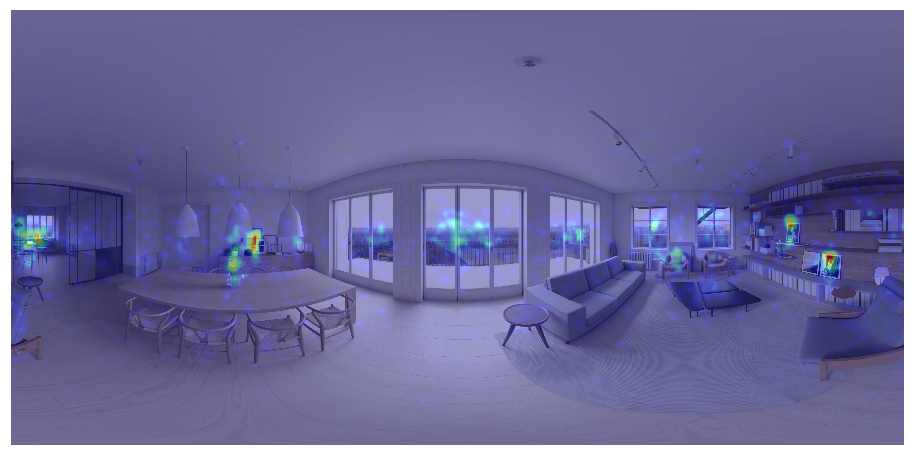

In [46]:
print(os.getcwd())
gaze_salmap = get_gaze_salmap(runs_files[0]['data'])
fig, ax = overlay_image_salmap('base_image.png', gaze_salmap)

## Get the head-position only approximation of the ground-truth saliency map

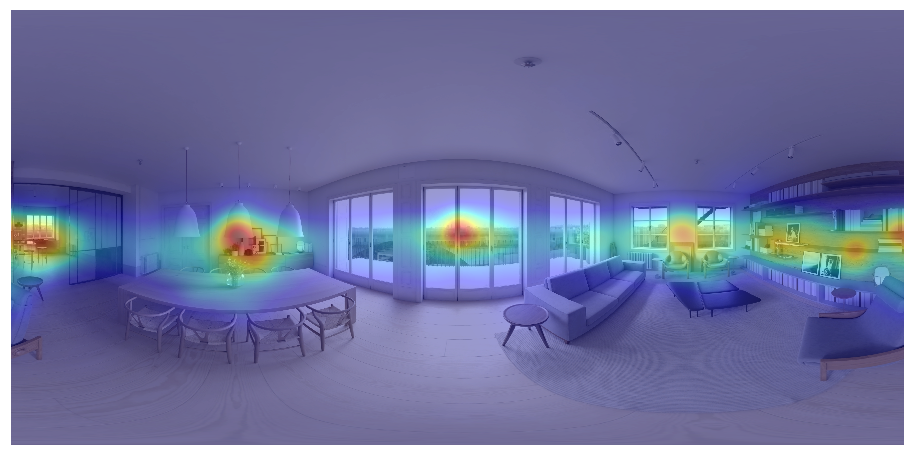

In [47]:
head_salmap = get_head_salmap(runs_files[0]['data'])
fig, ax = overlay_image_salmap('base_image.png', head_salmap)

## Compute the horizon bias baseline

In [48]:
def get_horizon_bias(list_of_runs):
    # We first filter out the fixations in the first few seconds around the starting point.
    # Filter the starting points
    filtered_list = filter_starting_point(list_of_runs)
    horizon_bias_salmap = get_gaze_salmap(filtered_list)

    # We now fit a laplacian to the data, where the longitudinal component is marginalized out.
    all_fix_lats = np.vstack([run['gaze_fixations_single'][run['gaze_fixations_single'][:,1]!=0] for run in filtered_list])[:, 1]*180.0

    param = scipy.stats.laplace.fit(all_fix_lats)

    fig = plt.figure(figsize=(24.0, 9.0))
    gs = matplotlib.gridspec.GridSpec(1,4)
    gs.update(wspace=0.05)

    ax1 = fig.add_subplot(gs[0, 1:4])
    ax2 = fig.add_subplot(gs[0, 0], sharey=ax1)

    ax1.imshow(horizon_bias_salmap, cmap=plt.cm.jet, extent=[0, 360, 0, 180])
    ax1.axis('off')

    ax2.hist(all_fix_lats, bins=90, normed=True, alpha=0.6, color='g', orientation='horizontal')

    ymin, ymax = ax2.get_ylim()
    y = np.arange(180)
    p = scipy.stats.laplace.pdf(y, *param[:-2], loc=param[-2], scale=param[-1])

    ax2.plot(p, y, 'k', linewidth=2)
    ax2.set_ylim([180, 0])
    ax2.axis('off')
    ax2.invert_xaxis()
    
    return param

/opt/anaconda3/envs/base-2.7/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


(91.39140332659433, 17.91483857677794)


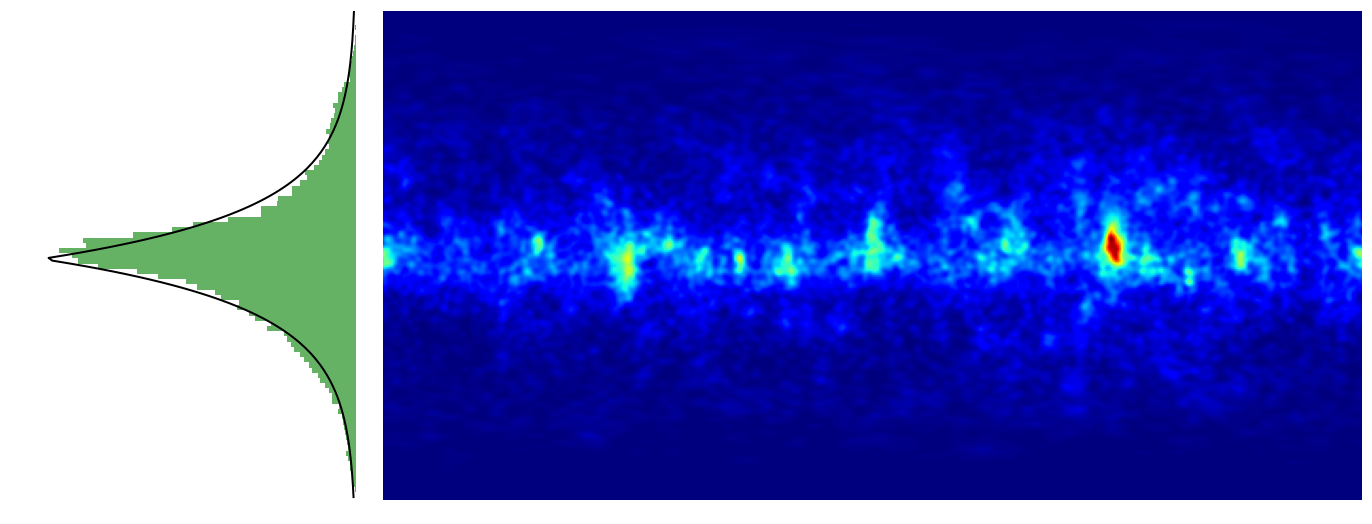

(91.22257198277276, 15.146517401350195)


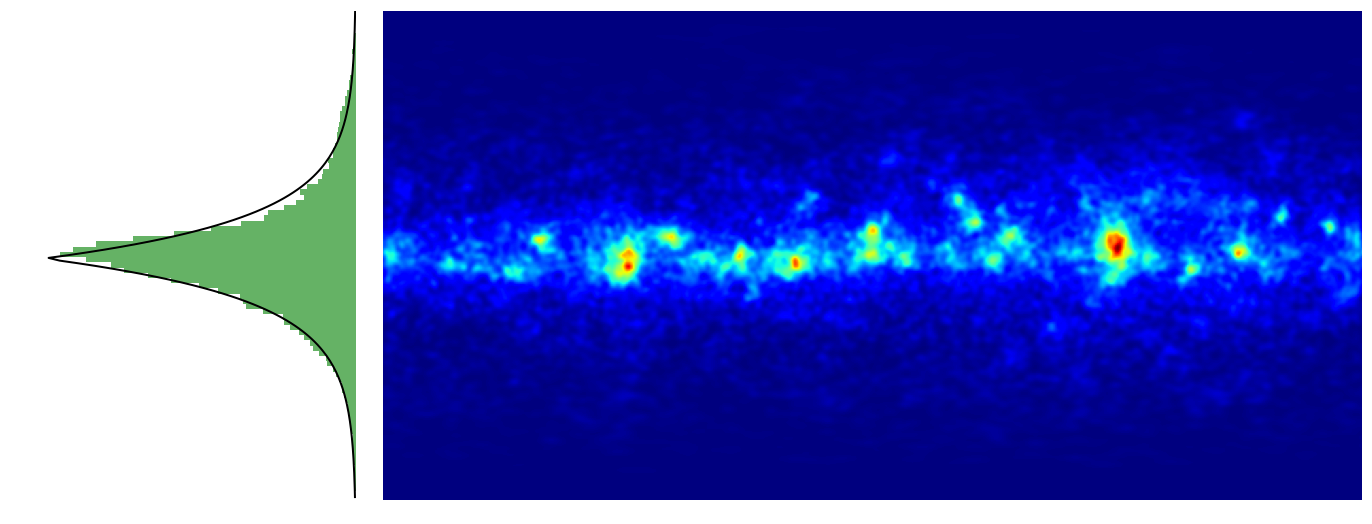

In [49]:
print(get_horizon_bias(all_runs_list))
plt.show()
print(get_horizon_bias(all_runs_list_browser))
plt.show()

## Gaze and head movement analysis

In [50]:
def get_full_df(list_of_runs, mode='vr'):
    # Build a matrix of *all* measurements
    data_matrix, pred_columns = get_data_matrix(list_of_runs, column_set=mode)
    df = pd.DataFrame(data_matrix, columns=pred_columns)

    # Reject measurements that are more than 10 standard deviations away from the mean.
    data_matrix_clean, means, stds = reject_gauss_outliers(data_matrix, pred_columns, m=10)
    df = pd.DataFrame(data_matrix_clean, columns=pred_columns)
    return df

def get_fix_no_fix_data(full_df):
    fix_df = full_df[full_df['gaze_fixations_ind']!=0]
    no_fix_df = full_df[full_df['gaze_fixations_ind']==0]
    fix_data = fix_df[['ang_head_velo_lon','ang_gaze_offset_velo_lon']].values
    no_fix_data = no_fix_df[['ang_head_velo_lon','ang_gaze_offset_velo_lon']].values
    return fix_df, no_fix_df, fix_data, no_fix_data

vr_df = get_full_df(all_runs_list)
fix_df, no_fix_df, fix_data, no_fix_data = get_fix_no_fix_data(vr_df)
browser_df = get_full_df(all_runs_list_browser, mode='browser')

Rejection percentages:
Column gaze_lat_lon_offset_lat: 0.0000
Column gaze_lat_lon_offset_lon: 0.0000
Column gaze_fixations_single_lat: 0.0040
Column gaze_fixations_single_lon: 0.0018
Column ang_gaze_offset_velo_lat: 0.0023
Column ang_gaze_offset_velo_lon: 0.0021
Column ang_head_velo_lat: 0.0003
Column ang_head_velo_lon: 0.0000
Column ang_gaze_velo_lat: 0.0022
Column ang_gaze_velo_lon: 0.0007
Column headTilt: 0.0002
Column gaze_fixations_ind: 0.0000


/opt/anaconda3/envs/base-2.7/lib/python2.7/site-packages/ipykernel_launcher.py:268: RuntimeWarning: invalid value encountered in greater


Rejection percentages:
Column gaze_lat_lon_offset_lat: 0.0000
Column gaze_lat_lon_offset_lon: 0.0000
Column gaze_fixations_single_lat: 0.0040
Column gaze_fixations_single_lon: 0.0056
Column ang_gaze_offset_velo_lat: 0.0003
Column ang_gaze_offset_velo_lon: 0.0002
Column ang_head_velo_lat: 0.0002
Column ang_head_velo_lon: 0.0002
Column ang_gaze_velo_lat: 0.0002
Column ang_gaze_velo_lon: 0.0001
Column gaze_fixations_ind: 0.0000


## Fixation statistics

In [51]:
def get_fixation_stats(list_of_runs):
    fix_durs = []
    fix_counts = []
    for run in list_of_runs:
        fix_counts.append(len(run['gaze_fixations_raw']))
        for fixation in run['gaze_fixations_raw']:
            fix_durs.append(fixation['duration'])
            
    print(np.mean(fix_durs), np.std(fix_durs))
    print(np.mean(fix_counts), np.std(fix_counts))

    return fix_durs, fix_counts

print("VR")
_ = get_fixation_stats(all_runs_list)
print(np.mean(np.abs(vr_df['gaze_lat_lon_offset_lon'])))
print(np.std(np.abs(vr_df['gaze_lat_lon_offset_lon'])))
print('')

print("Browser")
_ = get_fixation_stats(all_runs_list_browser)
print(np.mean(np.abs(browser_df['gaze_lat_lon_offset_lon'])))
print(np.std(np.abs(browser_df['gaze_lat_lon_offset_lon'])))

VR
(0.2661880806315424, 0.1324995300646774)
(55.35897435897436, 12.850695241068856)
12.03556542094172
10.715029927515417

Browser
(0.25346992106883304, 0.12421519976135226)
(49.682981090100114, 15.040495933334972)
19.82856552569457
14.818574580332621


### Vestibolu-Ocular reflex

(-400, 400)

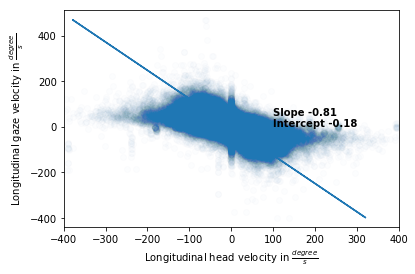

In [52]:
# Formatting
font = {'family': 'sans',
        'weight': 'bold',
        'size': 10,
        }
hist_kws={"histtype": "step", "linewidth": 2, "alpha": 1}

# Fit a line to the fixation data - we should see the vestibulo-ocular reflex!
slope, intercept, r, p, _ = scipy.stats.linregress(fix_data[:, 0], fix_data[:, 1])

fig, ax = plt.subplots(1, 1)
ax.scatter(fix_data[:, 1], fix_data[:, 0], alpha = 0.01, facecolor=None)
ax.plot(fix_data[:, 0]*slope + intercept, fix_data[:, 0])
ax.text(100, 0.007, "Slope %0.2f\nIntercept %0.2f"%(slope, intercept), fontdict=font, horizontalalignment='left')

ax.set_xlabel(r'Longitudinal head velocity in $\frac{degree}{s}$')
ax.set_ylabel(r'Longitudinal gaze velocity in $\frac{degree}{s}$')

ax.set_xlim([-400,400])

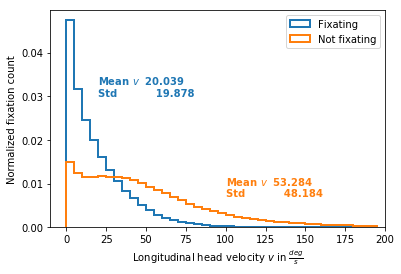

In [54]:
fix_velos = np.absolute(fix_df['ang_head_velo_lon'])
no_fix_velos = np.absolute(no_fix_df['ang_head_velo_lon'])

bins = np.arange(0, 200, 5)
ax = sns.distplot(fix_velos, kde=False, 
                  norm_hist=True, hist_kws=hist_kws, bins=bins, label='Fixating')
sns.distplot(no_fix_velos, 
                  kde=False, norm_hist=True, ax=ax, hist_kws=hist_kws, bins=bins, label='Not fixating')

ax.set_xlabel(r"Longitudinal head velocity $v$ in $\frac{deg}{s}$")
ax.set_ylabel(r"Normalized fixation count")
ax.set_xlim([-10, 200])

ax.legend()

font = {'family': 'sans',
        'color':  'black',
        'weight': 'bold',
        'size': 10,
        }

not_fixating = copy.deepcopy(font)
not_fixating.update({'color':sns.color_palette()[1]})

fixating = copy.deepcopy(font)
fixating.update({'color':sns.color_palette()[0]})

ax.text(20, 0.03, 
        "Mean $v$  %.3f\nStd           %.3f"%(np.mean(fix_velos), np.std(fix_velos)),
                                                fontdict=fixating, horizontalalignment='left')
ax.text(100, 0.007, 
        "Mean $v$  %.3f\nStd           %.3f"%(np.mean(no_fix_velos), np.std(no_fix_velos)),\
        fontdict=not_fixating, horizontalalignment='left')
ax.get_figure().savefig('head_velo_fix_distrib.pdf', bbox_inches='tight')

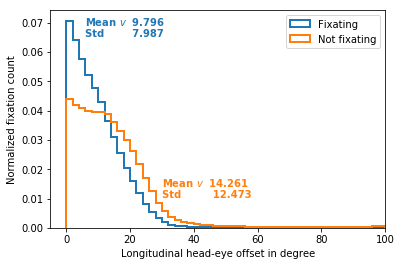

In [53]:
fix_offs = np.absolute(fix_df['gaze_lat_lon_offset_lon'])
no_fix_offs = np.absolute(no_fix_df['gaze_lat_lon_offset_lon'])

bins = np.arange(0, 200, 2)
ax = sns.distplot(fix_offs, bins=bins, kde=False, 
                  norm_hist=True, hist_kws=hist_kws, label='Fixating')
sns.distplot(no_fix_offs, bins=bins, 
                  kde=False, norm_hist=True, ax=ax, hist_kws=hist_kws, label='Not fixating')

ax.set_xlabel(r"Longitudinal head-eye offset in degree")
ax.set_ylabel(r"Normalized fixation count")

ax.legend()
ax.set_xlim([-5, 100])

font = {'family': 'sans',
        'color':  'black',
        'weight': 'bold',
        'size': 10,
        }

not_fixating = copy.deepcopy(font)
not_fixating.update({'color':sns.color_palette()[1]})

fixating = copy.deepcopy(font)
fixating.update({'color':sns.color_palette()[0]})

ax.text(6, 0.065, 
        "Mean $v$  %.3f\nStd        %.3f"%(np.mean(fix_offs), np.std(fix_offs)),
         fontdict=fixating, horizontalalignment='left')
ax.text(30, 0.01, 
        "Mean $v$  %.3f\nStd         %.3f"%(np.mean(no_fix_offs), np.std(no_fix_offs)),
         fontdict=not_fixating, horizontalalignment='left')
ax.get_figure().savefig('gaze_off_distrib.pdf', bbox_inches='tight')

## Exploration time

In [55]:
def get_exploration_times(all_runs):
    angles = np.arange(-360.0, 361.0)
    all_times = -1 * np.ones((len(angles), len(all_runs)))

    for run_idx, run in enumerate(all_runs):
        if run_idx % 100 == 0: print run_idx

        timestamps = np.squeeze(run['timestamp'])
        gaze_velos = np.squeeze(run['ang_gaze_velo'][:-1, 1])

        run_offsets = gaze_velos.reshape(-1,1) * np.diff(timestamps).reshape(-1, 1)
        
        # This filters out eyetracking measurement errors.
        bad_rows = np.squeeze(np.abs(run_offsets)>100)
        run_offsets = interpolate_nan_rows(run_offsets, bad_rows)

        offset_integral = np.zeros(len(run_offsets)+1)
        offset_integral[1:] = np.squeeze(np.cumsum(run_offsets, axis=0))

        for angle_idx, angle in enumerate(angles):
            if angle < 0:
                candidate_idcs = np.logical_and(angle > offset_integral, angle <= np.roll(offset_integral, 5, axis=0))
                if not np.any(candidate_idcs): 
                    continue

                min_idx = np.amin(np.where(candidate_idcs)[0])
                discovery_time = run['timestamp'][min_idx]
            else:
                candidate_idcs = np.logical_and(angle <= offset_integral, angle > np.roll(offset_integral, 5, axis=0))
                if not np.any(candidate_idcs):
                    continue

                min_idx = np.amin(np.where(candidate_idcs)[0])
                discovery_time = run['timestamp'][min_idx]

            all_times[angle_idx, run_idx] = discovery_time

    bad_idcs = all_times < 0
    all_times[bad_idcs] = np.NaN

    return all_times

def get_exploration_statistics(all_times):
    expl_times_avg = np.nanmean(all_times, axis=1)
    expl_times_std = np.nanstd(all_times, axis=1)
    expl_times_min = np.nanpercentile(all_times, q=10, axis=1 )
    expl_times_max = np.nanpercentile(all_times, q=90, axis=1 )

    # For linear regression: mirror the negative angles to fit a single line to both sides
    angles = np.arange(-360.0, 361.0)
    angles_linreg = np.copy(angles)
    angles_linreg[angles_linreg<0] *= -1

    # Fit linear regression to positive angles
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(angles_linreg,expl_times_avg)
    
    return slope, intercept, (expl_times_avg, expl_times_min, expl_times_max)

In [56]:
all_times_vr = get_exploration_times(all_runs_list)

0
100
200
300
400
500
600
700


In [57]:
slope_vr, intercept_vr, expl_time_stats_vr = get_exploration_statistics(all_times_vr)

('Done', '/home/lordgrim/vr-saliency/src')


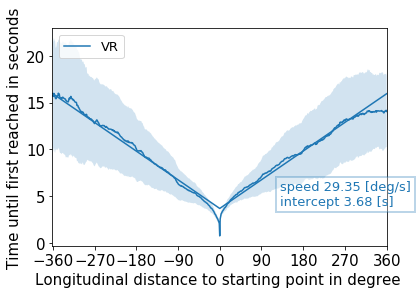

In [60]:
fig, ax = plt.subplots(1)

angles = np.arange(-360.0, 361.0)

ax.plot(angles, expl_time_stats_vr[0], color=sns.color_palette()[0])
# ax.plot(angles, expl_time_stats_bw[0], color=sns.color_palette()[1])

# ax.plot(angles, expl_times_min, angles, expl_times_max, color='lightblue', alpha=0.4)

ax.plot(angles, np.abs(angles*slope_vr) + intercept_vr, c=sns.color_palette()[0], label='VR')
# ax.plot(angles, np.abs(angles*slope_bw) + intercept_bw, c=sns.color_palette()[1], label='Browser')

font = {'family': 'sans',
        'weight': 'normal',
        'size': 13,
        }

vr_font = copy.deepcopy(font)
vr_font.update({'color':sns.color_palette()[0]})

# bw_font = copy.deepcopy(font)
# bw_font.update({'color':sns.color_palette()[1]})

props = dict(boxstyle='square', fc='white', lw=2, alpha=0.3)
props_vr = copy.copy(props)
# props_bw = copy.copy(props)
props_vr.update({'ec':sns.color_palette()[0]})
# props_bw.update({'ec':sns.color_palette()[1]})

ax.text(130, 4, "speed %0.2f [deg/s]\nintercept %0.2f [s]"%(1/slope_vr, intercept_vr), 
        fontdict=vr_font, horizontalalignment='left', bbox=props_vr)
# ax.text(130, 19, "speed %0.2f [deg/s]\nintercept %0.2f [s]"%(1/slope_bw, intercept_bw), 
#         fontdict=bw_font, horizontalalignment='left', bbox=props_bw)

std_region_vr = (expl_time_stats_vr[0] - expl_time_stats_vr[1], expl_time_stats_vr[0] + expl_time_stats_vr[1])
# std_region_bw = (expl_time_stats_bw[0] - expl_time_stats_bw[1], expl_time_stats_bw[0] + expl_time_stats_bw[1])

ax.fill_between(angles, std_region_vr[0], std_region_vr[1], facecolor=sns.color_palette()[0], alpha=0.2)
# ax.fill_between(angles, std_region_bw[0], std_region_bw[1], facecolor=sns.color_palette()[1], alpha=0.2)

ax.set_xlim([-361, 361])
ax.set_xlabel('Longitudinal distance to starting point in degree ', fontsize=15)
ax.set_ylabel('Time until first reached in seconds', fontsize=15)
ax.tick_params(axis='both', labelsize=15)

ax.legend(frameon=True, fontsize=13, loc=2)

_ = ax.set_xticks(np.linspace(-360, 360, num=9))

fig.savefig('exploration_time.pdf', bbox_inches='tight')
print("Done",os.getcwd())